In [169]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import pydotplus
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

from IPython.display import display
from sklearn.decomposition import PCA
import renders as rs

from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools

In [170]:
SURVEY_PATH = 'datasets/survey'

In [171]:
def load_survey_data():
# Change code to extract file from Github repository
#     if not os.path.isdir(survey_path):
#         os.makedirs(survey_path)
#     print(os.getcwd())
#     file_path = os.path.join(survey_path, 'All_Responses_Removed.csv')
    df = pd.read_csv('All_Responses_Removed.csv')
    return df

In [172]:
user_responses = load_survey_data()


In [173]:
# user_responses.head()

In [174]:
# user_responses.describe()

In [175]:
user_responses.drop(columns=['Prolific ID'], inplace=True)

In [176]:
user_responses.columns = user_responses.columns.str.replace(r'[\s\n\t ]+', '-')
user_responses.columns = user_responses.columns.str.replace(r'[a-d]-', '-')
demographics_data = user_responses.iloc[:,:8]
demographics_user_responses = demographics_data.reindex(sorted(demographics_data.columns), axis=1)
question_subset = user_responses.reindex(sorted(user_responses.columns[8:]), axis=1)
reordered_user_responses = pd.concat([demographics_user_responses, question_subset], axis=1)

In [177]:
relevant_indexes = []
demographics_column_indexes = ['Age', 'Gender', 'IUIPC-Awareness', 'IUIPC-Collection', 'IUIPC-Control',
                               'Online-Presence', 'Personal-Stability', 'Reciprocity']

relevant_indexes.extend(demographics_column_indexes)

In [178]:
# reordered_user_responses.loc[reordered_user_responses['Age'] <= 17, 'Age'] = 0
# reordered_user_responses.loc[
#     (reordered_user_responses['Age'] > 17) & (reordered_user_responses['Age'] <= 24), 'Age'] = 1
# reordered_user_responses.loc[
#     (reordered_user_responses['Age'] > 24) & (reordered_user_responses['Age'] <= 34), 'Age'] = 2
# reordered_user_responses.loc[
#     (reordered_user_responses['Age'] > 34) & (reordered_user_responses['Age'] <= 44), 'Age'] = 3
# reordered_user_responses.loc[
#     (reordered_user_responses['Age'] > 44) & (reordered_user_responses['Age'] <= 54), 'Age'] = 4
# reordered_user_responses.loc[
#     (reordered_user_responses['Age'] > 54) & (reordered_user_responses['Age'] <= 64), 'Age'] = 5
# reordered_user_responses.loc[reordered_user_responses['Age'] > 64, 'Age'] = 6

# reordered_user_responses.loc[reordered_user_responses['Online-Presence'] <= 5, 'Online-Presence'] = 0
# reordered_user_responses.loc[(reordered_user_responses['Online-Presence'] > 5) & (
#         reordered_user_responses['Online-Presence'] <= 10), 'Online-Presence'] = 1
# reordered_user_responses.loc[(reordered_user_responses['Online-Presence'] > 10) & (
#         reordered_user_responses['Online-Presence'] <= 15), 'Online-Presence'] = 2
# reordered_user_responses.loc[(reordered_user_responses['Online-Presence'] > 15) & (
#         reordered_user_responses['Online-Presence'] <= 20), 'Online-Presence'] = 3
# reordered_user_responses.loc[(reordered_user_responses['Online-Presence'] > 20) & (
#         reordered_user_responses['Online-Presence'] <= 25), 'Online-Presence'] = 4

In [179]:
# reordered_user_responses.iloc[:, 10:207:4] = reordered_user_responses.iloc[:, 10:207:4].replace([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], 0)
# reordered_user_responses.iloc[:, 10:207:4] = reordered_user_responses.iloc[:, 10:207:4].replace([7.0], 1)

In [180]:
def data_transformation(data):
    scaler = StandardScaler()
    standard_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

    transformer = PowerTransformer()
    transformed_data = pd.DataFrame(transformer.fit_transform(standard_data), columns=data.columns, index=data.index)

    return scaler, transformer, transformed_data

In [181]:
def data_scale(data):
    scaler = StandardScaler()
    standard_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

    return scaler, standard_data

In [182]:
def data_inverse_scale(scaler_object, data):
#     inverse_scaled_data = pd.DataFrame(scaler_object.inverse_transform(data),
#                                        columns=data.columns, index=data.index)
    
    inverse_scaled_data = scaler_object.inverse_transform(data)

    return inverse_scaled_data

In [183]:
def remove_outliers(data):
    outliers_lst  = []
    for feature in data.columns:
            # TODO: Calculate Q1 (25th percentile of the data) for the given feature
            Q1 = np.percentile(data.loc[:, feature], 25)

            # TODO: Calculate Q3 (75th percentile of the data) for the given feature
            Q3 = np.percentile(data.loc[:, feature], 75)

            # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
            step = 1.5 * (Q3 - Q1)

            # Display the outliers
#             print("Data points considered outliers for the feature '{}':".format(feature))

            # The tilde sign ~ means not
            # So here, we're finding any points outside of Q1 - step and Q3 + step
            outliers_rows = data.loc[~((data[feature] >= Q1 - step) & (data[feature] <= Q3 + step)), :]
            # display(outliers_rows)

            outliers_lst.append(list(outliers_rows.index))

    outliers = list(itertools.chain.from_iterable(outliers_lst))

    # List of unique outliers
    # We use set()
    # Sets are lists with no duplicate entries
    uniq_outliers = list(set(outliers))

    # List of duplicate outliers
    dup_outliers = list(set([x for x in outliers if outliers.count(x) > 1]))

#     print('Outliers list:\n', uniq_outliers)
#     print('Length of outliers list:\n', len(uniq_outliers))

#     print('Duplicate list:\n', dup_outliers)
#     print('Length of duplicates list:\n', len(dup_outliers))

    # Remove duplicate outliers
    # Only 5 specified
    good_data = data.drop(data.index[dup_outliers]).reset_index(drop = True)

#     # Original Data 
#     print('Original shape of data:\n', cleaned_reordered_user_responses.shape)
#     # Processed Data
#     print('New shape of data:\n', good_data.shape)


    return good_data

/Users/smithkakar/OneDrive - King's College London/MSc/Dissertation/Deliverables/2nd Progress Report/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))
/Users/smithkakar/OneDrive - King's College London/MSc/Dissertation/Deliverables/2nd Progress Report/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))
/Users/smithkakar/OneDrive - King's College London/MSc/Dissertation/Deliverables/2nd Progress Report/Code/renders.py:28: RuntimeWarning:

/Users/smithkakar/OneDrive - King's College London/MSc/Dissertation/Deliverables/2nd Progress Report/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))
/Users/smithkakar/OneDrive - King's College London/MSc/Dissertation/Deliverables/2nd Progress Report/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))
/Users/smithkakar/OneDrive - King's College London/MSc/Dissertation/Deliverables/2nd Progress Report/Code/renders.py:28: RuntimeWarning:

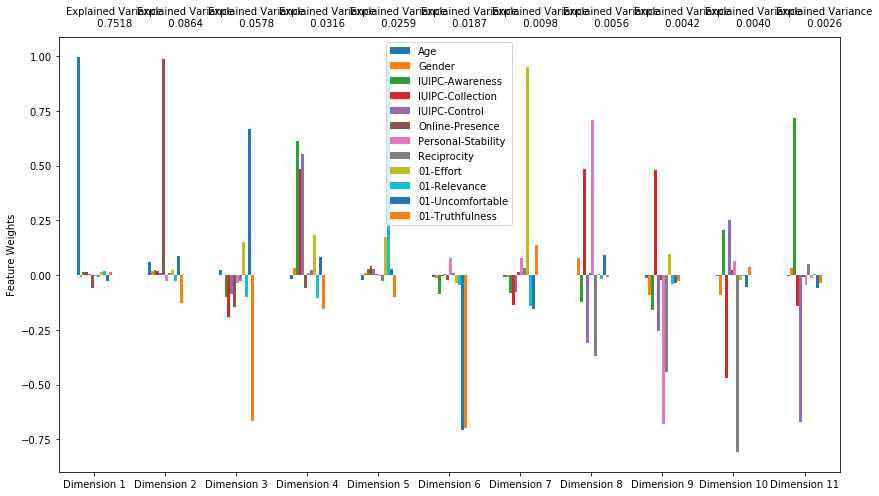

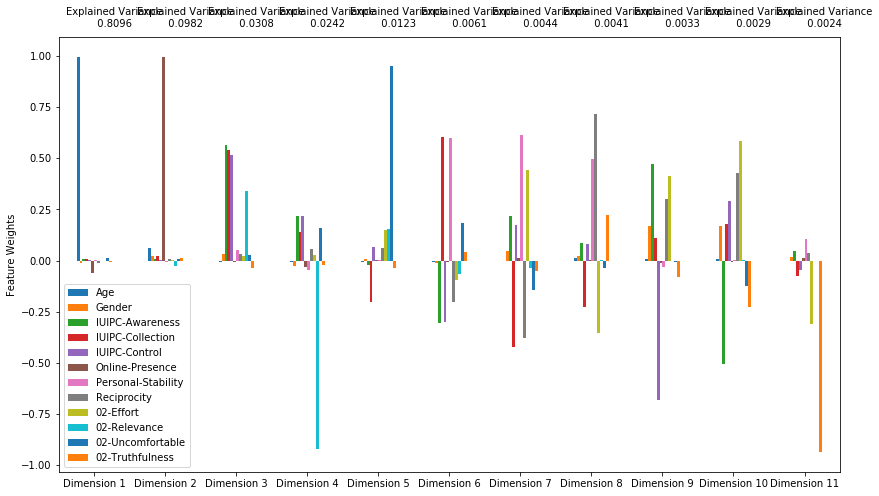

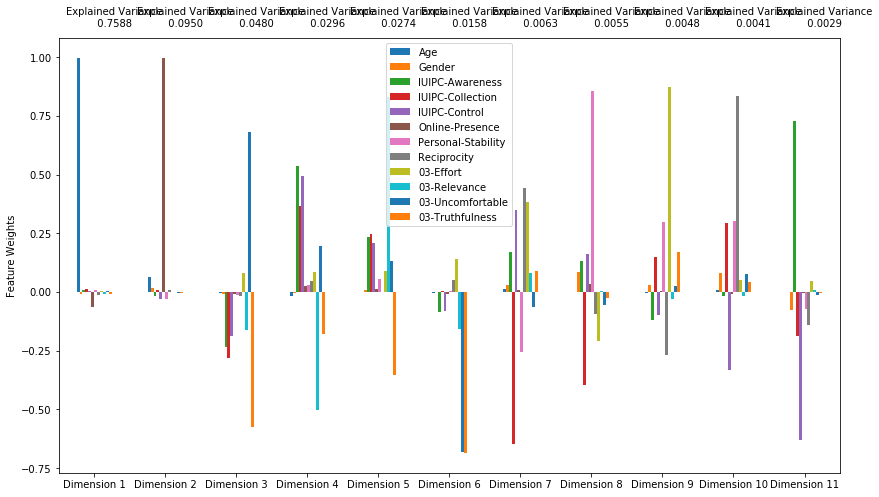

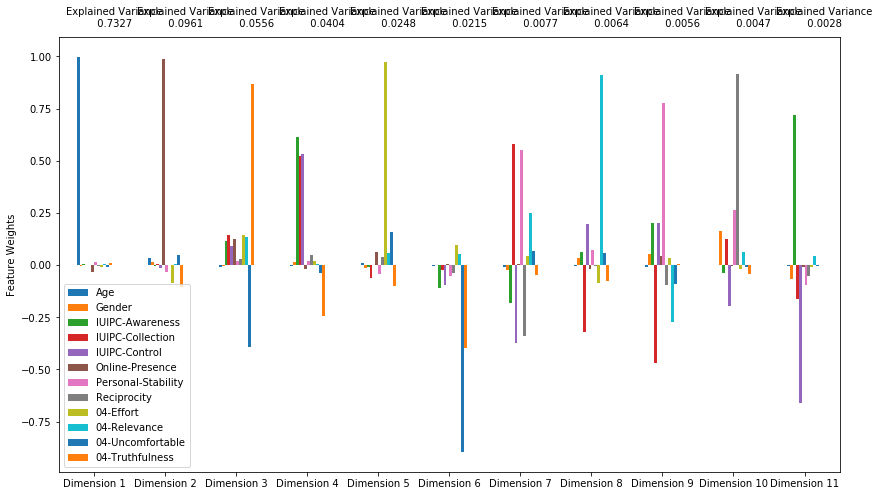

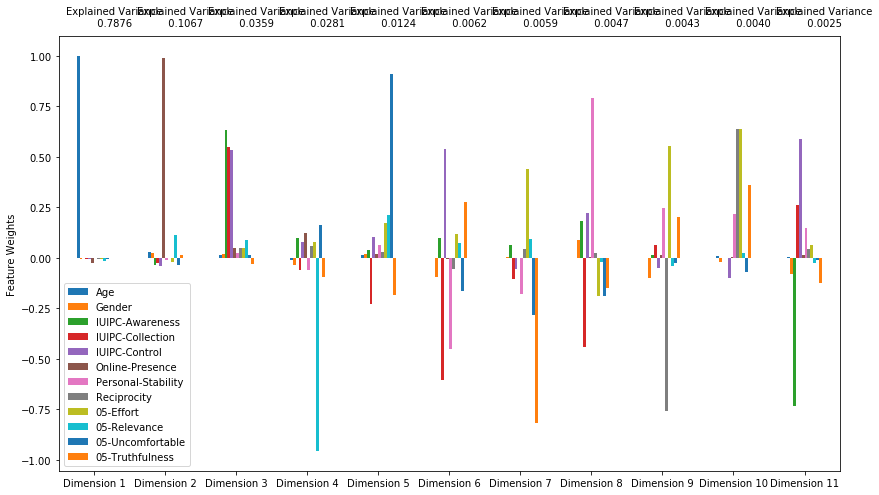

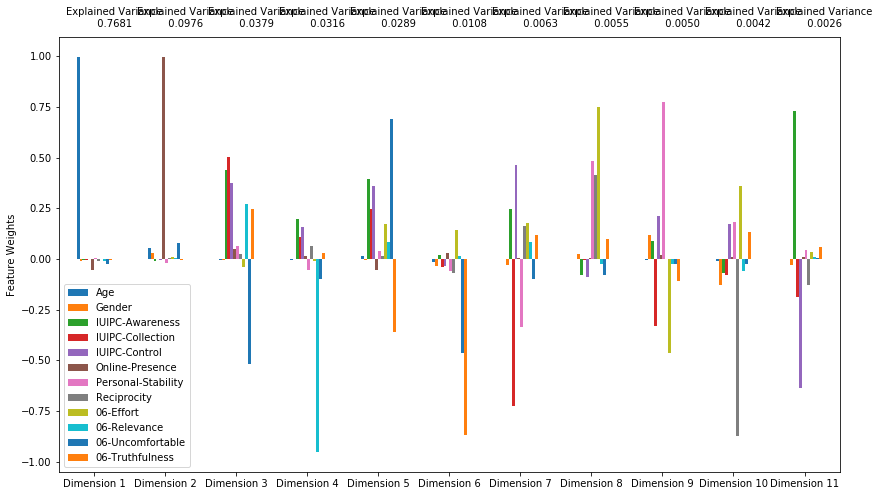

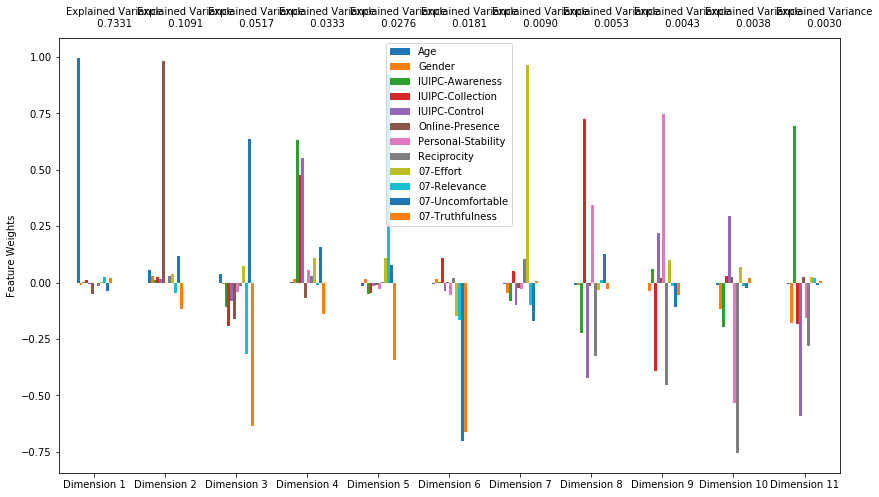

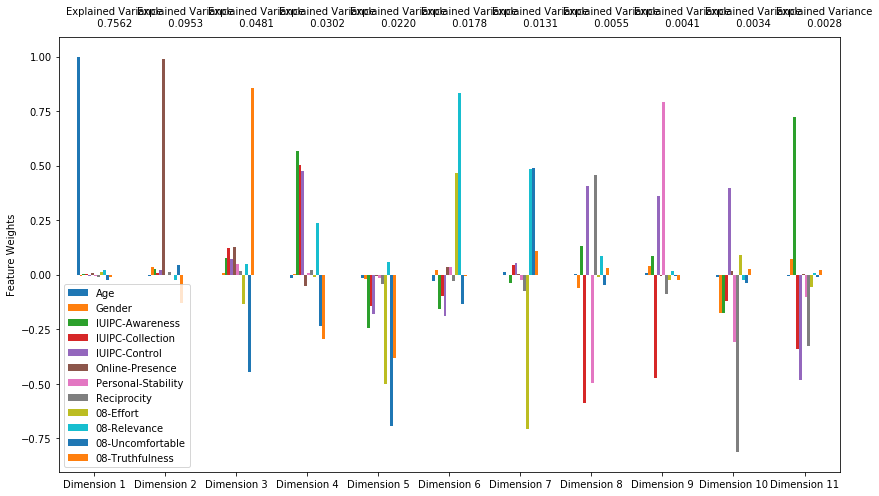

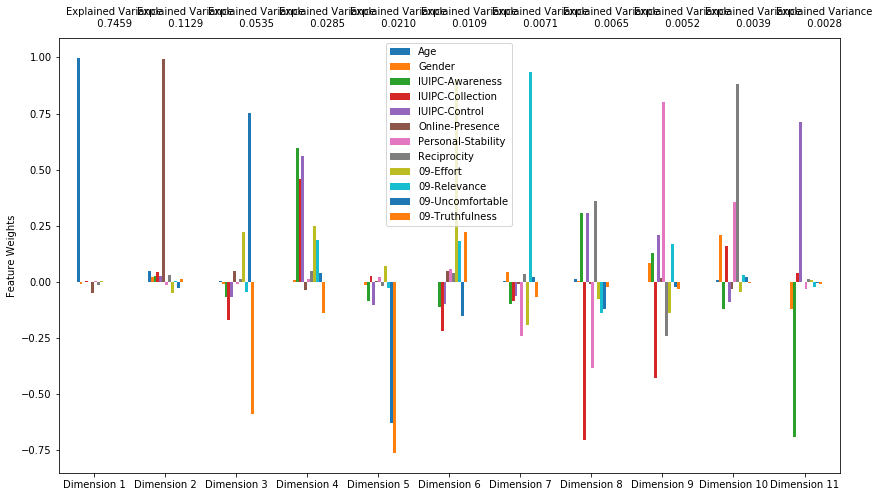

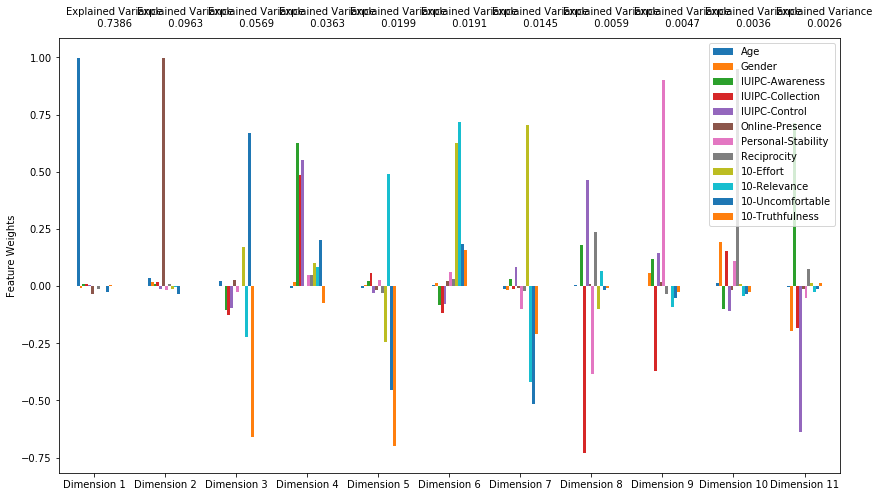

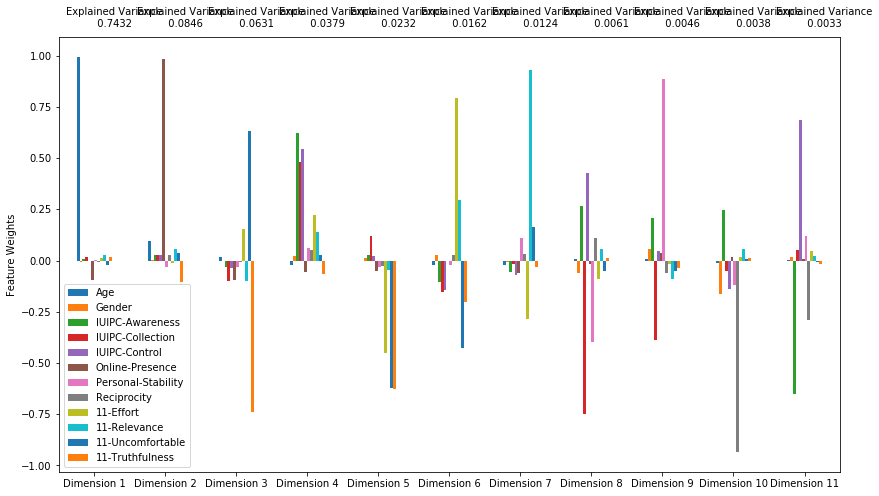

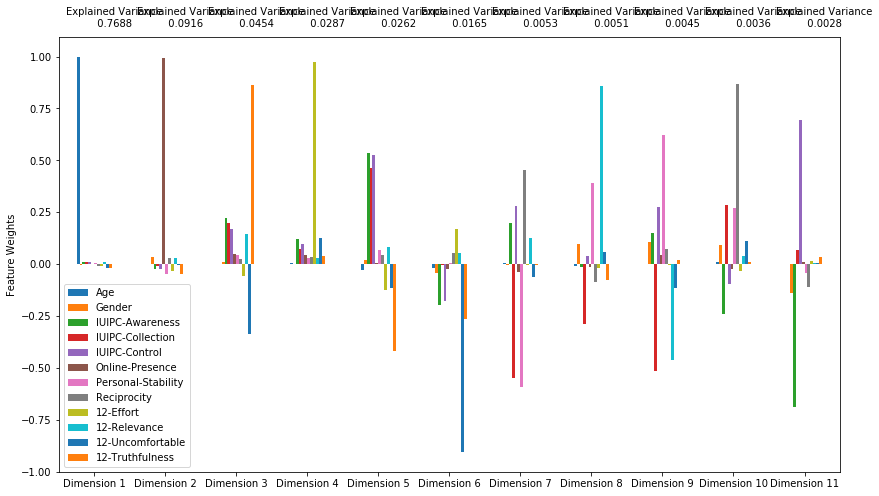

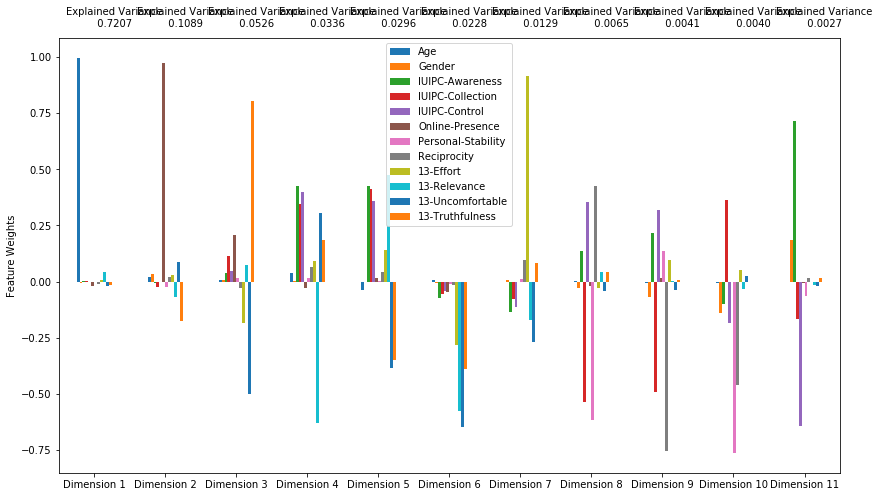

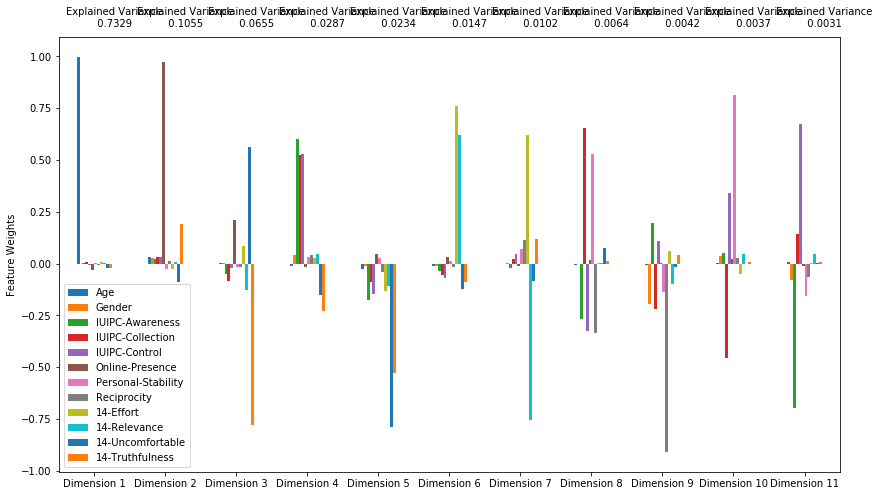

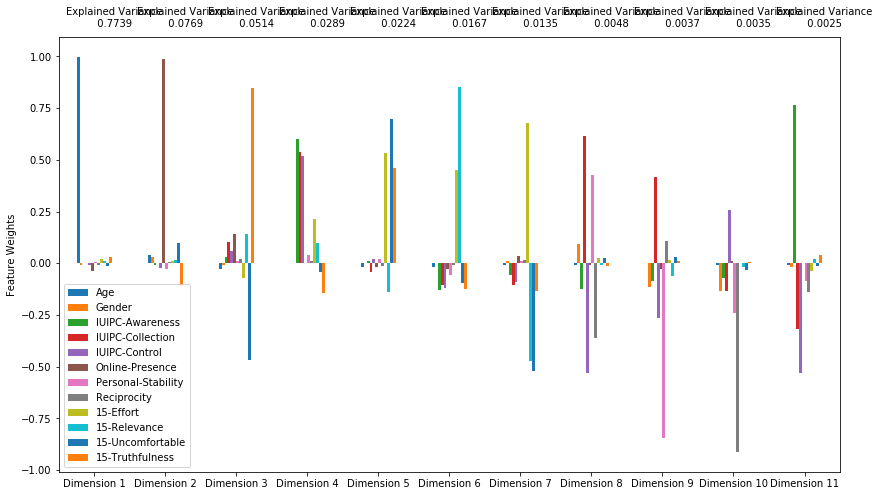

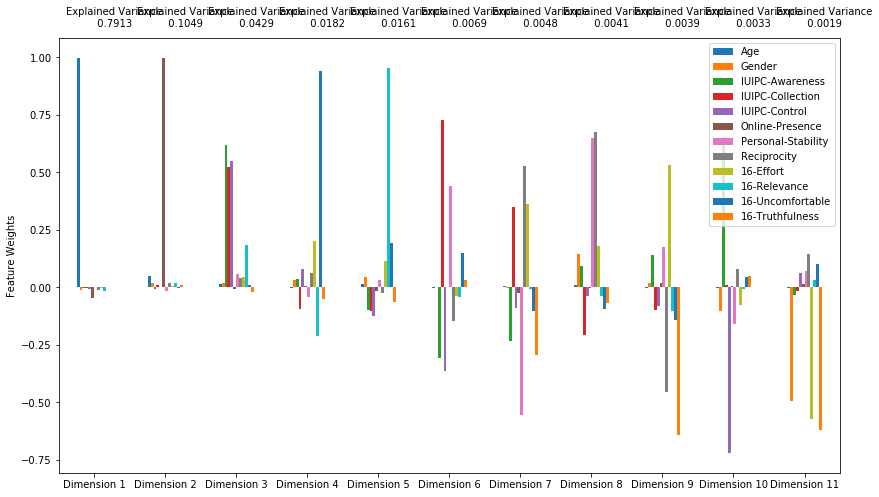

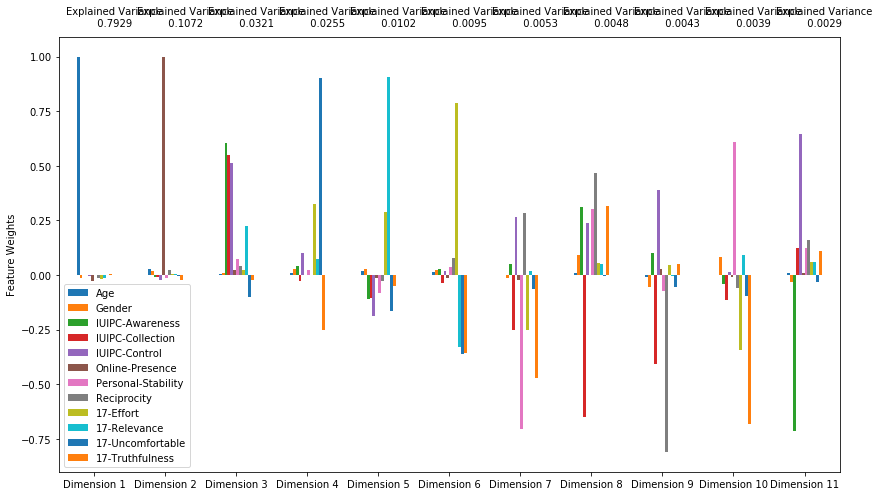

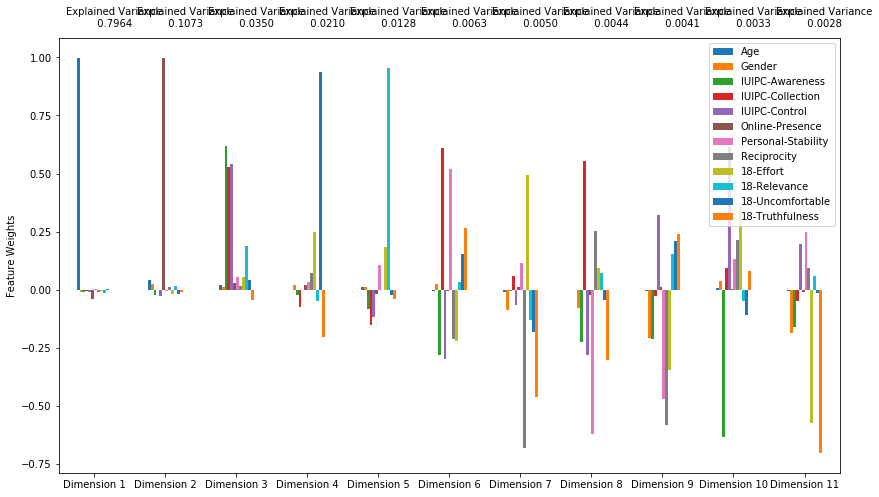

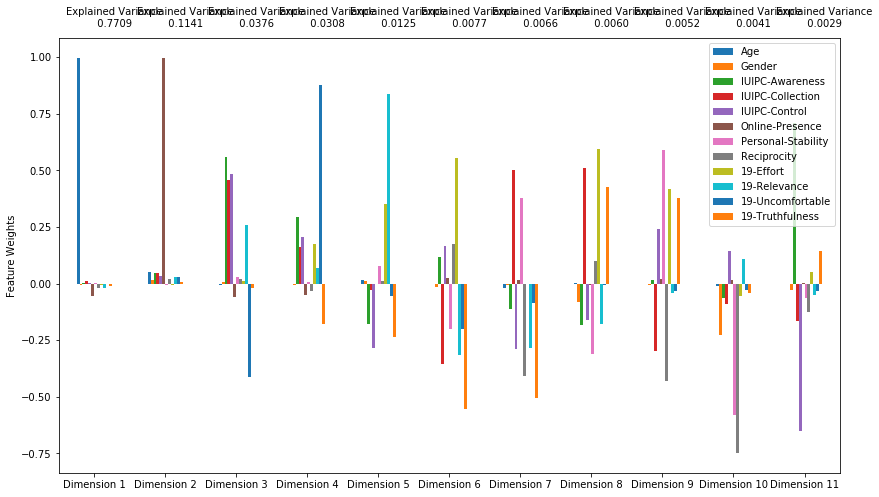

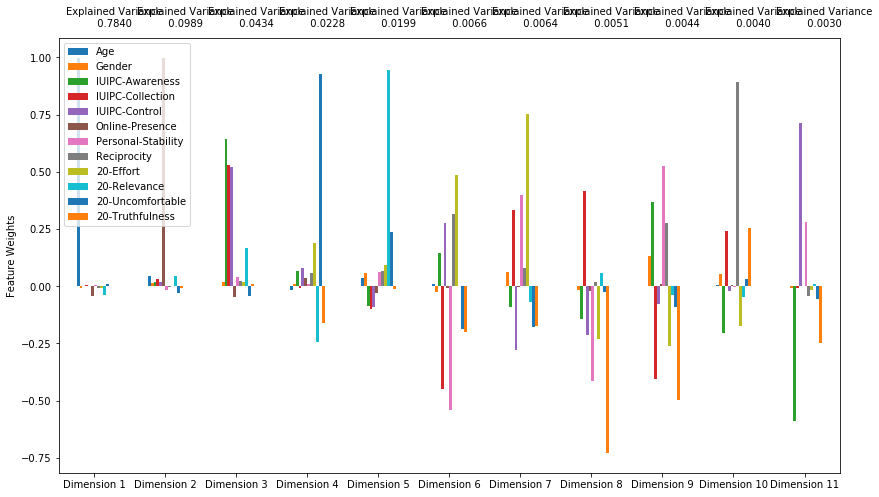

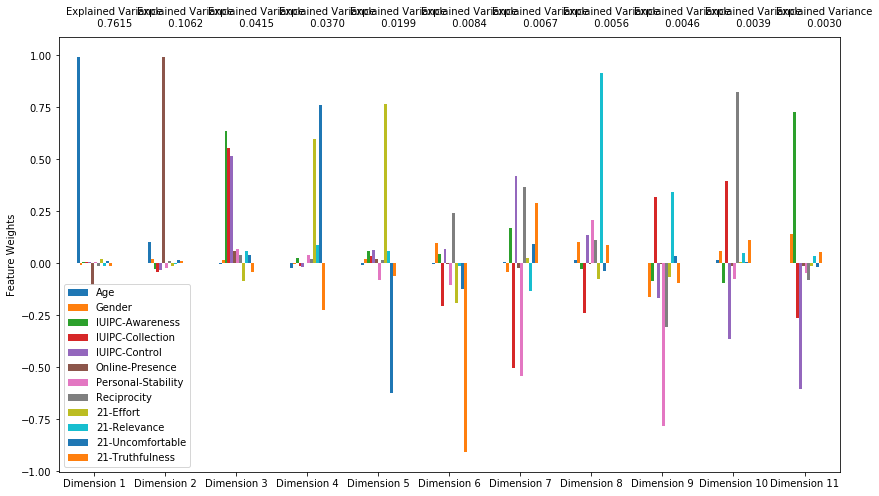

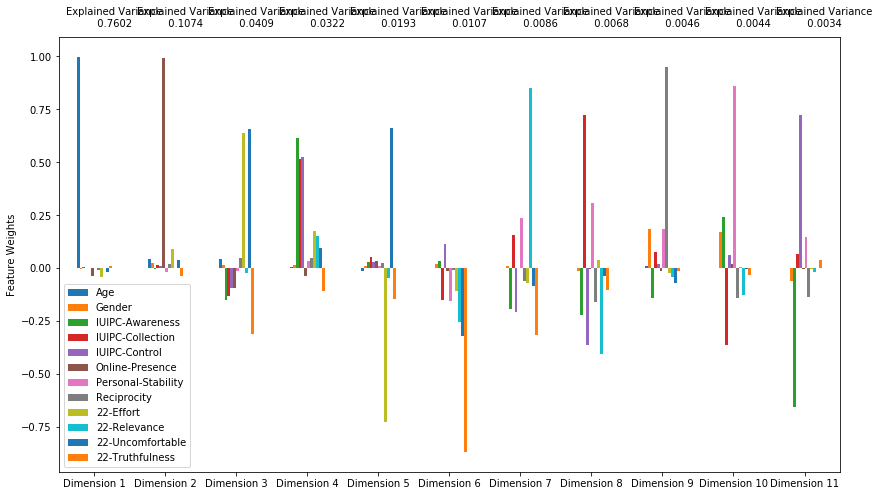

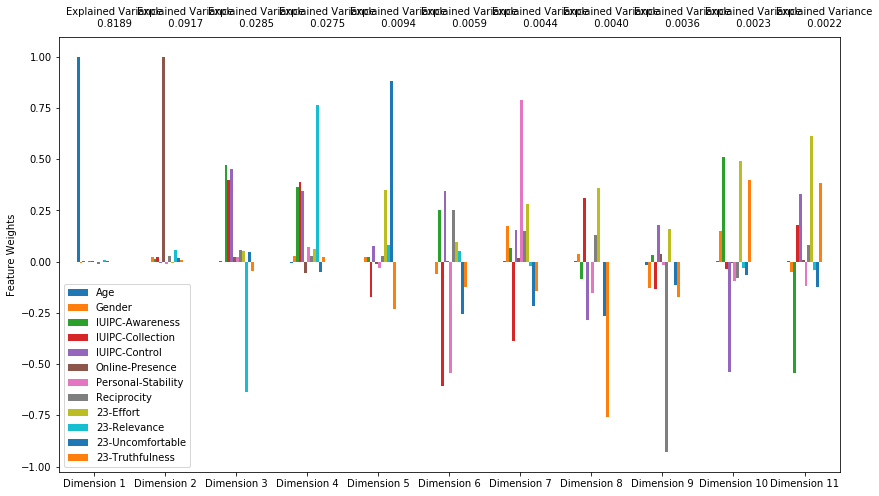

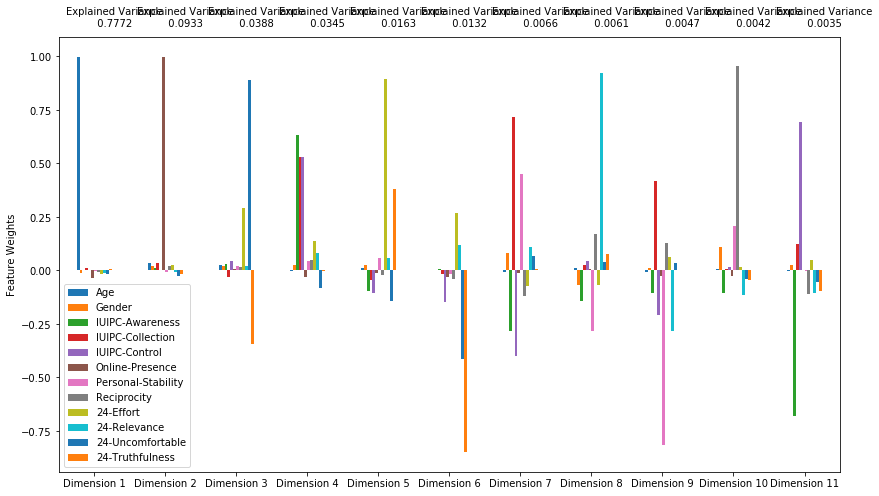

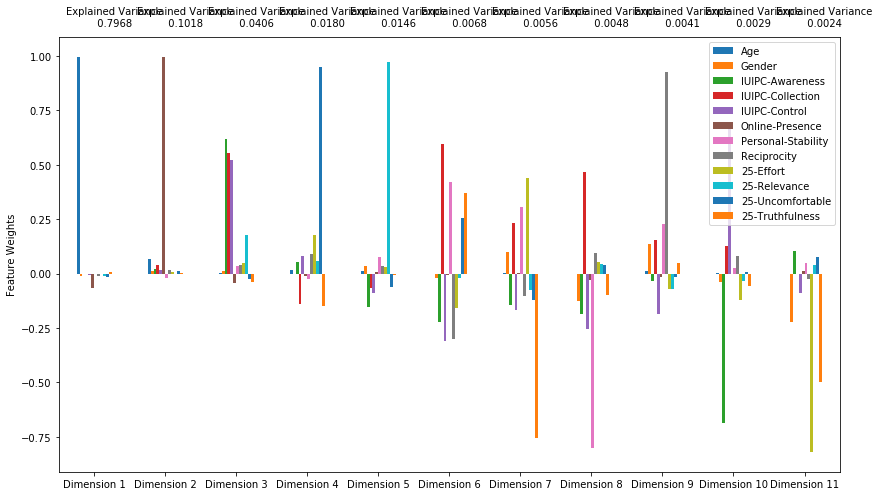

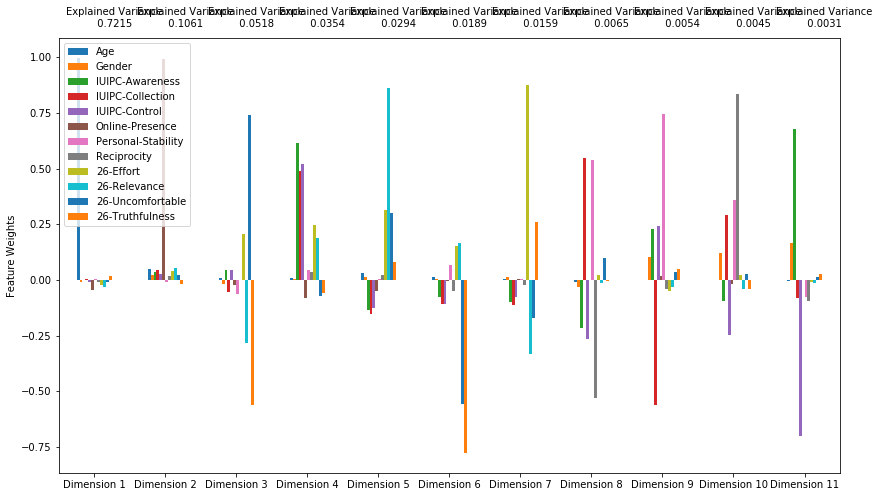

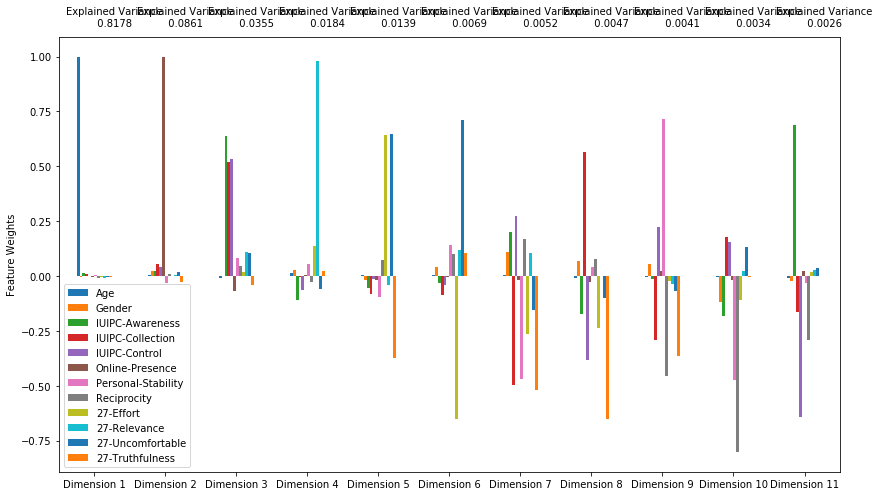

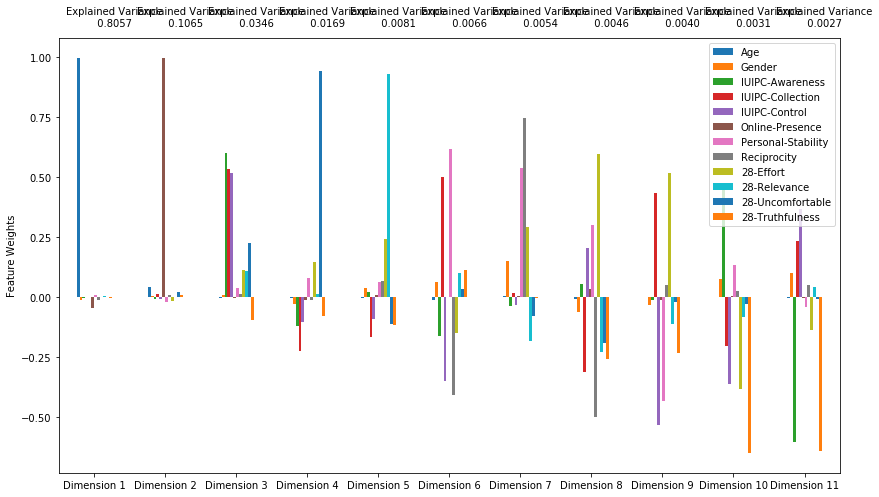

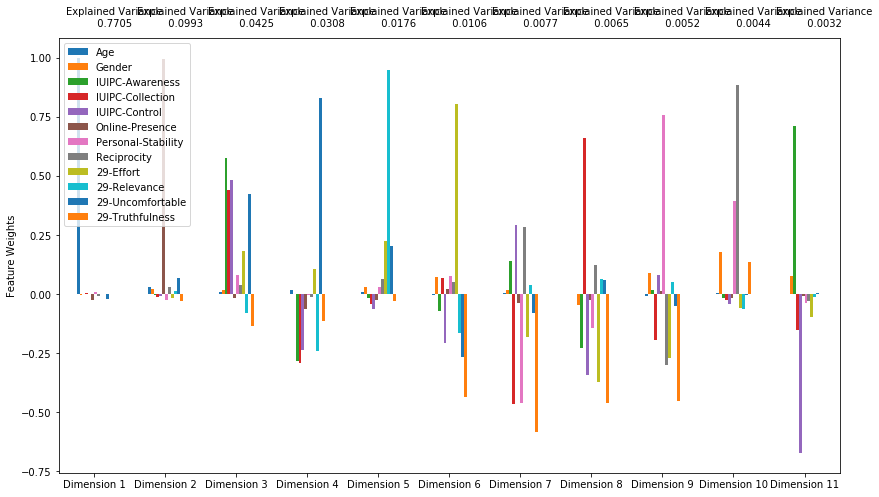

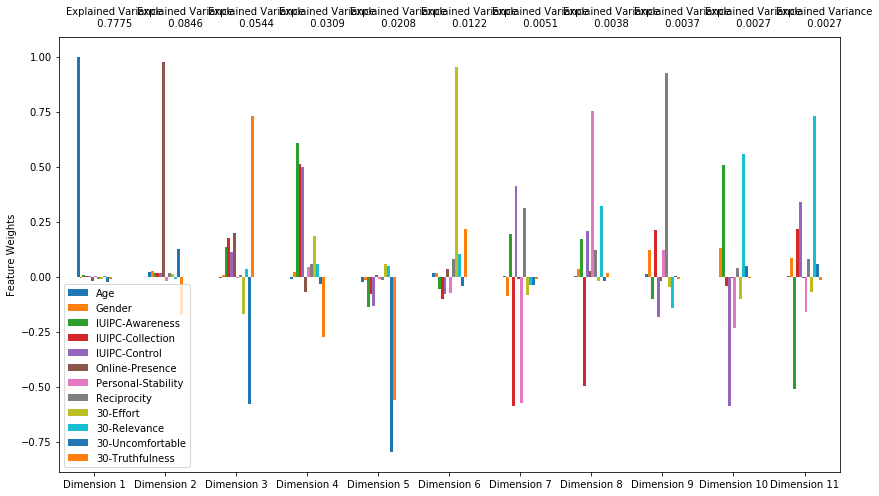

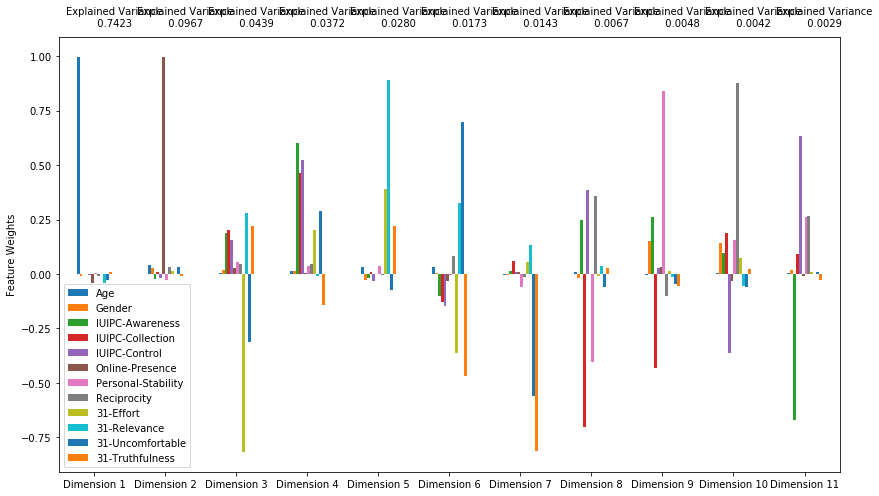

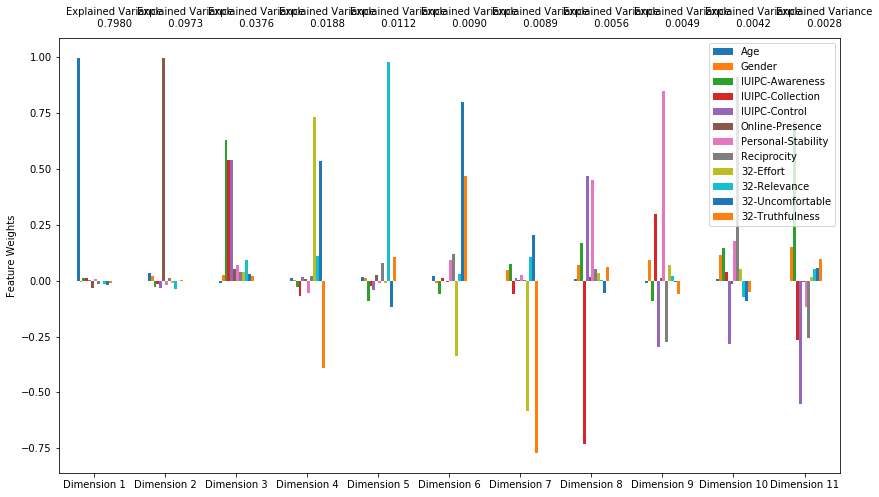

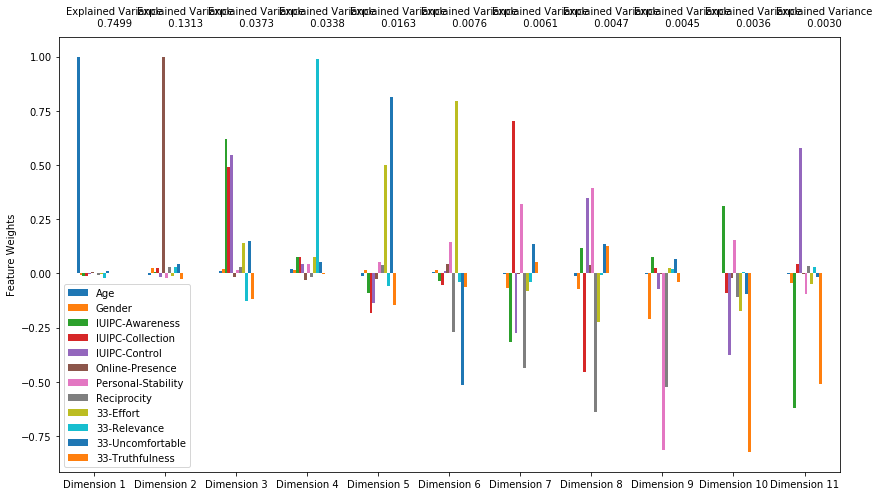

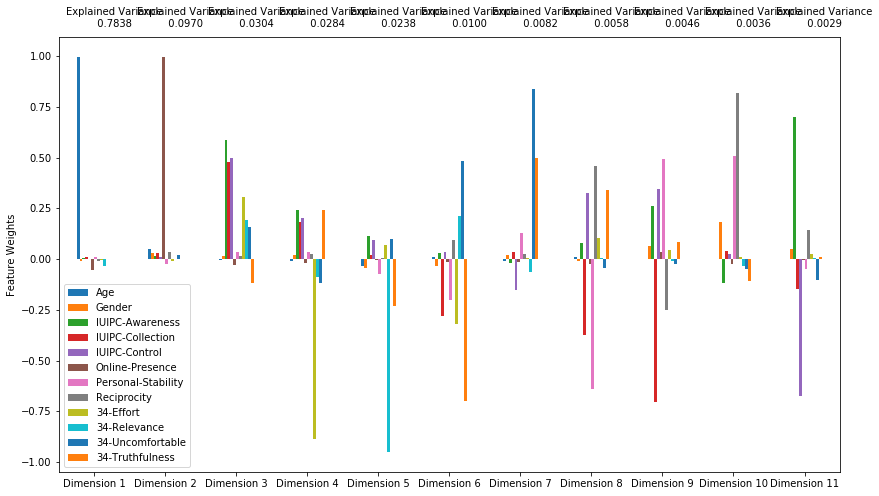

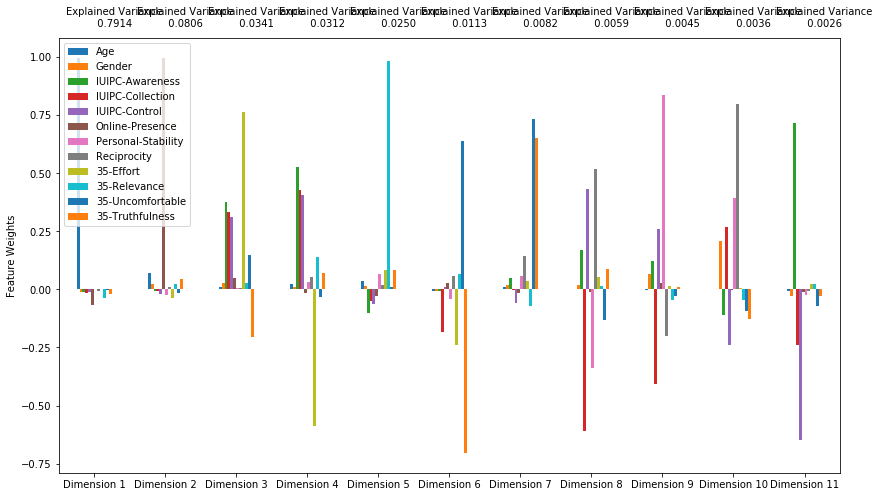

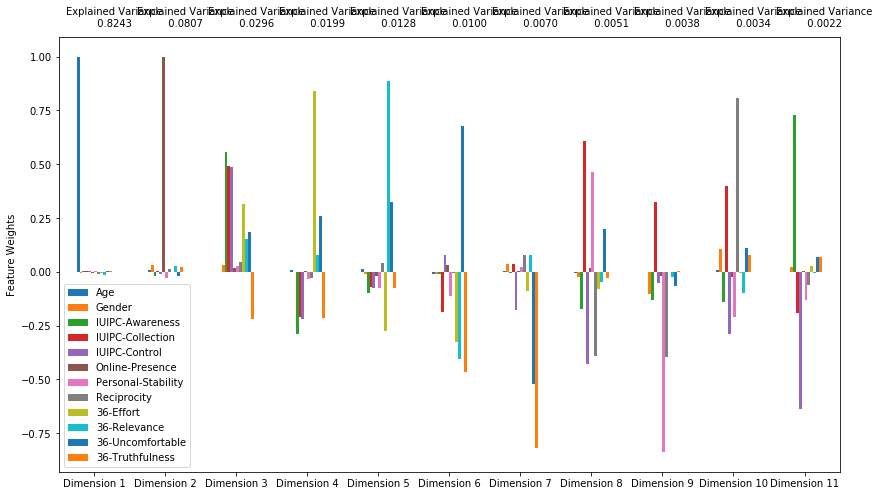

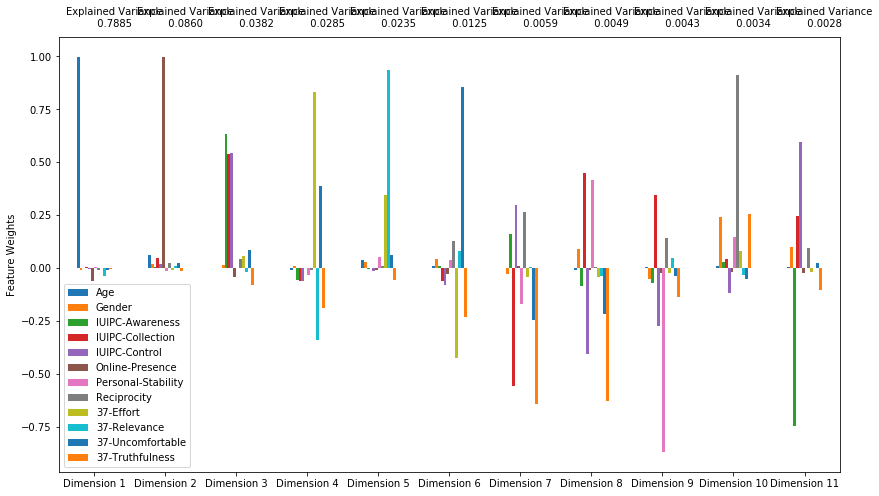

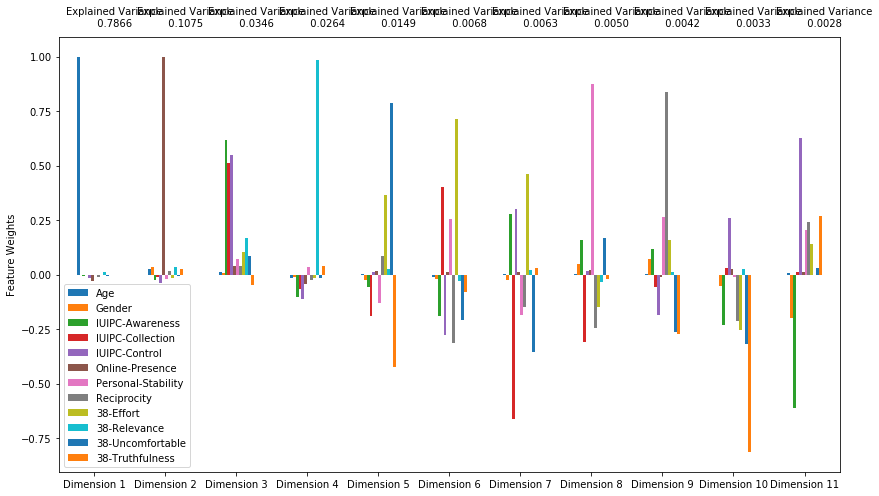

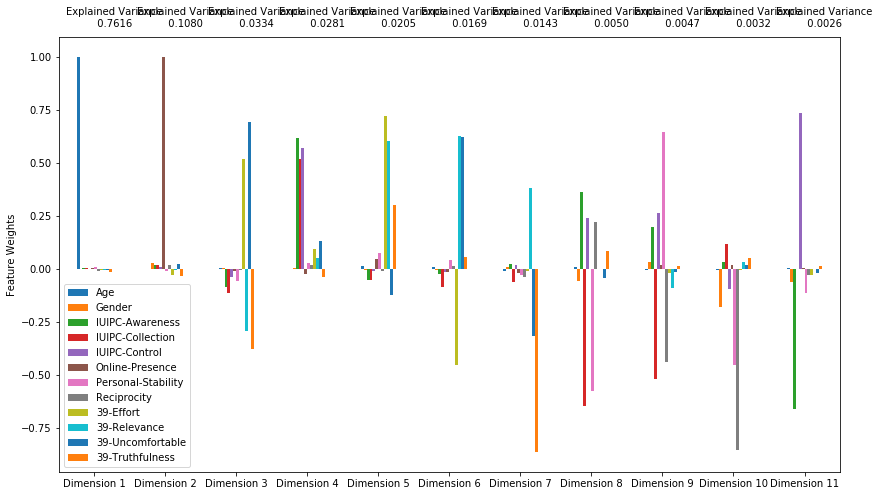

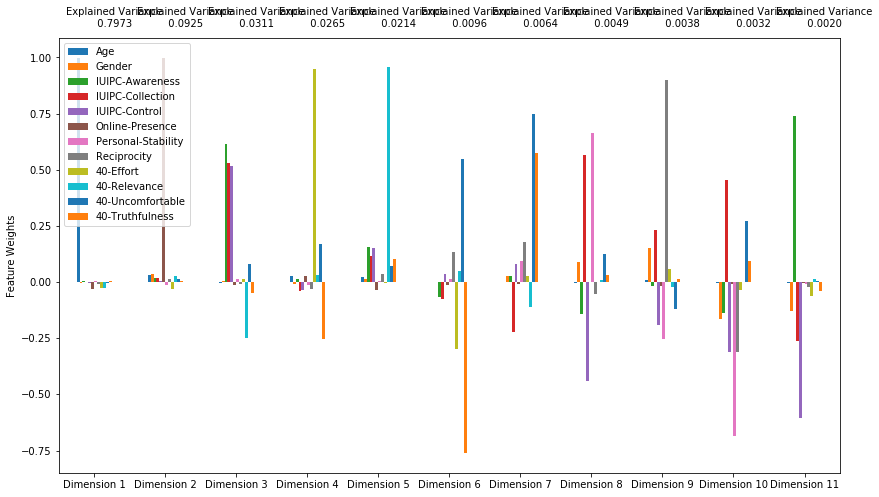

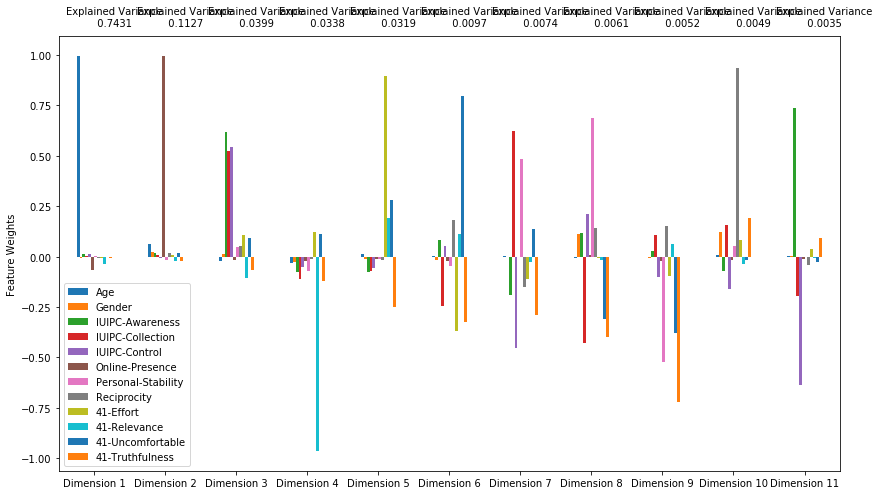

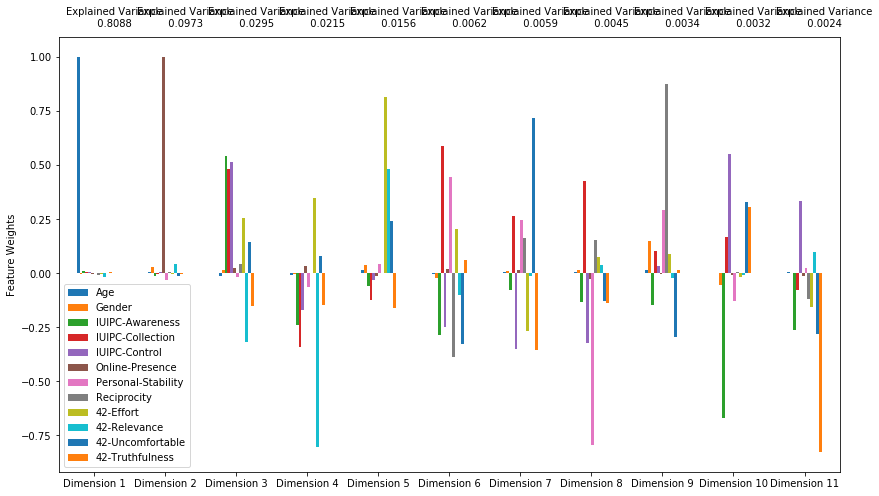

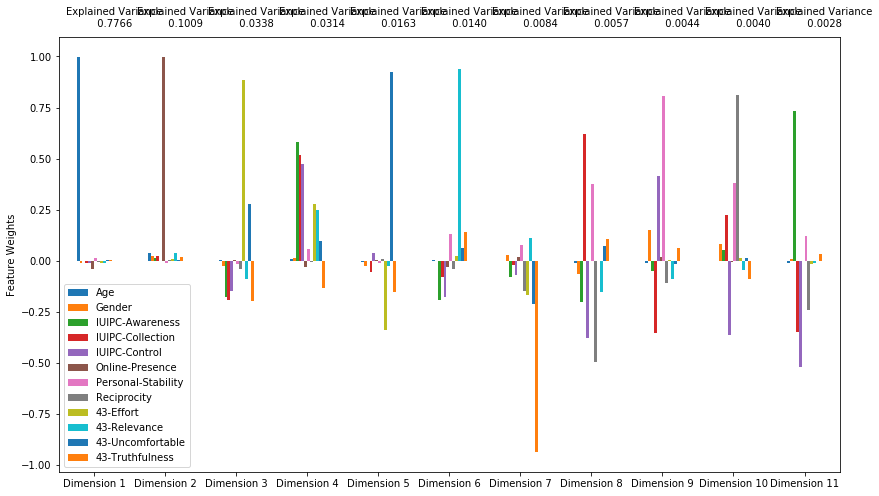

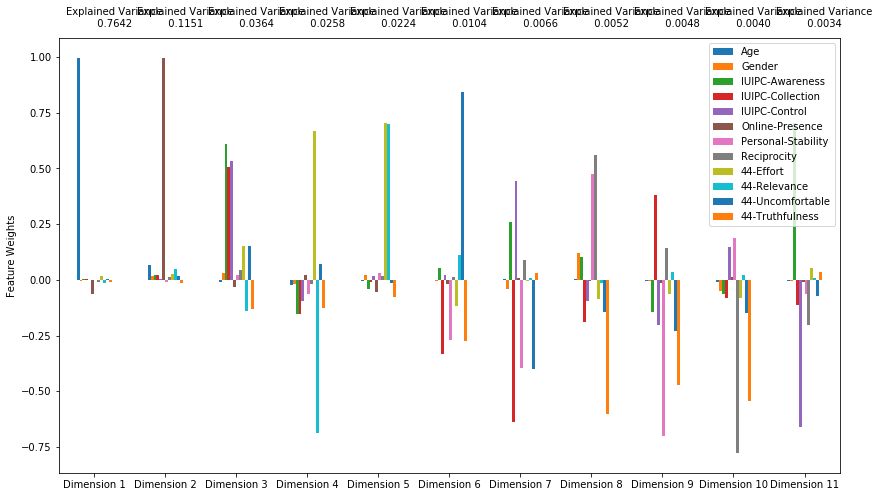

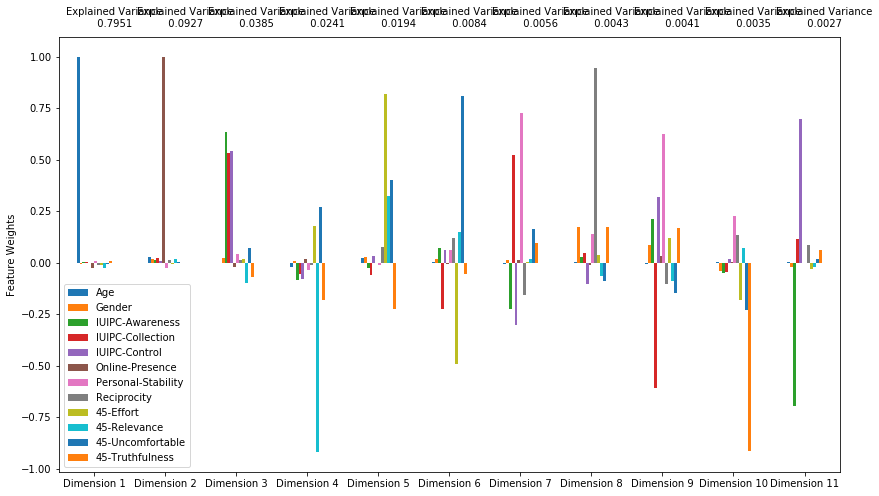

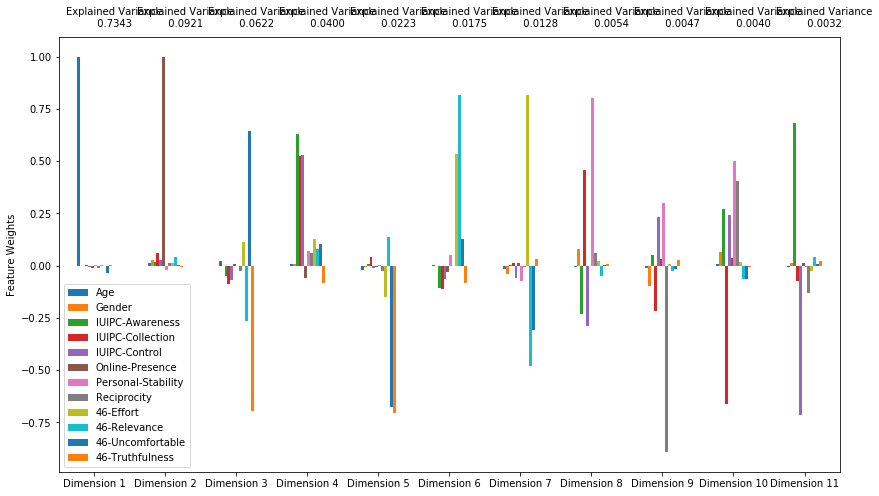

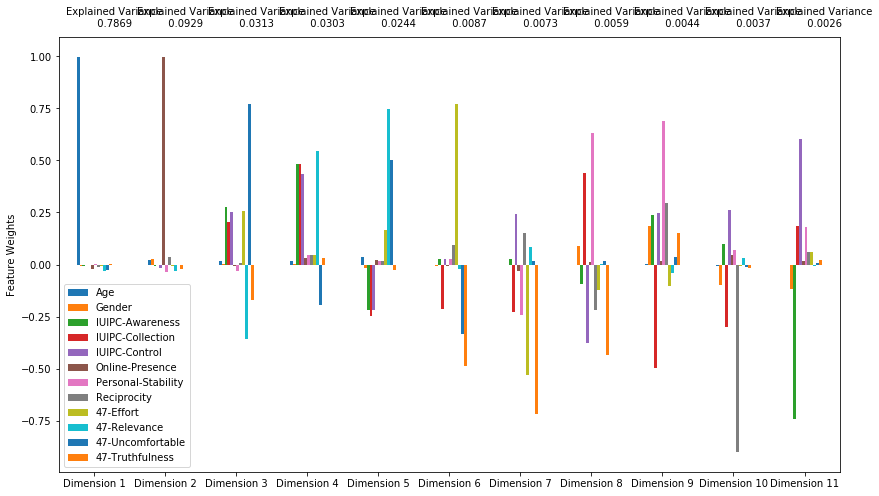

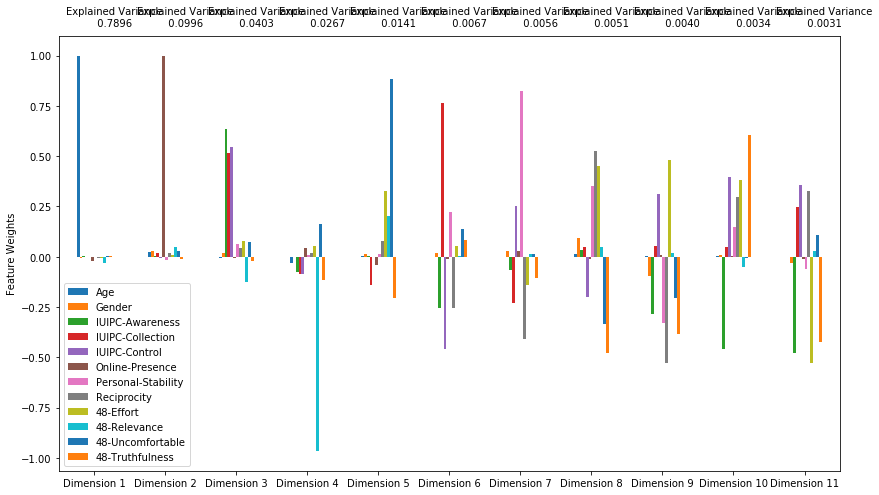

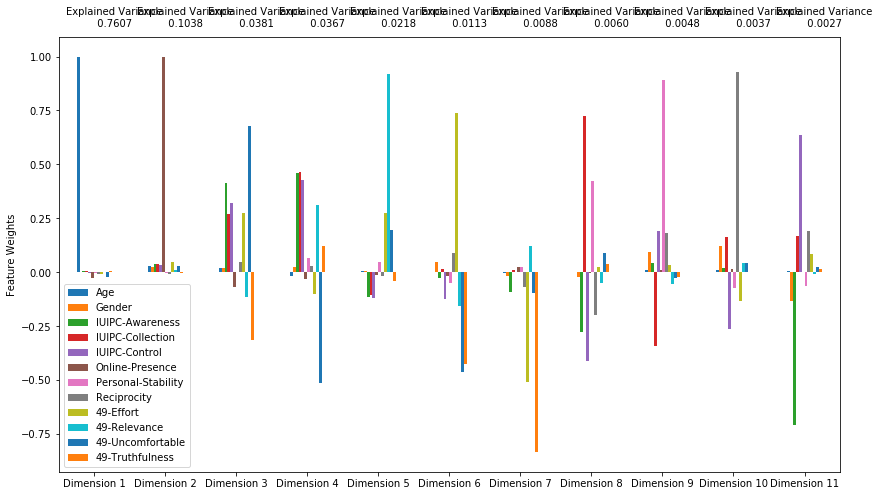

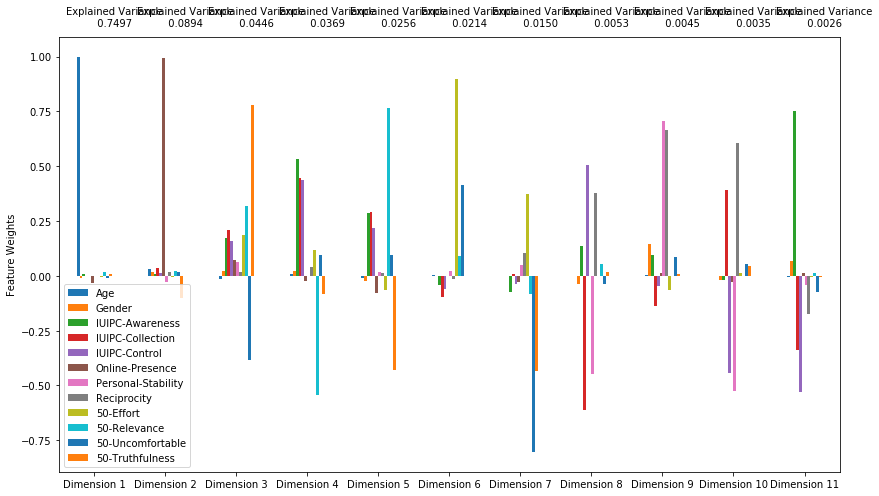

In [184]:
results = {}
for question_number in range(1, 51):
    columns = []
    columns.extend([str(question_number).zfill(2) + '-Effort',
                    str(question_number).zfill(2) + '-Relevance',
                    str(question_number).zfill(2) + '-Uncomfortable',
                    str(question_number).zfill(2) + '-Truthfulness'])
    relevant_indexes.extend(columns)

    
    cleaned_reordered_user_responses = pd.DataFrame(
        reordered_user_responses[relevant_indexes].dropna()).reset_index(drop = True)
#     display(cleaned_reordered_user_responses)
    
#     good_data = remove_outliers(cleaned_reordered_user_responses)
#     scaler, good_data = data_scale(cleaned_reordered_user_responses)
    good_data = cleaned_reordered_user_responses
    
    pca = PCA(n_components=11)
    pca.fit(good_data)
    
    results['Q' + str(question_number).zfill(2)] = rs.pca_results(good_data, pca)
    

    del relevant_indexes[8:]

In [185]:
for k, v in results.items():
#     display(v)
    display(v['Explained Variance'].cumsum())

Dimension 1     0.7518
Dimension 2     0.8382
Dimension 3     0.8960
Dimension 4     0.9276
Dimension 5     0.9535
Dimension 6     0.9722
Dimension 7     0.9820
Dimension 8     0.9876
Dimension 9     0.9918
Dimension 10    0.9958
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.8096
Dimension 2     0.9078
Dimension 3     0.9386
Dimension 4     0.9628
Dimension 5     0.9751
Dimension 6     0.9812
Dimension 7     0.9856
Dimension 8     0.9897
Dimension 9     0.9930
Dimension 10    0.9959
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7588
Dimension 2     0.8538
Dimension 3     0.9018
Dimension 4     0.9314
Dimension 5     0.9588
Dimension 6     0.9746
Dimension 7     0.9809
Dimension 8     0.9864
Dimension 9     0.9912
Dimension 10    0.9953
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Dimension 1     0.7327
Dimension 2     0.8288
Dimension 3     0.8844
Dimension 4     0.9248
Dimension 5     0.9496
Dimension 6     0.9711
Dimension 7     0.9788
Dimension 8     0.9852
Dimension 9     0.9908
Dimension 10    0.9955
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7876
Dimension 2     0.8943
Dimension 3     0.9302
Dimension 4     0.9583
Dimension 5     0.9707
Dimension 6     0.9769
Dimension 7     0.9828
Dimension 8     0.9875
Dimension 9     0.9918
Dimension 10    0.9958
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7681
Dimension 2     0.8657
Dimension 3     0.9036
Dimension 4     0.9352
Dimension 5     0.9641
Dimension 6     0.9749
Dimension 7     0.9812
Dimension 8     0.9867
Dimension 9     0.9917
Dimension 10    0.9959
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Dimension 1     0.7331
Dimension 2     0.8422
Dimension 3     0.8939
Dimension 4     0.9272
Dimension 5     0.9548
Dimension 6     0.9729
Dimension 7     0.9819
Dimension 8     0.9872
Dimension 9     0.9915
Dimension 10    0.9953
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7562
Dimension 2     0.8515
Dimension 3     0.8996
Dimension 4     0.9298
Dimension 5     0.9518
Dimension 6     0.9696
Dimension 7     0.9827
Dimension 8     0.9882
Dimension 9     0.9923
Dimension 10    0.9957
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Dimension 1     0.7459
Dimension 2     0.8588
Dimension 3     0.9123
Dimension 4     0.9408
Dimension 5     0.9618
Dimension 6     0.9727
Dimension 7     0.9798
Dimension 8     0.9863
Dimension 9     0.9915
Dimension 10    0.9954
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Dimension 1     0.7386
Dimension 2     0.8349
Dimension 3     0.8918
Dimension 4     0.9281
Dimension 5     0.9480
Dimension 6     0.9671
Dimension 7     0.9816
Dimension 8     0.9875
Dimension 9     0.9922
Dimension 10    0.9958
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7432
Dimension 2     0.8278
Dimension 3     0.8909
Dimension 4     0.9288
Dimension 5     0.9520
Dimension 6     0.9682
Dimension 7     0.9806
Dimension 8     0.9867
Dimension 9     0.9913
Dimension 10    0.9951
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7688
Dimension 2     0.8604
Dimension 3     0.9058
Dimension 4     0.9345
Dimension 5     0.9607
Dimension 6     0.9772
Dimension 7     0.9825
Dimension 8     0.9876
Dimension 9     0.9921
Dimension 10    0.9957
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Dimension 1     0.7207
Dimension 2     0.8296
Dimension 3     0.8822
Dimension 4     0.9158
Dimension 5     0.9454
Dimension 6     0.9682
Dimension 7     0.9811
Dimension 8     0.9876
Dimension 9     0.9917
Dimension 10    0.9957
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7329
Dimension 2     0.8384
Dimension 3     0.9039
Dimension 4     0.9326
Dimension 5     0.9560
Dimension 6     0.9707
Dimension 7     0.9809
Dimension 8     0.9873
Dimension 9     0.9915
Dimension 10    0.9952
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7739
Dimension 2     0.8508
Dimension 3     0.9022
Dimension 4     0.9311
Dimension 5     0.9535
Dimension 6     0.9702
Dimension 7     0.9837
Dimension 8     0.9885
Dimension 9     0.9922
Dimension 10    0.9957
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Dimension 1     0.7913
Dimension 2     0.8962
Dimension 3     0.9391
Dimension 4     0.9573
Dimension 5     0.9734
Dimension 6     0.9803
Dimension 7     0.9851
Dimension 8     0.9892
Dimension 9     0.9931
Dimension 10    0.9964
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7929
Dimension 2     0.9001
Dimension 3     0.9322
Dimension 4     0.9577
Dimension 5     0.9679
Dimension 6     0.9774
Dimension 7     0.9827
Dimension 8     0.9875
Dimension 9     0.9918
Dimension 10    0.9957
Dimension 11    0.9986
Name: Explained Variance, dtype: float64

Dimension 1     0.7964
Dimension 2     0.9037
Dimension 3     0.9387
Dimension 4     0.9597
Dimension 5     0.9725
Dimension 6     0.9788
Dimension 7     0.9838
Dimension 8     0.9882
Dimension 9     0.9923
Dimension 10    0.9956
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7709
Dimension 2     0.8850
Dimension 3     0.9226
Dimension 4     0.9534
Dimension 5     0.9659
Dimension 6     0.9736
Dimension 7     0.9802
Dimension 8     0.9862
Dimension 9     0.9914
Dimension 10    0.9955
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7840
Dimension 2     0.8829
Dimension 3     0.9263
Dimension 4     0.9491
Dimension 5     0.9690
Dimension 6     0.9756
Dimension 7     0.9820
Dimension 8     0.9871
Dimension 9     0.9915
Dimension 10    0.9955
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Dimension 1     0.7615
Dimension 2     0.8677
Dimension 3     0.9092
Dimension 4     0.9462
Dimension 5     0.9661
Dimension 6     0.9745
Dimension 7     0.9812
Dimension 8     0.9868
Dimension 9     0.9914
Dimension 10    0.9953
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7602
Dimension 2     0.8676
Dimension 3     0.9085
Dimension 4     0.9407
Dimension 5     0.9600
Dimension 6     0.9707
Dimension 7     0.9793
Dimension 8     0.9861
Dimension 9     0.9907
Dimension 10    0.9951
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Dimension 1     0.8189
Dimension 2     0.9106
Dimension 3     0.9391
Dimension 4     0.9666
Dimension 5     0.9760
Dimension 6     0.9819
Dimension 7     0.9863
Dimension 8     0.9903
Dimension 9     0.9939
Dimension 10    0.9962
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7772
Dimension 2     0.8705
Dimension 3     0.9093
Dimension 4     0.9438
Dimension 5     0.9601
Dimension 6     0.9733
Dimension 7     0.9799
Dimension 8     0.9860
Dimension 9     0.9907
Dimension 10    0.9949
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7968
Dimension 2     0.8986
Dimension 3     0.9392
Dimension 4     0.9572
Dimension 5     0.9718
Dimension 6     0.9786
Dimension 7     0.9842
Dimension 8     0.9890
Dimension 9     0.9931
Dimension 10    0.9960
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7215
Dimension 2     0.8276
Dimension 3     0.8794
Dimension 4     0.9148
Dimension 5     0.9442
Dimension 6     0.9631
Dimension 7     0.9790
Dimension 8     0.9855
Dimension 9     0.9909
Dimension 10    0.9954
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Dimension 1     0.8178
Dimension 2     0.9039
Dimension 3     0.9394
Dimension 4     0.9578
Dimension 5     0.9717
Dimension 6     0.9786
Dimension 7     0.9838
Dimension 8     0.9885
Dimension 9     0.9926
Dimension 10    0.9960
Dimension 11    0.9986
Name: Explained Variance, dtype: float64

Dimension 1     0.8057
Dimension 2     0.9122
Dimension 3     0.9468
Dimension 4     0.9637
Dimension 5     0.9718
Dimension 6     0.9784
Dimension 7     0.9838
Dimension 8     0.9884
Dimension 9     0.9924
Dimension 10    0.9955
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Dimension 1     0.7705
Dimension 2     0.8698
Dimension 3     0.9123
Dimension 4     0.9431
Dimension 5     0.9607
Dimension 6     0.9713
Dimension 7     0.9790
Dimension 8     0.9855
Dimension 9     0.9907
Dimension 10    0.9951
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7775
Dimension 2     0.8621
Dimension 3     0.9165
Dimension 4     0.9474
Dimension 5     0.9682
Dimension 6     0.9804
Dimension 7     0.9855
Dimension 8     0.9893
Dimension 9     0.9930
Dimension 10    0.9957
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7423
Dimension 2     0.8390
Dimension 3     0.8829
Dimension 4     0.9201
Dimension 5     0.9481
Dimension 6     0.9654
Dimension 7     0.9797
Dimension 8     0.9864
Dimension 9     0.9912
Dimension 10    0.9954
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7980
Dimension 2     0.8953
Dimension 3     0.9329
Dimension 4     0.9517
Dimension 5     0.9629
Dimension 6     0.9719
Dimension 7     0.9808
Dimension 8     0.9864
Dimension 9     0.9913
Dimension 10    0.9955
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7499
Dimension 2     0.8812
Dimension 3     0.9185
Dimension 4     0.9523
Dimension 5     0.9686
Dimension 6     0.9762
Dimension 7     0.9823
Dimension 8     0.9870
Dimension 9     0.9915
Dimension 10    0.9951
Dimension 11    0.9981
Name: Explained Variance, dtype: float64

Dimension 1     0.7838
Dimension 2     0.8808
Dimension 3     0.9112
Dimension 4     0.9396
Dimension 5     0.9634
Dimension 6     0.9734
Dimension 7     0.9816
Dimension 8     0.9874
Dimension 9     0.9920
Dimension 10    0.9956
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Dimension 1     0.7914
Dimension 2     0.8720
Dimension 3     0.9061
Dimension 4     0.9373
Dimension 5     0.9623
Dimension 6     0.9736
Dimension 7     0.9818
Dimension 8     0.9877
Dimension 9     0.9922
Dimension 10    0.9958
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.8243
Dimension 2     0.9050
Dimension 3     0.9346
Dimension 4     0.9545
Dimension 5     0.9673
Dimension 6     0.9773
Dimension 7     0.9843
Dimension 8     0.9894
Dimension 9     0.9932
Dimension 10    0.9966
Dimension 11    0.9988
Name: Explained Variance, dtype: float64

Dimension 1     0.7885
Dimension 2     0.8745
Dimension 3     0.9127
Dimension 4     0.9412
Dimension 5     0.9647
Dimension 6     0.9772
Dimension 7     0.9831
Dimension 8     0.9880
Dimension 9     0.9923
Dimension 10    0.9957
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Dimension 1     0.7866
Dimension 2     0.8941
Dimension 3     0.9287
Dimension 4     0.9551
Dimension 5     0.9700
Dimension 6     0.9768
Dimension 7     0.9831
Dimension 8     0.9881
Dimension 9     0.9923
Dimension 10    0.9956
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7616
Dimension 2     0.8696
Dimension 3     0.9030
Dimension 4     0.9311
Dimension 5     0.9516
Dimension 6     0.9685
Dimension 7     0.9828
Dimension 8     0.9878
Dimension 9     0.9925
Dimension 10    0.9957
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7973
Dimension 2     0.8898
Dimension 3     0.9209
Dimension 4     0.9474
Dimension 5     0.9688
Dimension 6     0.9784
Dimension 7     0.9848
Dimension 8     0.9897
Dimension 9     0.9935
Dimension 10    0.9967
Dimension 11    0.9987
Name: Explained Variance, dtype: float64

Dimension 1     0.7431
Dimension 2     0.8558
Dimension 3     0.8957
Dimension 4     0.9295
Dimension 5     0.9614
Dimension 6     0.9711
Dimension 7     0.9785
Dimension 8     0.9846
Dimension 9     0.9898
Dimension 10    0.9947
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Dimension 1     0.8088
Dimension 2     0.9061
Dimension 3     0.9356
Dimension 4     0.9571
Dimension 5     0.9727
Dimension 6     0.9789
Dimension 7     0.9848
Dimension 8     0.9893
Dimension 9     0.9927
Dimension 10    0.9959
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7766
Dimension 2     0.8775
Dimension 3     0.9113
Dimension 4     0.9427
Dimension 5     0.9590
Dimension 6     0.9730
Dimension 7     0.9814
Dimension 8     0.9871
Dimension 9     0.9915
Dimension 10    0.9955
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7642
Dimension 2     0.8793
Dimension 3     0.9157
Dimension 4     0.9415
Dimension 5     0.9639
Dimension 6     0.9743
Dimension 7     0.9809
Dimension 8     0.9861
Dimension 9     0.9909
Dimension 10    0.9949
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Dimension 1     0.7951
Dimension 2     0.8878
Dimension 3     0.9263
Dimension 4     0.9504
Dimension 5     0.9698
Dimension 6     0.9782
Dimension 7     0.9838
Dimension 8     0.9881
Dimension 9     0.9922
Dimension 10    0.9957
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7343
Dimension 2     0.8264
Dimension 3     0.8886
Dimension 4     0.9286
Dimension 5     0.9509
Dimension 6     0.9684
Dimension 7     0.9812
Dimension 8     0.9866
Dimension 9     0.9913
Dimension 10    0.9953
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Dimension 1     0.7869
Dimension 2     0.8798
Dimension 3     0.9111
Dimension 4     0.9414
Dimension 5     0.9658
Dimension 6     0.9745
Dimension 7     0.9818
Dimension 8     0.9877
Dimension 9     0.9921
Dimension 10    0.9958
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7896
Dimension 2     0.8892
Dimension 3     0.9295
Dimension 4     0.9562
Dimension 5     0.9703
Dimension 6     0.9770
Dimension 7     0.9826
Dimension 8     0.9877
Dimension 9     0.9917
Dimension 10    0.9951
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Dimension 1     0.7607
Dimension 2     0.8645
Dimension 3     0.9026
Dimension 4     0.9393
Dimension 5     0.9611
Dimension 6     0.9724
Dimension 7     0.9812
Dimension 8     0.9872
Dimension 9     0.9920
Dimension 10    0.9957
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Dimension 1     0.7497
Dimension 2     0.8391
Dimension 3     0.8837
Dimension 4     0.9206
Dimension 5     0.9462
Dimension 6     0.9676
Dimension 7     0.9826
Dimension 8     0.9879
Dimension 9     0.9924
Dimension 10    0.9959
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

In [186]:
# range_n_clusters = list(range(2,11))
# results = {}
# clusters = {}
# reduced_data_df = pd.DataFrame(columns=['Dimension 1', 'Dimension 2'])
# for question_number in range(1, 51):
#     print("Question No. is: ", 'Q' + str(question_number).zfill(2))
#     columns = []
#     columns.extend([str(question_number).zfill(2) + '-Effort',
#                     str(question_number).zfill(2) + '-Relevance',
#                     str(question_number).zfill(2) + '-Uncomfortable',
#                     str(question_number).zfill(2) + '-Truthfulness'])
#     relevant_indexes.extend(columns)
    
#     cleaned_reordered_user_responses = pd.DataFrame(
#         reordered_user_responses[relevant_indexes].dropna()).reset_index(drop = True)
    
#     good_data = remove_outliers(cleaned_reordered_user_responses)
#     scaler, good_data = data_scale(good_data)
    
# #     transformed_train_x_question = cleaned_reordered_user_responses
    
#     pca = PCA(n_components=2)
#     pca.fit(good_data)
#     reduced_data = pca.transform(good_data)
    
# #     results['Q' + str(question_number).zfill(2)] = rs.pca_results(good_data, pca)
# #     pca_results = rs.pca_results(transformed_train_x_question, pca) 
    
#     temp_df = pd.DataFrame(reduced_data, columns=['Dimension 1', 'Dimension 2'])
    
#     reduced_data_df = reduced_data_df.append(temp_df)
    
# #     results['Q' + str(question_number).zfill(2)] = rs.pca_results(transformed_train_x_question, pca)
# #     pca_results = rs.pca_results(transformed_train_x_question, pca)

    
#     for n_clusters in range_n_clusters:
#         # TODO: Apply your clustering algorithm of choice to the reduced data 
#         clusterer = GMM(n_components=n_clusters).fit(reduced_data)

#         # TODO: Predict the cluster for each data point
#         preds = clusterer.predict(reduced_data)

#         # TODO: Find the cluster centers
#         centers = clusterer.means_

#         # TODO: Predict the cluster for each transformed sample data point
# #         test_preds = clusterer.predict(pca_test)

#         # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
#         score = silhouette_score(reduced_data, preds, metric='mahalanobis')
#         print("For n_clusters = {}. The average silhouette_score with GMM is : {}".format(n_clusters, score))
        
        
    
#     del relevant_indexes[8:]

Question No. is:  Q01
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5619812772791587
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.44237572395653074
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.4008098908888438
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.3943620271884682
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.3645619349844044
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.36556378690329194
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.37473207364846967
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3851312667013097
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3780784850275939


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  34.0     2.0              2.0               2.0            2.0   
Segment 1  52.0     1.0              2.0               3.0            2.0   
Segment 2  23.0     2.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  01-Effort  \
Segment 0              6.0                 4.0          4.0        2.0   
Segment 1              5.0                 4.0          4.0        2.0   
Segment 2              7.0                 4.0          4.0        2.0   

           01-Relevance  01-Uncomfortable  01-Truthfulness  
Segment 0           2.0               4.0              5.0  
Segment 1           3.0               4.0              6.0  
Segment 2           2.0               4.0              5.0

Question No. is:  Q02
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5782364716400884
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4508398415620713
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.40546293883695
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.40569821493475566
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.3823776474232452
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3909364208088944
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3971398953192181
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3844544202729152
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.37584579972629195


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  24.0     2.0              2.0               2.0            2.0   
Segment 1  36.0     2.0              2.0               2.0            2.0   
Segment 2  53.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  02-Effort  \
Segment 0              8.0                 4.0          4.0        1.0   
Segment 1              6.0                 4.0          4.0        1.0   
Segment 2              6.0                 4.0          4.0        1.0   

           02-Relevance  02-Uncomfortable  02-Truthfulness  
Segment 0           3.0               1.0              7.0  
Segment 1           3.0               2.0              7.0  
Segment 2           3.0               2.0              7.0

Question No. is:  Q03
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.6039154842206571
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4277784698367232
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.3742074529954016
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.3979325251722431
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.3715521129961937
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3703452863744653
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.37181608641956754
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.37682739575849494
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3698256653789081


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  24.0     2.0              2.0               2.0            2.0   
Segment 1  51.0     1.0              2.0               2.0            2.0   
Segment 2  34.0     2.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  03-Effort  \
Segment 0              7.0                 4.0          4.0        1.0   
Segment 1              5.0                 4.0          4.0        1.0   
Segment 2              6.0                 4.0          4.0        1.0   

           03-Relevance  03-Uncomfortable  03-Truthfulness  
Segment 0           3.0               3.0              6.0  
Segment 1           3.0               3.0              6.0  
Segment 2           3.0               3.0              6.0

Question No. is:  Q04
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5395785346414298
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4207767687021444
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.3673892716540441
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.38383295443739157
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.38214819884343915
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.38320702234367443
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.37458952171731735
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3811329903304801
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3681106230487418


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  49.0     1.0              2.0               2.0            2.0   
Segment 1  24.0     2.0              2.0               2.0            2.0   
Segment 2  34.0     2.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  04-Effort  \
Segment 0              6.0                 4.0          4.0        2.0   
Segment 1              7.0                 4.0          4.0        2.0   
Segment 2              7.0                 4.0          4.0        2.0   

           04-Relevance  04-Uncomfortable  04-Truthfulness  
Segment 0           1.0               6.0              3.0  
Segment 1           1.0               6.0              3.0  
Segment 2           1.0               6.0              3.0

Question No. is:  Q05
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5750464980118714
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.46392965364959754
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.3784764585203785
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.38049672071071705
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.4032164499838277
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3625312233575798
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.36203424674870294
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.35429428487407727
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3634938947722798


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  40.0     2.0              2.0               2.0            2.0   
Segment 1  26.0     2.0              2.0               2.0            2.0   
Segment 2  62.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  05-Effort  \
Segment 0              6.0                 4.0          4.0        1.0   
Segment 1              7.0                 4.0          4.0        1.0   
Segment 2              6.0                 4.0          4.0        1.0   

           05-Relevance  05-Uncomfortable  05-Truthfulness  
Segment 0           4.0               2.0              7.0  
Segment 1           4.0               2.0              7.0  
Segment 2           3.0               1.0              7.0

Question No. is:  Q06
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5692052826225098
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.444245825932059
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.3815771995258428
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.39300078626622087
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.3750355147331828
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3796905983546254
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.37517999932457086
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3597148412898234
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.37142394783722105


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  35.0     1.0              2.0               2.0            2.0   
Segment 1  24.0     2.0              2.0               2.0            2.0   
Segment 2  53.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  06-Effort  \
Segment 0              6.0                 4.0          4.0        1.0   
Segment 1              7.0                 4.0          4.0        1.0   
Segment 2              5.0                 4.0          4.0        1.0   

           06-Relevance  06-Uncomfortable  06-Truthfulness  
Segment 0           4.0               2.0              6.0  
Segment 1           4.0               3.0              6.0  
Segment 2           4.0               2.0              6.0

Question No. is:  Q07
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5943182224851267
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.416452141091607
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.40312291782140525
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.406536849486797
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.3674944613765661
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.37465716526861115
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.35990605790282737
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3708996585381135
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.375685875017631


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  23.0     2.0              2.0               2.0            2.0   
Segment 1  32.0     2.0              2.0               2.0            2.0   
Segment 2  51.0     1.0              2.0               3.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  07-Effort  \
Segment 0              8.0                 4.0          4.0        2.0   
Segment 1              6.0                 4.0          4.0        2.0   
Segment 2              6.0                 4.0          4.0        2.0   

           07-Relevance  07-Uncomfortable  07-Truthfulness  
Segment 0           3.0               4.0              5.0  
Segment 1           3.0               4.0              6.0  
Segment 2           4.0               3.0              6.0

Question No. is:  Q08
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5739021048806104
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.47479270180368793
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.43716609331083595
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.3838910168798903
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.38543764481337933
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3805006221867441
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3834508393377156
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3867648200196233
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3822904491756659


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  37.0     2.0              2.0               2.0            2.0   
Segment 1  24.0     2.0              2.0               2.0            2.0   
Segment 2  58.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  08-Effort  \
Segment 0              7.0                 4.0          4.0        2.0   
Segment 1              7.0                 4.0          4.0        2.0   
Segment 2              7.0                 4.0          4.0        2.0   

           08-Relevance  08-Uncomfortable  08-Truthfulness  
Segment 0           2.0               5.0              4.0  
Segment 1           2.0               6.0              4.0  
Segment 2           3.0               5.0              4.0

Question No. is:  Q09
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5921373169692602
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4245499102079869
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.3766298536987921
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.39531954548800724
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.39914745562407966
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3694788526394206
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3801173089570548
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3645627852432847
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3713722466181084


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  34.0     2.0              2.0               2.0            2.0   
Segment 1  24.0     2.0              2.0               2.0            2.0   
Segment 2  52.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  09-Effort  \
Segment 0              6.0                 4.0          4.0        2.0   
Segment 1              7.0                 4.0          4.0        2.0   
Segment 2              5.0                 4.0          4.0        2.0   

           09-Relevance  09-Uncomfortable  09-Truthfulness  
Segment 0           1.0               3.0              6.0  
Segment 1           1.0               3.0              6.0  
Segment 2           1.0               3.0              6.0

Question No. is:  Q10
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5747752251462366
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.42489294501359254
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.378938066628971
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.39182011407611844
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.3739261922993402
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3816911553393984
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3950823501105338
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.4003171602754518
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.40825787480742437


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  24.0     2.0              2.0               2.0            2.0   
Segment 1  54.0     1.0              2.0               2.0            3.0   
Segment 2  36.0     2.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  10-Effort  \
Segment 0              7.0                 4.0          4.0        2.0   
Segment 1              5.0                 4.0          4.0        2.0   
Segment 2              7.0                 4.0          4.0        2.0   

           10-Relevance  10-Uncomfortable  10-Truthfulness  
Segment 0           2.0               4.0              5.0  
Segment 1           2.0               3.0              6.0  
Segment 2           2.0               3.0              5.0

Question No. is:  Q11
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5785816021523732
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4526165297530989
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.417955408145034
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.3999925559735716
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.3894122121374745
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.40383622555401577
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3889704660311494
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.37403394283187663
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3829848655811853


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  24.0     2.0              2.0               2.0            2.0   
Segment 1  36.0     2.0              2.0               2.0            2.0   
Segment 2  53.0     1.0              2.0               3.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  11-Effort  \
Segment 0              8.0                 4.0          4.0        2.0   
Segment 1              6.0                 4.0          4.0        2.0   
Segment 2              5.0                 4.0          4.0        2.0   

           11-Relevance  11-Uncomfortable  11-Truthfulness  
Segment 0           2.0               5.0              5.0  
Segment 1           2.0               4.0              5.0  
Segment 2           2.0               4.0              5.0

Question No. is:  Q12
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5809355267460762
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4558444093346701
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.3909693328679705
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.3949519224667796
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.4023225415211375
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.37463146197031866
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.36881790529147723
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3712105075148999
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.38298320586245094


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  57.0     1.0              2.0               2.0            3.0   
Segment 1  24.0     2.0              2.0               2.0            2.0   
Segment 2  37.0     2.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  12-Effort  \
Segment 0              6.0                 4.0          4.0        2.0   
Segment 1              7.0                 4.0          4.0        3.0   
Segment 2              6.0                 4.0          4.0        3.0   

           12-Relevance  12-Uncomfortable  12-Truthfulness  
Segment 0           2.0               6.0              2.0  
Segment 1           1.0               6.0              3.0  
Segment 2           1.0               6.0              3.0

Question No. is:  Q13
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.558558262471099
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4319961586416061
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.37890477136647177
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.3782011961838483
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.3811037643339588
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3878811634047475
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3853524921662009
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.38199672256380174
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3831154552448516


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  25.0     2.0              2.0               2.0            2.0   
Segment 1  57.0     1.0              2.0               2.0            2.0   
Segment 2  37.0     2.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  13-Effort  \
Segment 0              7.0                 4.0          4.0        2.0   
Segment 1              6.0                 4.0          4.0        2.0   
Segment 2              7.0                 4.0          4.0        2.0   

           13-Relevance  13-Uncomfortable  13-Truthfulness  
Segment 0           3.0               5.0              4.0  
Segment 1           4.0               4.0              4.0  
Segment 2           3.0               4.0              4.0

Question No. is:  Q14
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5859466734073373
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4290015659584813
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.3982939271044755
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.39530170250122426
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.38410979742341556
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.38331597344765267
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.39370185645014194
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.36229111609209347
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3654260726562099


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  35.0     1.0              2.0               2.0            2.0   
Segment 1  24.0     2.0              2.0               2.0            2.0   
Segment 2  52.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  14-Effort  \
Segment 0              6.0                 4.0          4.0        2.0   
Segment 1              7.0                 4.0          4.0        2.0   
Segment 2              6.0                 4.0          4.0        2.0   

           14-Relevance  14-Uncomfortable  14-Truthfulness  
Segment 0           2.0               5.0              4.0  
Segment 1           2.0               5.0              4.0  
Segment 2           2.0               4.0              4.0

Question No. is:  Q15
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5874528423237154
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4853757922107407
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.38246216052233395
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.36370132595743143
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.38119884415251126
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.36621795225572146
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3864559920259416
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.39217342440815994
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.35766925288640955


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  25.0     2.0              2.0               2.0            2.0   
Segment 1  38.0     1.0              2.0               2.0            2.0   
Segment 2  56.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  15-Effort  \
Segment 0              7.0                 4.0          4.0        2.0   
Segment 1              6.0                 4.0          4.0        2.0   
Segment 2              5.0                 4.0          4.0        2.0   

           15-Relevance  15-Uncomfortable  15-Truthfulness  
Segment 0           2.0               5.0              3.0  
Segment 1           2.0               5.0              4.0  
Segment 2           2.0               5.0              4.0

Question No. is:  Q16
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5603916850777375
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.450434646445188
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.38332569502579117
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.39568419504036
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.40793689362821517
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3716538391940736
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.38694966140274767
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.38699702890774407
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3783474080850951


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  24.0     2.0              2.0               2.0            2.0   
Segment 1  53.0     1.0              2.0               2.0            2.0   
Segment 2  35.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  16-Effort  \
Segment 0              7.0                 4.0          4.0        1.0   
Segment 1              6.0                 4.0          4.0        1.0   
Segment 2              6.0                 4.0          4.0        1.0   

           16-Relevance  16-Uncomfortable  16-Truthfulness  
Segment 0           2.0               2.0              7.0  
Segment 1           2.0               2.0              7.0  
Segment 2           2.0               2.0              7.0

Question No. is:  Q17
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.592094240700011
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.44618416753479345
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.37951593793521116
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.40237565416860516
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.3647601348682102
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3732990209675223
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3719932526882876
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3719200387737358
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3861833414404498


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  24.0     2.0              2.0               2.0            2.0   
Segment 1  35.0     2.0              2.0               2.0            2.0   
Segment 2  56.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  17-Effort  \
Segment 0              7.0                 4.0          4.0        2.0   
Segment 1              6.0                 4.0          4.0        2.0   
Segment 2              7.0                 4.0          4.0        1.0   

           17-Relevance  17-Uncomfortable  17-Truthfulness  
Segment 0           2.0               2.0              6.0  
Segment 1           2.0               2.0              7.0  
Segment 2           1.0               2.0              7.0

Question No. is:  Q18
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5568138521438883
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4517261501460427
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.4532830851926765
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.38137576560776154
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.39110633205546924
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3608306373177337
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3697511558167774
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.37452294788760665
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.37489394784997737


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  35.0     1.0              2.0               2.0            2.0   
Segment 1  24.0     2.0              2.0               2.0            2.0   
Segment 2  53.0     1.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  18-Effort  \
Segment 0              5.0                 4.0          4.0        1.0   
Segment 1              7.0                 4.0          4.0        1.0   
Segment 2              6.0                 4.0          4.0        1.0   

           18-Relevance  18-Uncomfortable  18-Truthfulness  
Segment 0           2.0               2.0              7.0  
Segment 1           2.0               2.0              7.0  
Segment 2           1.0               2.0              7.0

Question No. is:  Q19
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5737106388624149
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.44558006747546164
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.36894888394006253
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.3965100799896535
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.368359136846565
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.3753222329933404
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3773477442791954
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.378649394215978
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3769816615532973


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  24.0     2.0              2.0               2.0            2.0   
Segment 1  56.0     1.0              2.0               3.0            2.0   
Segment 2  36.0     2.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  19-Effort  \
Segment 0              7.0                 4.0          4.0        1.0   
Segment 1              5.0                 4.0          4.0        1.0   
Segment 2              6.0                 4.0          4.0        1.0   

           19-Relevance  19-Uncomfortable  19-Truthfulness  
Segment 0           2.0               3.0              7.0  
Segment 1           1.0               2.0              6.0  
Segment 2           2.0               3.0              7.0

Question No. is:  Q20
For n_clusters = 2. The average silhouette_score with Kmeans is : 0.5749983165373714
For n_clusters = 3. The average silhouette_score with Kmeans is : 0.4584007711417868
For n_clusters = 4. The average silhouette_score with Kmeans is : 0.35802936972362487
For n_clusters = 5. The average silhouette_score with Kmeans is : 0.3742017729810969
For n_clusters = 6. The average silhouette_score with Kmeans is : 0.36546388215217557
For n_clusters = 7. The average silhouette_score with Kmeans is : 0.36931619874154425
For n_clusters = 8. The average silhouette_score with Kmeans is : 0.3498818400920063
For n_clusters = 9. The average silhouette_score with Kmeans is : 0.3590440391621043
For n_clusters = 10. The average silhouette_score with Kmeans is : 0.3618864833692689


Age  Gender  IUIPC-Awareness  IUIPC-Collection  IUIPC-Control  \
Segment 0  55.0     1.0              2.0               2.0            2.0   
Segment 1  25.0     2.0              2.0               2.0            2.0   
Segment 2  37.0     2.0              2.0               2.0            2.0   

           Online-Presence  Personal-Stability  Reciprocity  20-Effort  \
Segment 0              5.0                 4.0          4.0        1.0   
Segment 1              7.0                 4.0          4.0        1.0   
Segment 2              6.0                 4.0          4.0        1.0   

           20-Relevance  20-Uncomfortable  20-Truthfulness  
Segment 0           2.0               2.0              7.0  
Segment 1           3.0               2.0              7.0  
Segment 2           2.0               2.0              7.0

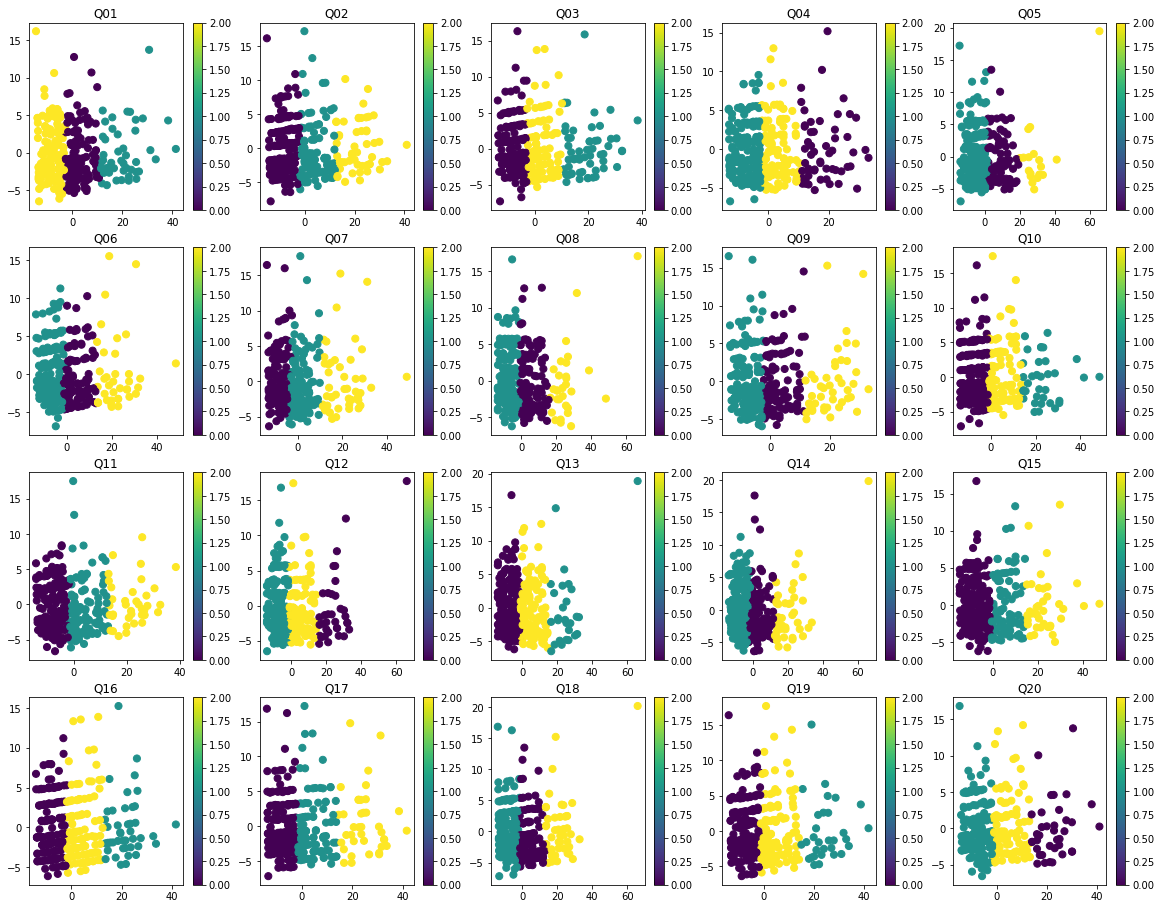

In [188]:
range_n_clusters = list(range(2,11))
results = {}
clusters = {}
fig = plt.figure(figsize=(20, 20))

reduced_data_df = pd.DataFrame(columns=['Dimension 1', 'Dimension 2'])
for question_number in range(1, 21):
    print("Question No. is: ", 'Q' + str(question_number).zfill(2))
    columns = []
    columns.extend([str(question_number).zfill(2) + '-Effort',
                    str(question_number).zfill(2) + '-Relevance',
                    str(question_number).zfill(2) + '-Uncomfortable',
                    str(question_number).zfill(2) + '-Truthfulness'])
    relevant_indexes.extend(columns)
    
    cleaned_reordered_user_responses = pd.DataFrame(
        reordered_user_responses[relevant_indexes].dropna()).reset_index(drop = True)
    
#     good_data = remove_outliers(cleaned_reordered_user_responses)
    
#     scaler, good_data = data_scale(cleaned_reordered_user_responses)

    good_data = cleaned_reordered_user_responses
    
#     transformed_train_x_question = cleaned_reordered_user_responses
    
    pca = PCA(n_components=2)
    pca.fit(good_data)
    reduced_data = pca.transform(good_data)
    
#     pca_test = pca.transform(transformed_test_x_question)
    
#     results['Q' + str(question_number).zfill(2)] = rs.pca_results(good_data, pca)
#     pca_results = rs.pca_results(transformed_train_x_question, pca) 
    
    temp_df = pd.DataFrame(reduced_data, columns=['Dimension 1', 'Dimension 2'])
    
    reduced_data_df = reduced_data_df.append(temp_df)
    
#     results['Q' + str(question_number).zfill(2)] = rs.pca_results(transformed_train_x_question, pca)
#     pca_results = rs.pca_results(transformed_train_x_question, pca)
    
    max_score = -99
    optimal_clusters = 0
    for n_clusters in range_n_clusters:
        # TODO: Apply your clustering algorithm of choice to the reduced data 
        clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)

        # TODO: Predict the cluster for each data point
        preds = clusterer.predict(reduced_data)

        # TODO: Find the cluster centers
        centers = clusterer.cluster_centers_

        # TODO: Predict the cluster for each transformed sample data point
#         test_preds = clusterer.predict(pca_test)

        # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
        score = silhouette_score(reduced_data, preds, metric='euclidean')
        print("For n_clusters = {}. The average silhouette_score with Kmeans is : {}".format(n_clusters, score))
        if score > max_score:
            max_score = score
            optimal_clusters = n_clusters
            
    clusters['Q' + str(question_number).zfill(2)] = optimal_clusters
    
    clusterer = KMeans(n_clusters=3).fit(reduced_data)

    # TODO: Predict the cluster for each data point
    preds = pd.DataFrame(clusterer.predict(reduced_data))
#     display(preds)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_
#     print(centers)
    

    ax = fig.add_subplot(5, 5, question_number)
    scatter = ax.scatter(
        temp_df['Dimension 1'], temp_df['Dimension 2'],
        c=preds[0], s=50)
    ax.set_title('Q' + str(question_number).zfill(2))
#     ax.set_xlabel('GDP per Capita')
#     ax.set_ylabel('Corruption')
    plt.colorbar(scatter)

    # TODO: Predict the cluster for each transformed sample data point
#     test_preds = clusterer.predict(pca_test)
    
    # Display the results of the clustering from implementation
#     rs.cluster_results(reduced_data, preds, centers, pca_test)

    log_centers = pca.inverse_transform(centers)

#     # TODO: Exponentiate the centers
#     true_centers = data_inverse_scale(scaler, log_centers)
    
    true_centers = log_centers

    # Display the true centers
    segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
    true_centers = pd.DataFrame(np.round(true_centers), columns = cleaned_reordered_user_responses.columns)
    true_centers.index = segments
    display(true_centers)
    
    del relevant_indexes[8:]

Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '01-Effort':
Data points considered outliers for the feature '01-Relevance':
Data points considered outliers for the feature '01-Uncomfortable':
Data points considered outliers for the feature '01-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 2, 3, 6, 7, 9, 14, 15, 17, 18, 22, 23, 24, 30, 31, 32, 33, 34, 36, 40, 41, 45, 46, 47, 49, 50, 55, 58, 60, 62, 64, 66, 68, 70, 77, 81, 83, 84, 88, 89, 92, 93, 96, 97, 99, 101, 103, 107, 111

Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '06-Effort':
Data points considered outliers for the feature '06-Relevance':
Data points considered outliers for the feature '06-Uncomfortable':
Data points considered outliers for the feature '06-Truthfulness':
outside LOOP.....
Outliers list:
 [6, 8, 9, 14, 15, 17, 21, 22, 24, 26, 31, 34, 35, 36, 39, 43, 44, 47, 50, 54, 56, 57, 59, 63, 66, 67, 72, 74, 75, 79, 80, 81, 82, 85, 86, 87, 90, 92, 93, 94, 96, 101, 102, 103, 104, 106, 107, 1

Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '11-Effort':
Data points considered outliers for the feature '11-Relevance':
Data points considered outliers for the feature '11-Uncomfortable':
Data points considered outliers for the feature '11-Truthfulness':
outside LOOP.....
Outliers list:
 [7, 9, 14, 16, 18, 19, 26, 27, 30, 34, 35, 38, 40, 42, 43, 45, 47, 49, 50, 51, 52, 60, 62, 63, 70, 74, 76, 82, 87, 93, 94, 99, 131, 133, 134, 136, 139, 144, 150, 151, 156, 159, 161, 162, 166, 1

Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '17-Effort':
Data points considered outliers for the feature '17-Relevance':
Data points considered outliers for the feature '17-Uncomfortable':
Data points considered outliers for the feature '17-Truthfulness':
outside LOOP.....
Outliers list:
 [3, 4, 5, 6, 12, 15, 19, 20, 21, 24, 25, 26, 28, 35, 36, 38, 41, 46, 52, 54, 58, 61, 64, 65, 66, 67, 74, 77, 78, 80, 86, 87, 92, 93, 94, 95, 96, 99, 103, 104, 106, 108, 113, 115, 116, 118, 126,

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '22-Effort':
Data points considered outliers for the feature '22-Relevance':
Data points considered outliers for the feature '22-Uncomfortable':
Data points considered outliers for the feature '22-Truthfulness':
outside LOOP.....
Outliers list:
 [1, 3, 6, 7, 9, 10, 12, 13, 14, 18, 22, 23, 24, 30, 32, 34, 35, 39, 41, 44, 53, 54, 55, 56, 57, 59, 63, 64, 65, 67, 68, 69, 76, 78, 81, 82, 84, 86, 88, 92, 97, 99, 102, 105, 107, 110, 111, 114,

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '23-Effort':
Data points considered outliers for the feature '23-Relevance':
Data points considered outliers for the feature '23-Uncomfortable':
Data points considered outliers for the feature '23-Truthfulness':
outside LOOP.....
Outliers list:
 [6, 7, 8, 12, 16, 19, 20, 25, 27, 28, 34, 36, 37, 44, 45, 47, 50, 51, 52, 57, 60, 61, 62, 64, 70, 71, 75, 81, 82, 85, 91, 92, 93, 94, 95, 98, 103, 108, 109, 110, 112, 114, 117, 120, 123, 125, 1

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '24-Effort':
Data points considered outliers for the feature '24-Relevance':
Data points considered outliers for the feature '24-Uncomfortable':
Data points considered outliers for the feature '24-Truthfulness':
outside LOOP.....
Outliers list:
 [2, 4, 5, 7, 9, 10, 11, 14, 15, 16, 23, 24, 27, 31, 36, 38, 39, 41, 44, 47, 48, 49, 51, 55, 56, 58, 59, 61, 62, 63, 68, 69, 70, 73, 74, 80, 81, 84, 85, 87, 91, 92, 96, 97, 101, 102, 104, 106, 1

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '25-Effort':
Data points considered outliers for the feature '25-Relevance':
Data points considered outliers for the feature '25-Uncomfortable':
Data points considered outliers for the feature '25-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 4, 6, 7, 8, 9, 13, 15, 16, 25, 26, 27, 28, 29, 34, 35, 36, 38, 43, 45, 46, 47, 51, 53, 54, 56, 57, 58, 60, 63, 64, 66, 67, 68, 69, 74, 77, 78, 82, 85, 87, 88, 89, 94, 100, 101, 102, 103, 10

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '26-Effort':
Data points considered outliers for the feature '26-Relevance':
Data points considered outliers for the feature '26-Uncomfortable':
Data points considered outliers for the feature '26-Truthfulness':
outside LOOP.....
Outliers list:
 [5, 6, 7, 9, 20, 21, 25, 29, 35, 43, 49, 56, 58, 64, 81, 87, 90, 92, 94, 95, 101, 102, 103, 104, 107, 111, 113, 119, 121, 127, 128, 129, 134, 135, 137, 138, 139, 140, 149, 150, 151, 155, 156, 1

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '27-Effort':
Data points considered outliers for the feature '27-Relevance':
Data points considered outliers for the feature '27-Uncomfortable':
Data points considered outliers for the feature '27-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 1, 3, 4, 5, 7, 8, 12, 13, 15, 17, 22, 23, 24, 25, 26, 27, 30, 31, 35, 36, 42, 43, 46, 48, 49, 50, 56, 61, 63, 65, 66, 67, 68, 70, 72, 75, 77, 79, 81, 82, 84, 85, 88, 89, 92, 93, 97, 99, 101

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '28-Effort':
Data points considered outliers for the feature '28-Relevance':
Data points considered outliers for the feature '28-Uncomfortable':
Data points considered outliers for the feature '28-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 20, 21, 22, 26, 27, 28, 35, 36, 37, 38, 40, 42, 43, 45, 47, 48, 49, 57, 60, 62, 63, 68, 70, 71, 74, 75, 76, 77, 79, 80, 83, 90, 93, 94, 98, 99, 

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '29-Effort':
Data points considered outliers for the feature '29-Relevance':
Data points considered outliers for the feature '29-Uncomfortable':
Data points considered outliers for the feature '29-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 5, 7, 8, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 38, 41, 43, 47, 49, 51, 52, 54, 58, 60, 61, 62, 64, 69, 71, 72, 74, 75, 80, 83, 86, 89, 90, 93, 94, 95, 97, 98, 101, 102

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '30-Effort':
Data points considered outliers for the feature '30-Relevance':
Data points considered outliers for the feature '30-Uncomfortable':
Data points considered outliers for the feature '30-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 1, 3, 4, 7, 8, 10, 11, 17, 18, 22, 23, 29, 32, 36, 37, 38, 41, 44, 46, 54, 60, 64, 65, 66, 67, 69, 70, 71, 76, 78, 80, 84, 90, 95, 97, 98, 102, 103, 104, 106, 108, 109, 112, 113, 114, 116, 117, 118, 122, 128, 142, 147, 148, 154, 155, 160, 161, 167, 172, 173, 177, 178, 179, 180, 181, 183, 184, 188, 190, 192, 205, 208, 211, 214, 216, 217, 222, 223, 225, 228, 231, 233, 235, 238, 239, 241, 243, 249, 255, 256, 258, 263, 269, 270, 273, 274, 275, 276, 289, 291, 294, 295, 304, 306, 310, 312, 317, 320, 323

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '31-Effort':
Data points considered outliers for the feature '31-Relevance':
Data points considered outliers for the feature '31-Uncomfortable':
Data points considered outliers for the feature '31-Truthfulness':
outside LOOP.....
Outliers list:
 [5, 9, 12, 13, 14, 25, 26, 27, 28, 29, 37, 38, 45, 51, 52, 58, 59, 62, 64, 65, 67, 70, 74, 75, 76, 79, 87, 91, 92, 103, 104, 106, 107, 110, 111, 116, 119, 120, 124, 135, 139, 145, 146, 148, 150

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '32-Effort':
Data points considered outliers for the feature '32-Relevance':
Data points considered outliers for the feature '32-Uncomfortable':
Data points considered outliers for the feature '32-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 1, 3, 6, 7, 8, 10, 12, 15, 19, 21, 22, 23, 24, 25, 26, 27, 30, 31, 35, 39, 41, 42, 45, 46, 48, 49, 50, 51, 52, 54, 55, 56, 57, 59, 62, 67, 69, 74, 76, 79, 81, 85, 87, 88, 89, 90, 92, 93, 94

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '33-Effort':
Data points considered outliers for the feature '33-Relevance':
Data points considered outliers for the feature '33-Uncomfortable':
Data points considered outliers for the feature '33-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 3, 5, 6, 7, 8, 10, 13, 17, 18, 23, 25, 28, 29, 30, 33, 36, 38, 45, 47, 48, 53, 55, 56, 58, 61, 62, 65, 66, 69, 70, 72, 73, 75, 78, 84, 90, 91, 92, 93, 98, 100, 101, 102, 105, 107, 108, 112,

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '34-Effort':
Data points considered outliers for the feature '34-Relevance':
Data points considered outliers for the feature '34-Uncomfortable':
Data points considered outliers for the feature '34-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 4, 5, 11, 13, 14, 15, 20, 23, 24, 25, 33, 34, 35, 36, 38, 44, 46, 49, 50, 54, 57, 61, 62, 65, 67, 68, 69, 72, 73, 74, 76, 77, 79, 81, 82, 88, 96, 97, 101, 102, 103, 104, 106, 108, 110, 112,

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '35-Effort':
Data points considered outliers for the feature '35-Relevance':
Data points considered outliers for the feature '35-Uncomfortable':
Data points considered outliers for the feature '35-Truthfulness':
outside LOOP.....
Outliers list:
 [1, 3, 6, 7, 8, 9, 16, 21, 25, 26, 27, 28, 36, 37, 38, 40, 43, 44, 48, 49, 50, 51, 52, 58, 59, 60, 64, 65, 66, 68, 70, 74, 75, 81, 85, 98, 99, 103, 106, 107, 117, 120, 123, 124, 127, 131, 132, 

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '36-Effort':
Data points considered outliers for the feature '36-Relevance':
Data points considered outliers for the feature '36-Uncomfortable':
Data points considered outliers for the feature '36-Truthfulness':
outside LOOP.....
Outliers list:
 [2, 4, 5, 6, 11, 12, 13, 14, 18, 19, 20, 21, 22, 25, 32, 33, 41, 43, 50, 55, 57, 59, 61, 62, 67, 70, 71, 75, 77, 85, 87, 88, 90, 91, 92, 94, 95, 96, 97, 98, 104, 105, 106, 109, 110, 112, 117, 1

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '37-Effort':
Data points considered outliers for the feature '37-Relevance':
Data points considered outliers for the feature '37-Uncomfortable':
Data points considered outliers for the feature '37-Truthfulness':
outside LOOP.....
Outliers list:
 [1, 2, 4, 5, 6, 7, 10, 12, 13, 15, 16, 26, 27, 28, 29, 30, 35, 37, 39, 40, 42, 43, 45, 48, 51, 52, 55, 58, 61, 62, 63, 66, 67, 69, 70, 71, 72, 73, 74, 77, 78, 79, 86, 88, 92, 93, 94, 101, 103, 

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '38-Effort':
Data points considered outliers for the feature '38-Relevance':
Data points considered outliers for the feature '38-Uncomfortable':
Data points considered outliers for the feature '38-Truthfulness':
outside LOOP.....
Outliers list:
 [7, 12, 14, 18, 19, 20, 21, 23, 26, 29, 31, 32, 37, 41, 44, 49, 52, 54, 56, 58, 59, 61, 63, 68, 70, 73, 74, 78, 81, 85, 89, 90, 91, 92, 95, 96, 97, 99, 101, 103, 105, 107, 115, 116, 117, 120, 1

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '39-Effort':
Data points considered outliers for the feature '39-Relevance':
Data points considered outliers for the feature '39-Uncomfortable':
Data points considered outliers for the feature '39-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 4, 5, 6, 7, 10, 12, 19, 20, 23, 24, 26, 27, 28, 36, 42, 47, 55, 64, 66, 67, 69, 70, 71, 98, 103, 105, 107, 109, 111, 113, 124, 125, 126, 143, 146, 149, 152, 154, 168, 170, 174, 180, 182, 18

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '40-Effort':
Data points considered outliers for the feature '40-Relevance':
Data points considered outliers for the feature '40-Uncomfortable':
Data points considered outliers for the feature '40-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 1, 3, 5, 6, 7, 9, 12, 13, 14, 17, 21, 23, 24, 26, 27, 33, 34, 35, 36, 39, 40, 41, 42, 44, 47, 53, 54, 61, 63, 64, 65, 66, 68, 69, 75, 76, 87, 93, 95, 98, 100, 104, 105, 108, 109, 112, 113, 

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))
/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '41-Effort':
Data points considered outliers for the feature '41-Relevance':
Data points considered outliers for the feature '41-Uncomfortable':
Data points considered outliers for the feature '41-Truthfulness':
outside LOOP.....
Outliers list:
 [3, 5, 6, 11, 14, 15, 16, 20, 21, 23, 24, 25, 32, 33, 34, 35, 37, 39, 41, 44, 45, 48, 49, 52, 61, 64, 65, 68, 69, 71, 74, 88, 90, 92, 93, 106, 108, 109, 116, 118, 121, 123, 124, 127, 130, 131, 133, 134, 137, 140, 141, 145, 146, 148, 152, 153, 160, 164, 165, 167, 169, 171, 174, 176, 177, 183, 186, 194, 195, 197, 201, 204, 205, 207, 210, 213, 217, 218, 220, 221, 227, 228, 235, 236, 237, 242, 244, 246, 248, 253, 260, 265, 268, 269, 272, 275, 278, 286, 288, 291, 293, 296, 303, 304, 306, 313, 320, 322, 325

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '43-Effort':
Data points considered outliers for the feature '43-Relevance':
Data points considered outliers for the feature '43-Uncomfortable':
Data points considered outliers for the feature '43-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 2, 3, 4, 6, 8, 10, 13, 19, 21, 22, 26, 28, 30, 32, 33, 35, 38, 39, 45, 48, 49, 50, 51, 53, 55, 57, 59, 60, 62, 69, 72, 78, 79, 81, 85, 87, 88, 92, 93, 96, 98, 101, 104, 106, 107, 108, 109, 111, 113, 114, 121, 122, 123, 124, 126, 130, 132, 138, 

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '44-Effort':
Data points considered outliers for the feature '44-Relevance':
Data points considered outliers for the feature '44-Uncomfortable':
Data points considered outliers for the feature '44-Truthfulness':
outside LOOP.....
Outliers list:
 [2, 4, 5, 6, 7, 10, 11, 15, 20, 21, 22, 24, 25, 27, 28, 29, 34, 36, 37, 39, 40, 41, 49, 52, 54, 56, 61, 62, 63, 67, 70, 71, 73, 77, 78, 82, 84, 87, 95, 102, 105, 111, 112, 114, 117, 128, 132, 1

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '45-Effort':
Data points considered outliers for the feature '45-Relevance':
Data points considered outliers for the feature '45-Uncomfortable':
Data points considered outliers for the feature '45-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 2, 4, 6, 7, 8, 10, 15, 19, 21, 24, 27, 28, 29, 34, 35, 37, 39, 45, 47, 65, 67, 69, 70, 75, 76, 77, 78, 79, 83, 84, 90, 92, 100, 102, 103, 104, 108, 109, 114, 115, 117, 119, 121, 122, 123, 1

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '46-Effort':
Data points considered outliers for the feature '46-Relevance':
Data points considered outliers for the feature '46-Uncomfortable':
Data points considered outliers for the feature '46-Truthfulness':
outside LOOP.....
Outliers list:
 [3, 6, 7, 8, 11, 12, 14, 15, 20, 25, 26, 27, 30, 39, 41, 42, 44, 52, 54, 59, 63, 65, 69, 74, 87, 89, 92, 94, 95, 96, 98, 99, 102, 103, 104, 109, 111, 117, 121, 122, 133, 136, 137, 139, 141, 145

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '47-Effort':
Data points considered outliers for the feature '47-Relevance':
Data points considered outliers for the feature '47-Uncomfortable':
Data points considered outliers for the feature '47-Truthfulness':
outside LOOP.....
Outliers list:
 [0, 4, 6, 8, 11, 15, 16, 21, 23, 26, 27, 33, 34, 35, 37, 38, 40, 42, 43, 46, 47, 49, 51, 54, 55, 59, 60, 67, 68, 69, 70, 72, 76, 79, 87, 90, 94, 96, 97, 101, 102, 105, 107, 108, 109, 110, 111, 

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '48-Effort':
Data points considered outliers for the feature '48-Relevance':
Data points considered outliers for the feature '48-Uncomfortable':
Data points considered outliers for the feature '48-Truthfulness':
outside LOOP.....
Outliers list:
 [3, 5, 6, 7, 8, 11, 14, 15, 16, 17, 18, 21, 23, 25, 26, 27, 28, 29, 31, 32, 33, 37, 38, 42, 43, 45, 49, 50, 51, 52, 62, 63, 64, 66, 68, 69, 78, 82, 85, 90, 92, 95, 96, 97, 99, 100, 101, 102, 103, 105, 106, 107, 111, 112, 116, 117, 118, 119, 122, 12

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '49-Effort':
Data points considered outliers for the feature '49-Relevance':
Data points considered outliers for the feature '49-Uncomfortable':
Data points considered outliers for the feature '49-Truthfulness':
outside LOOP.....
Outliers list:
 [3, 5, 6, 7, 8, 15, 19, 22, 23, 24, 31, 34, 42, 48, 58, 61, 63, 65, 67, 75, 90, 93, 97, 101, 103, 105, 106, 111, 113, 118, 119, 120, 121, 127, 128, 129, 133, 141, 142, 149, 150, 154, 159, 162, 

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


Data points considered outliers for the feature 'Age':
Data points considered outliers for the feature 'Gender':
Data points considered outliers for the feature 'IUIPC-Awareness':
Data points considered outliers for the feature 'IUIPC-Collection':
Data points considered outliers for the feature 'IUIPC-Control':
Data points considered outliers for the feature 'Online-Presence':
Data points considered outliers for the feature 'Personal-Stability':
Data points considered outliers for the feature 'Reciprocity':
Data points considered outliers for the feature '50-Effort':
Data points considered outliers for the feature '50-Relevance':
Data points considered outliers for the feature '50-Uncomfortable':
Data points considered outliers for the feature '50-Truthfulness':
outside LOOP.....
Outliers list:
 [4, 6, 7, 8, 11, 13, 19, 27, 33, 35, 36, 37, 39, 40, 42, 49, 52, 56, 64, 65, 66, 67, 74, 79, 81, 91, 93, 95, 96, 99, 101, 102, 103, 105, 106, 108, 114, 115, 117, 119, 120, 121, 122, 123, 124, 1

/home/k1896763/Documents/Code/renders.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(14, 8))


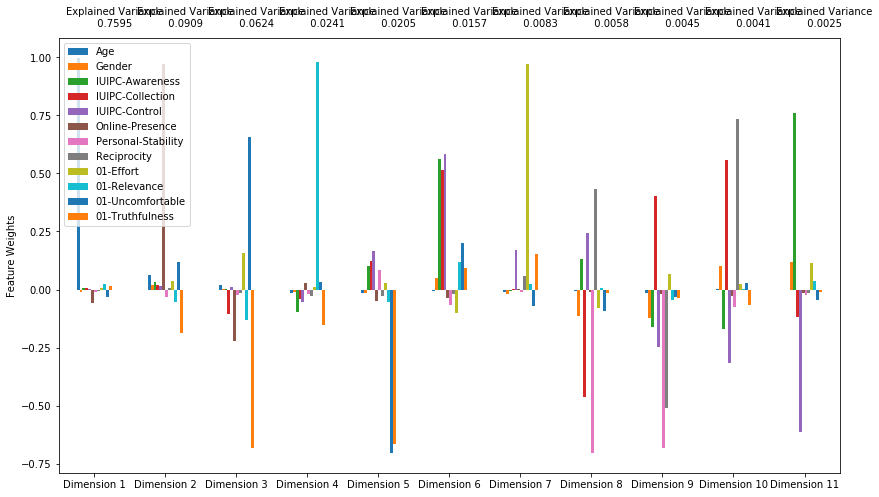

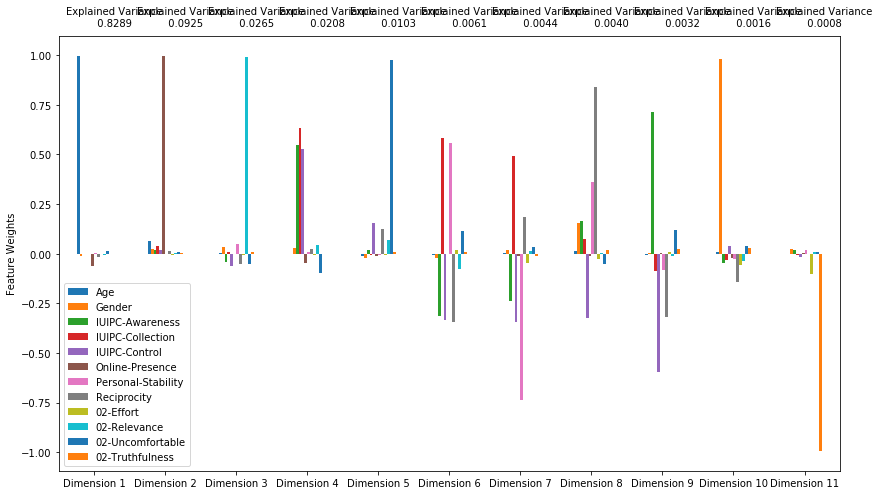

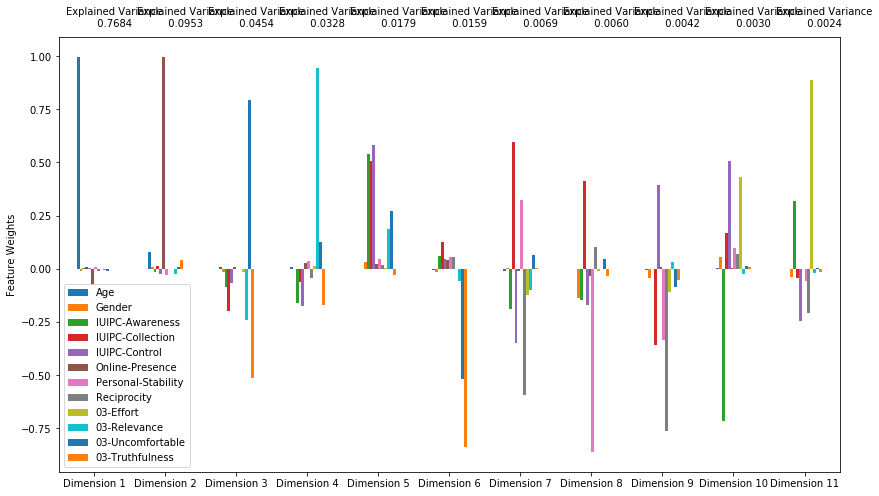

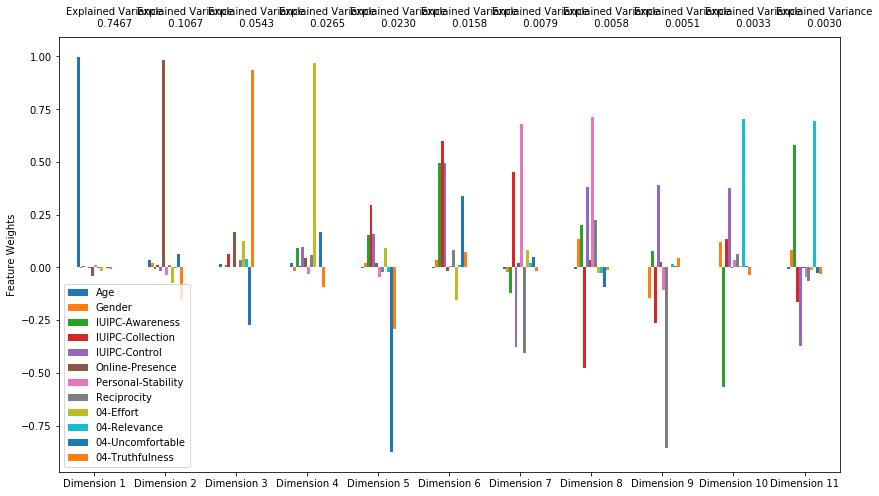

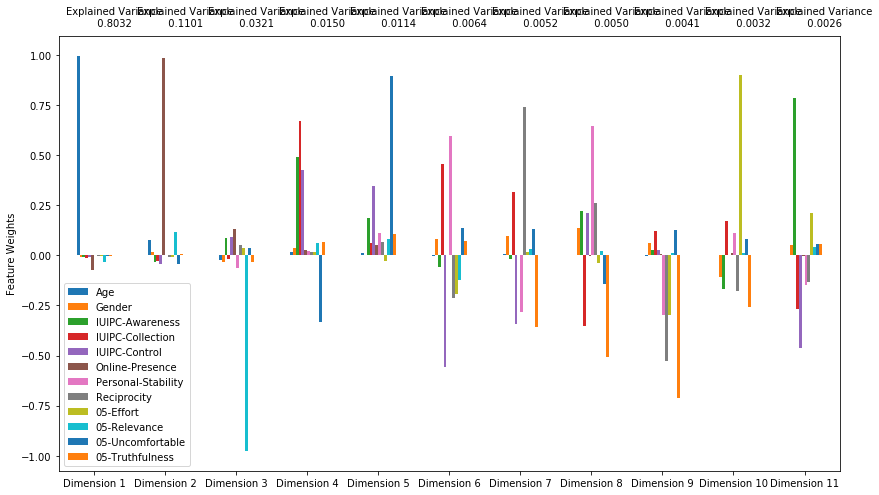

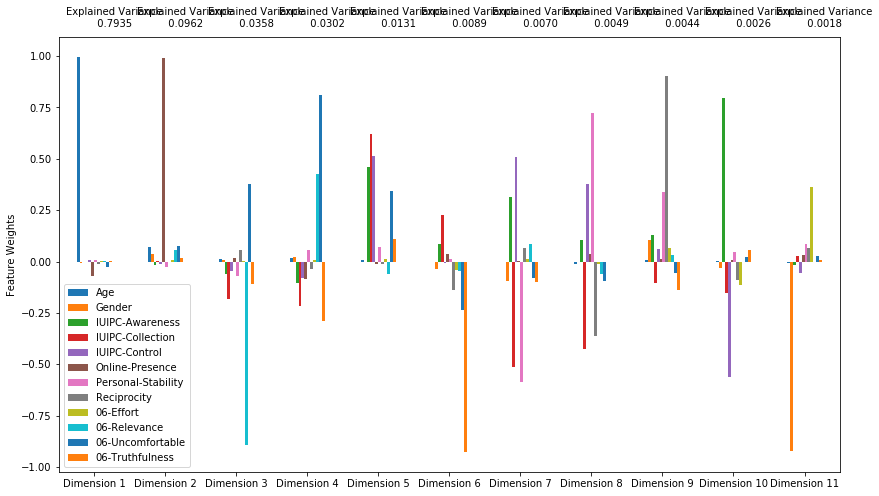

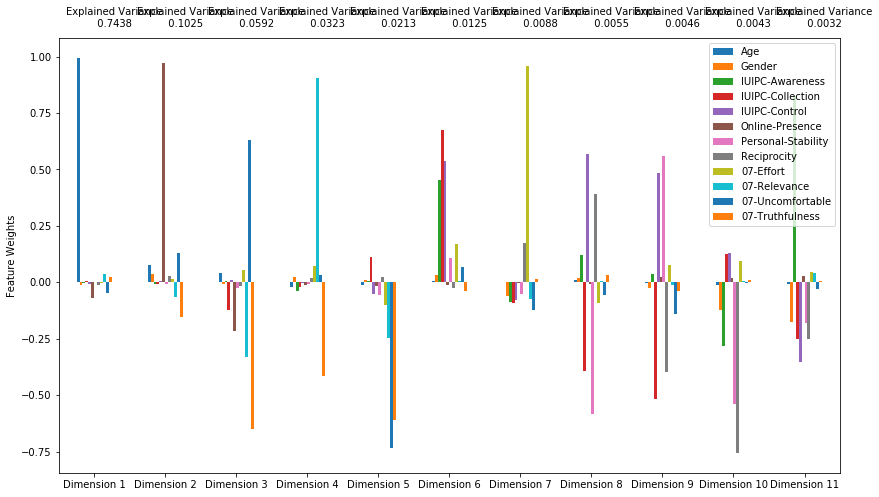

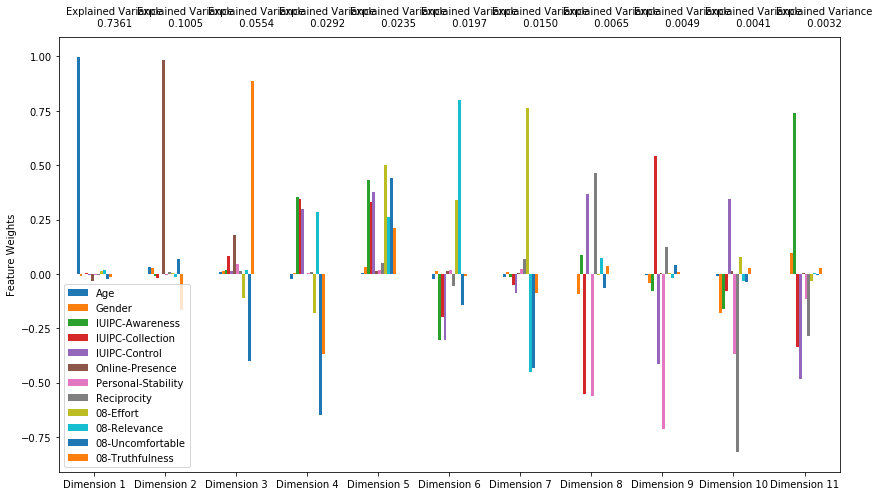

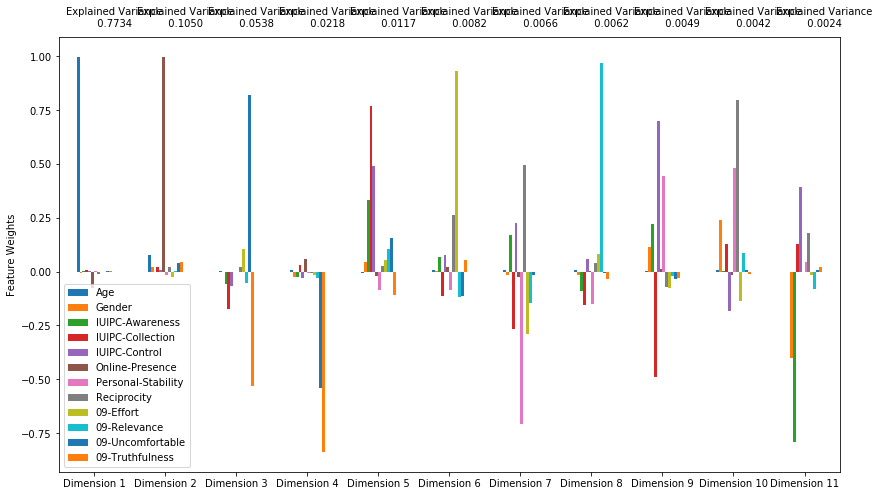

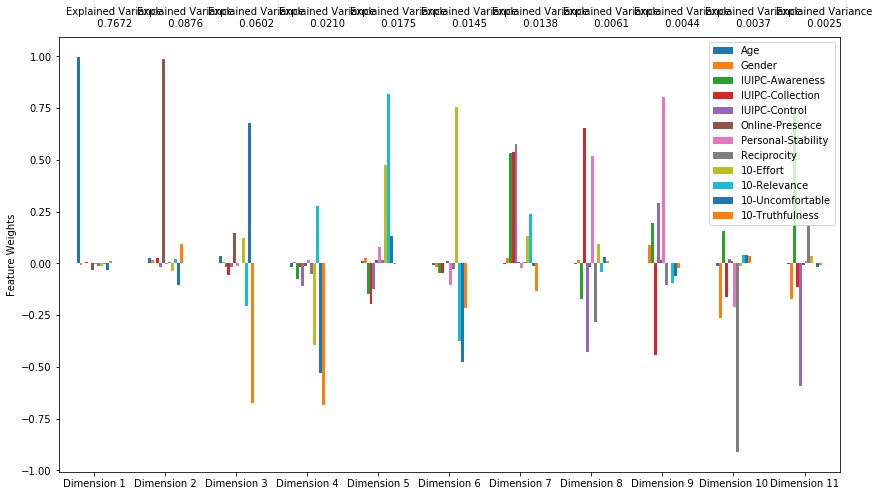

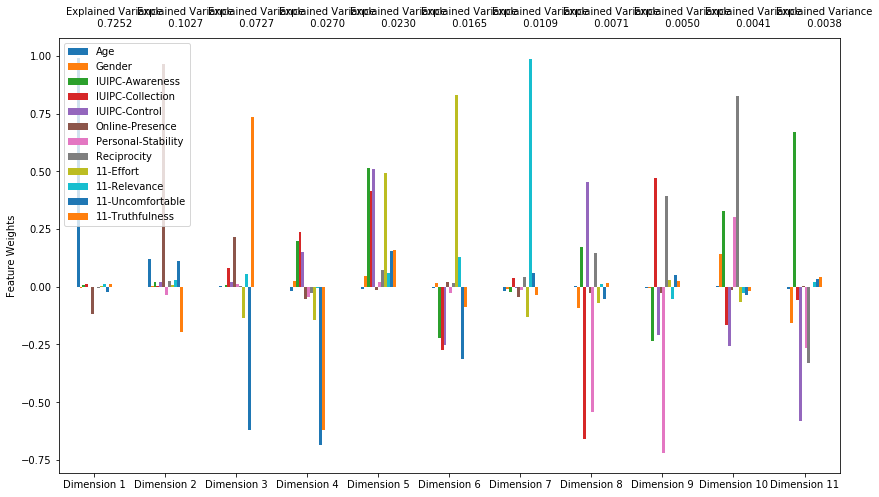

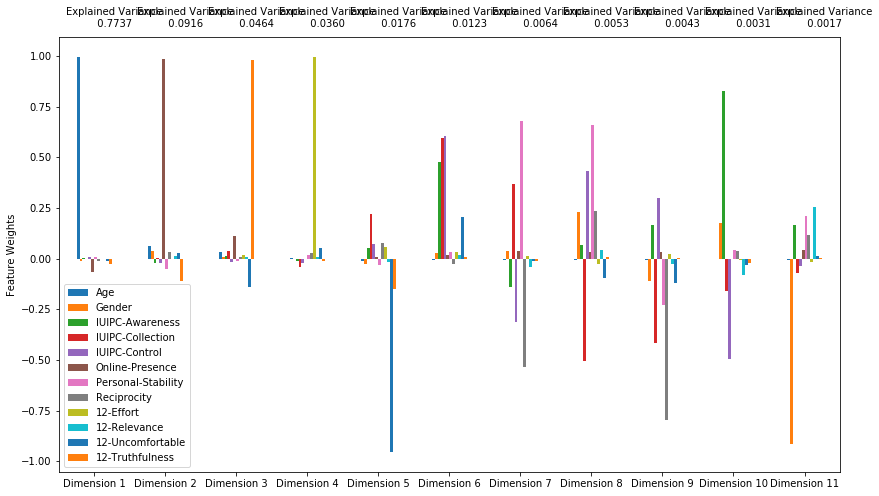

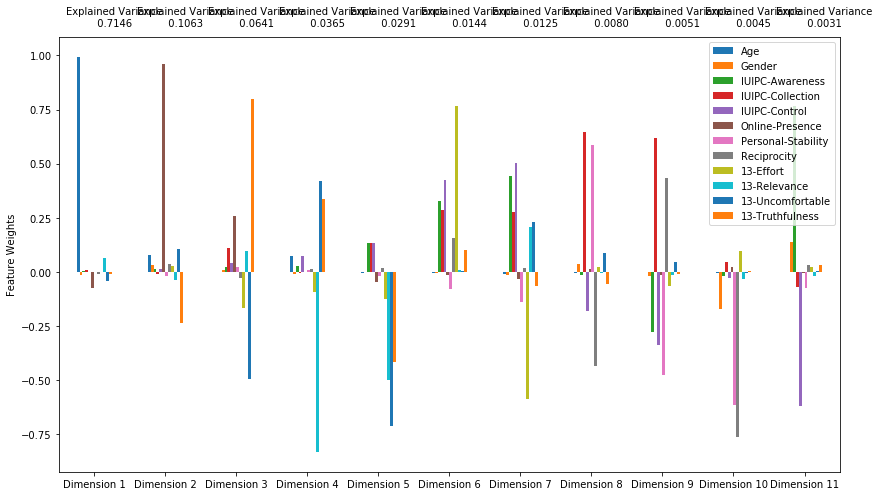

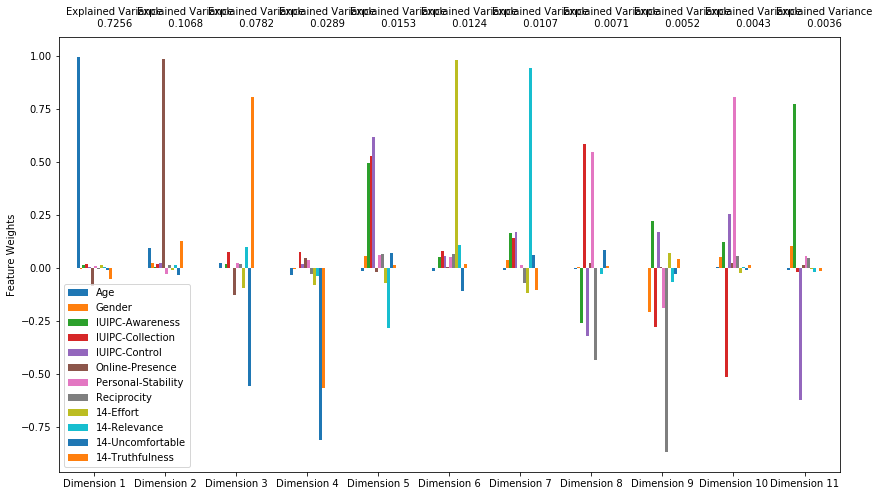

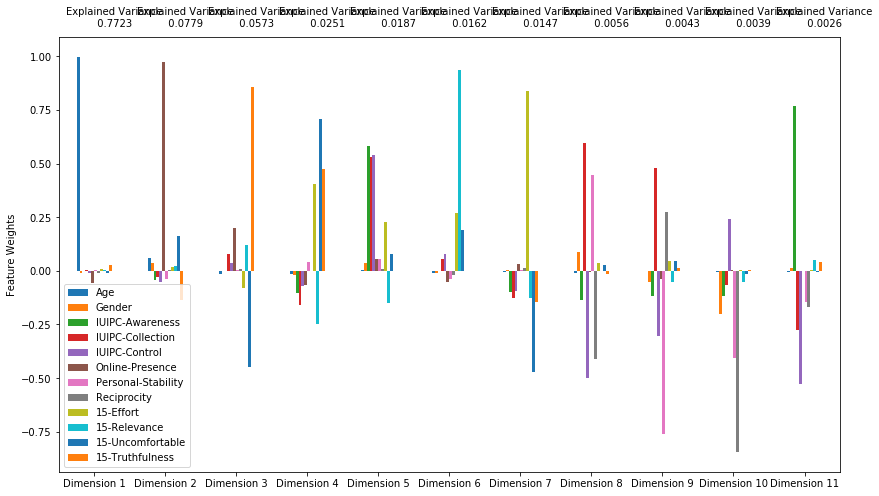

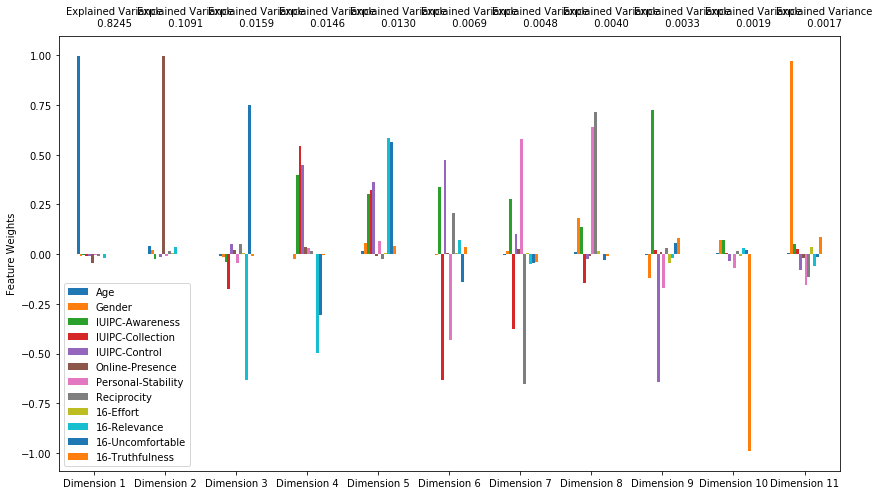

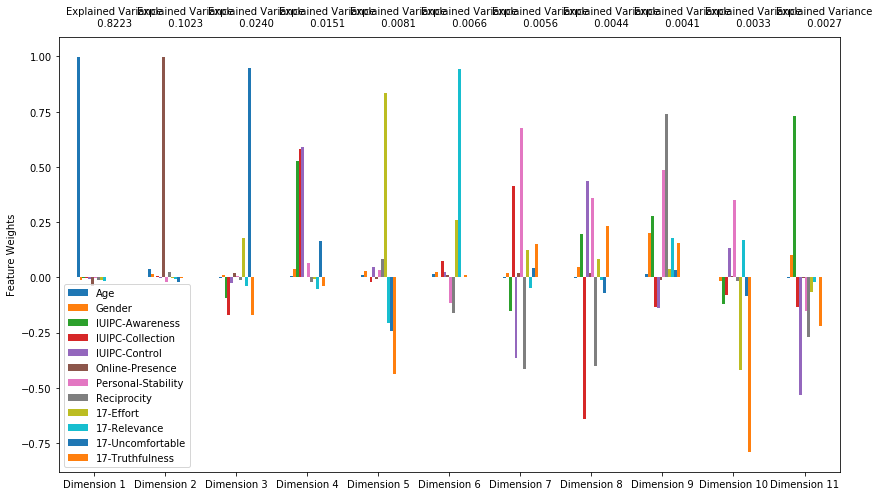

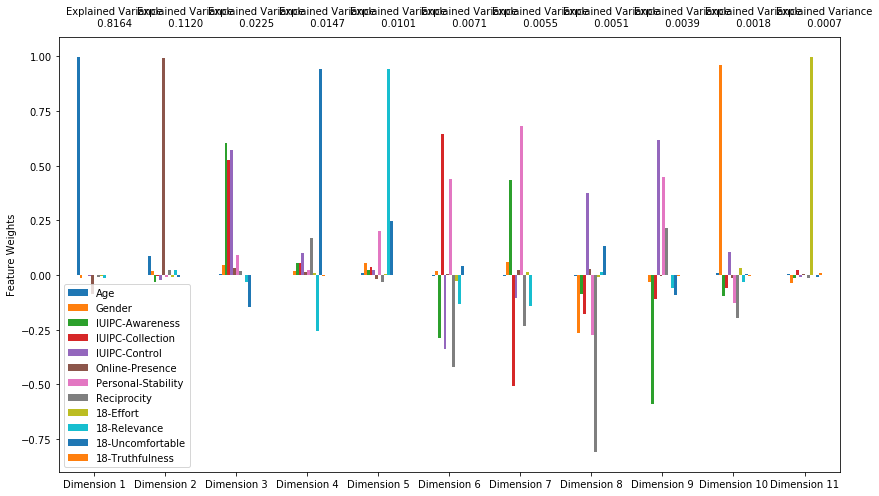

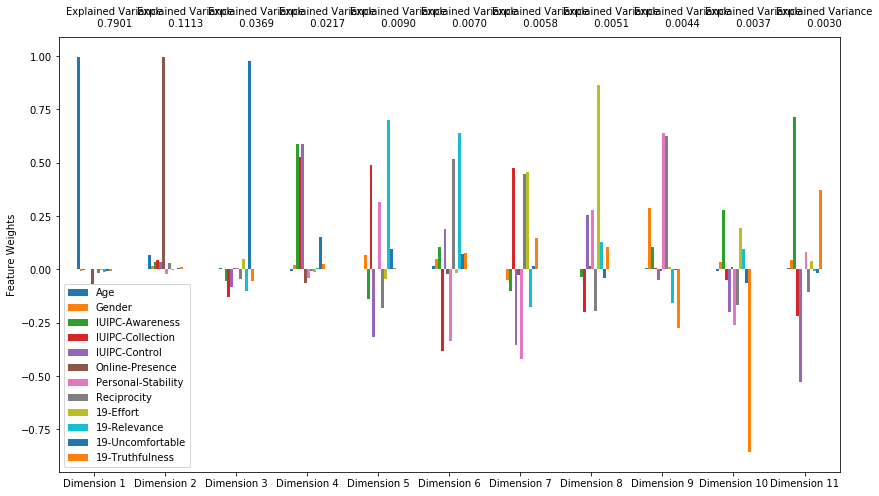

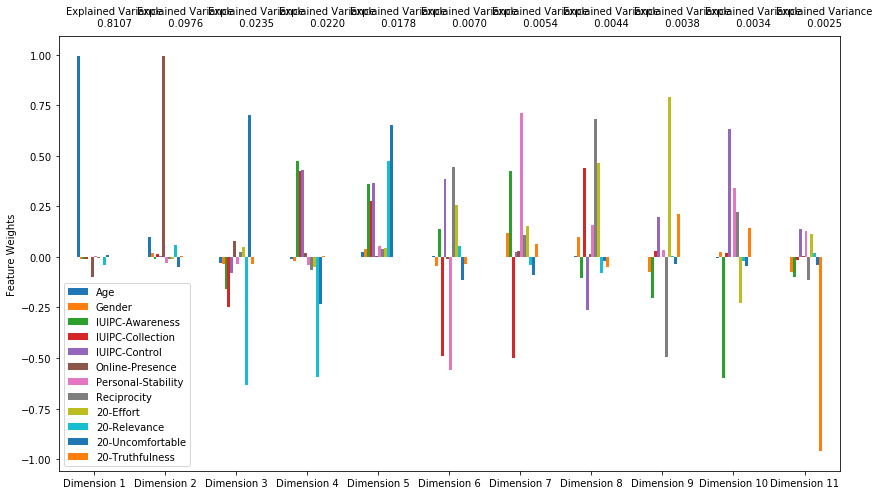

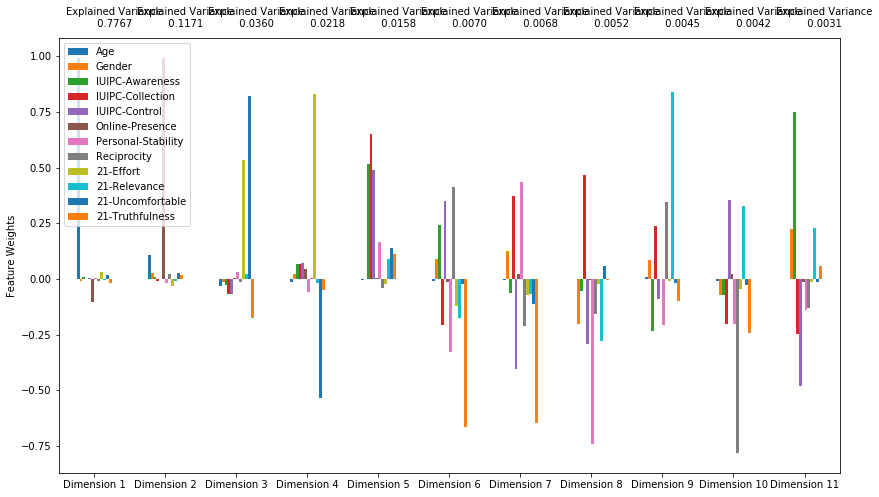

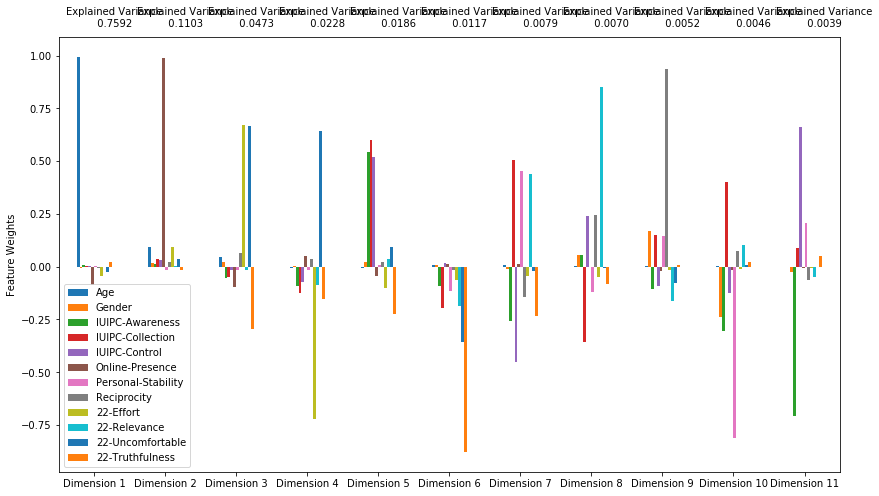

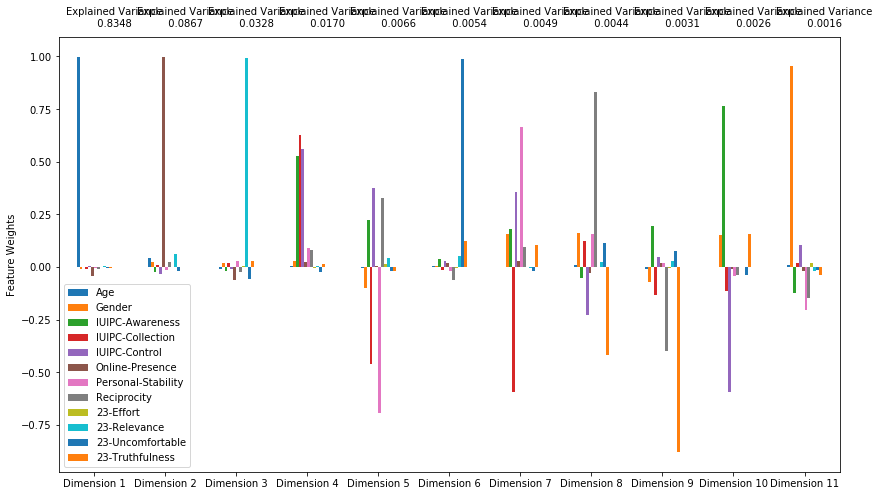

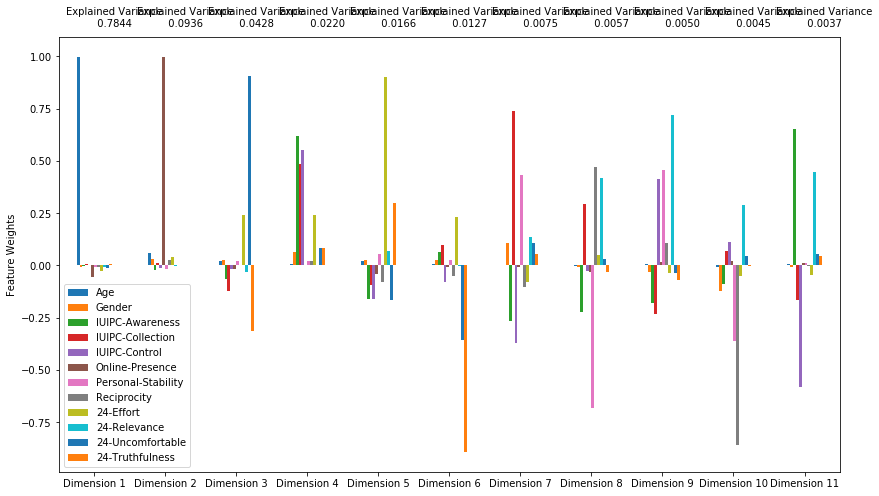

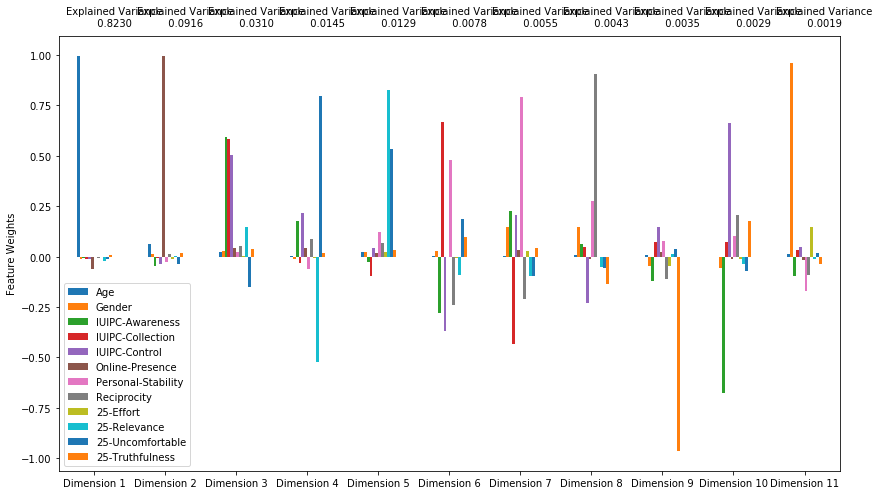

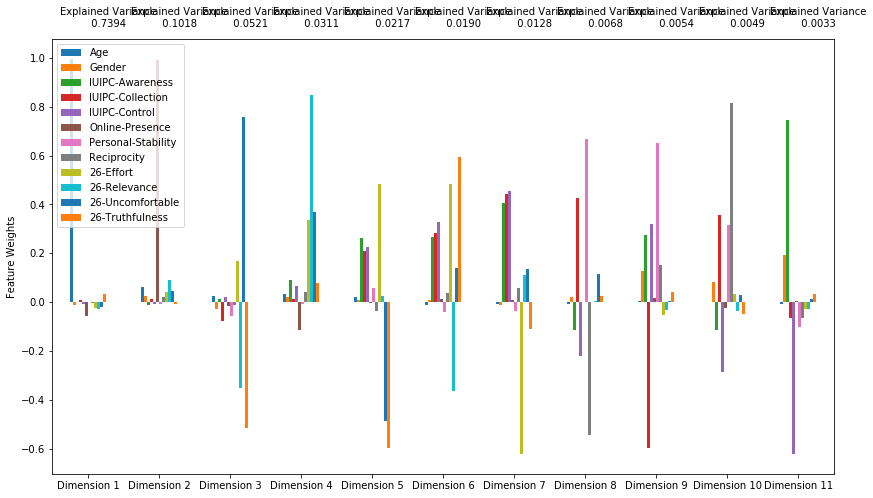

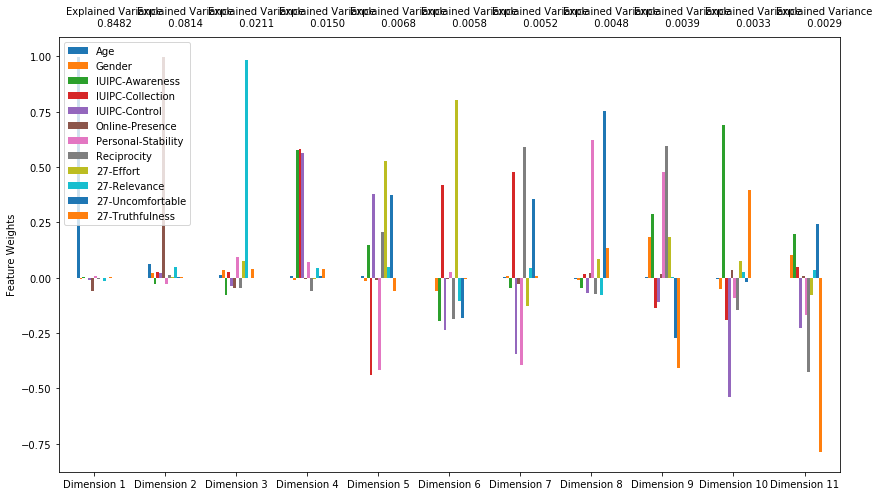

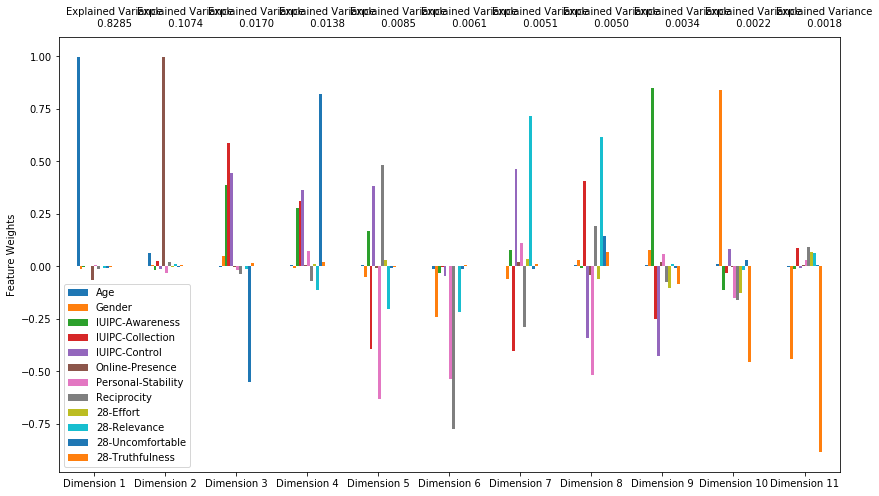

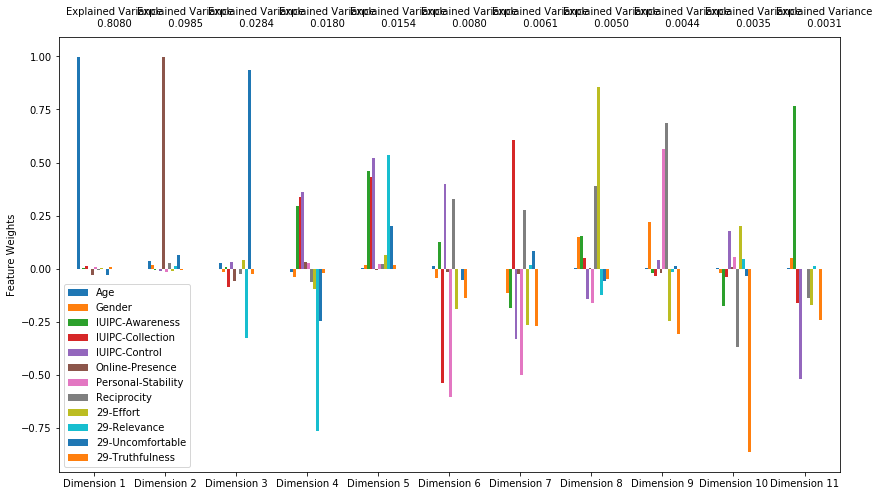

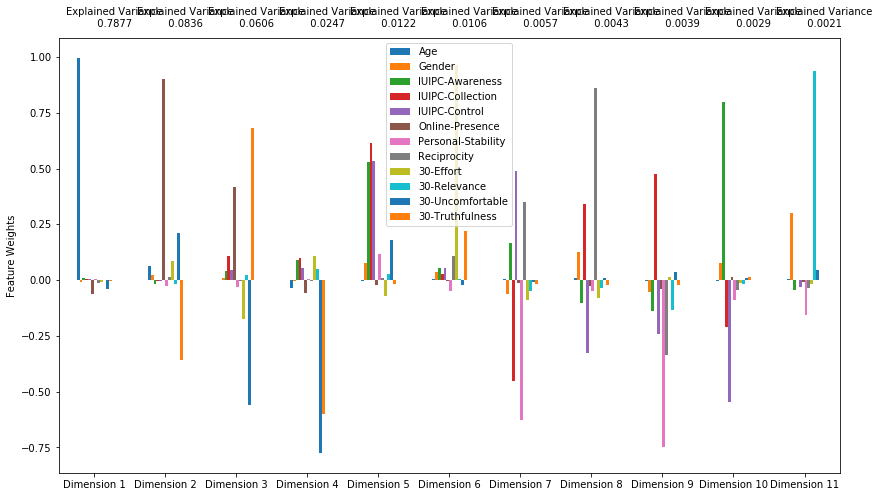

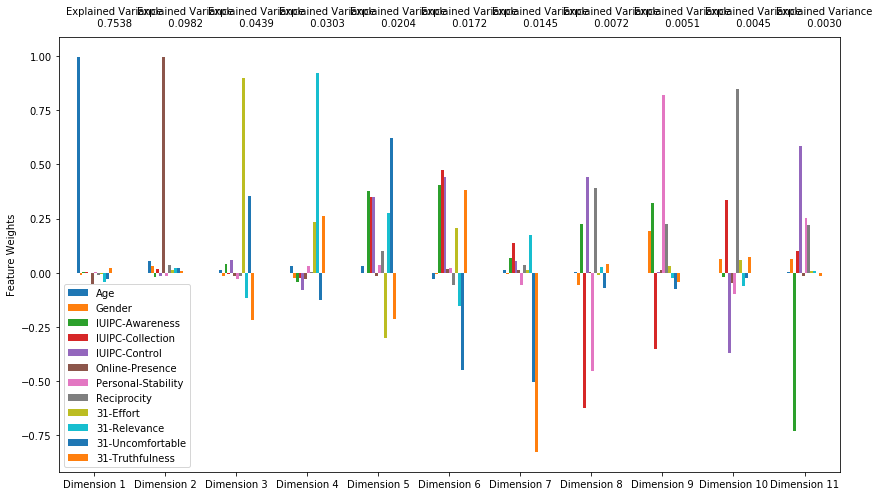

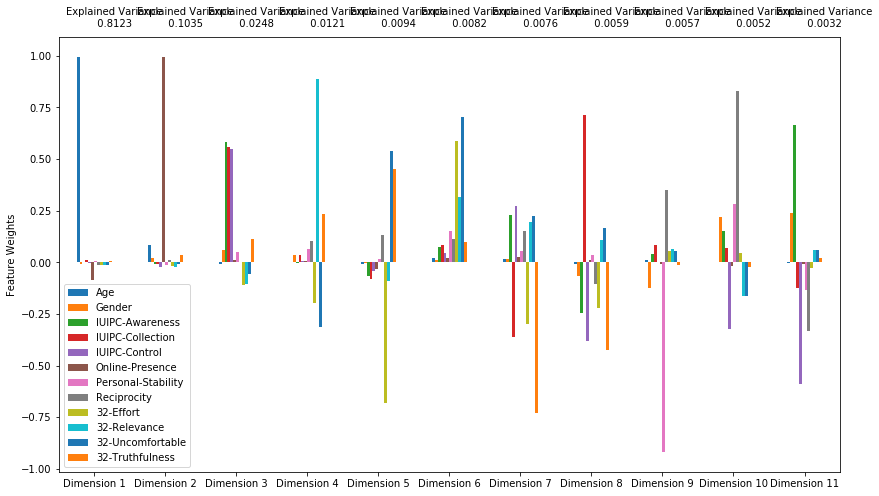

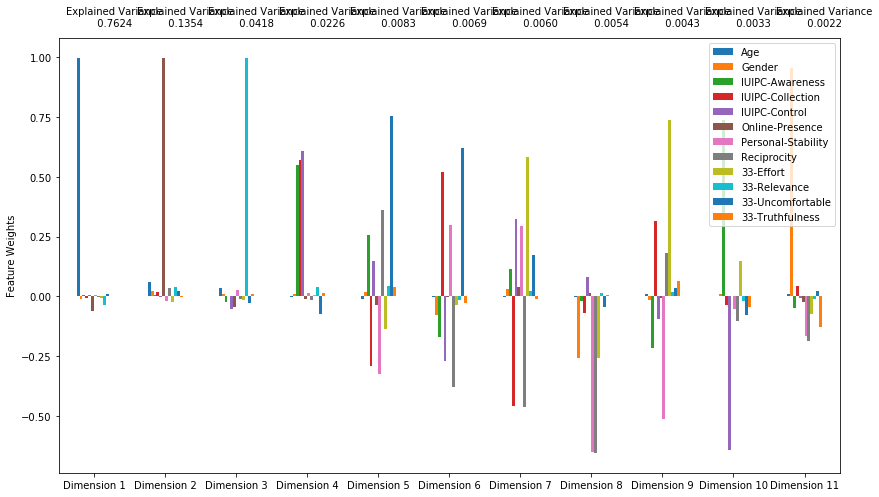

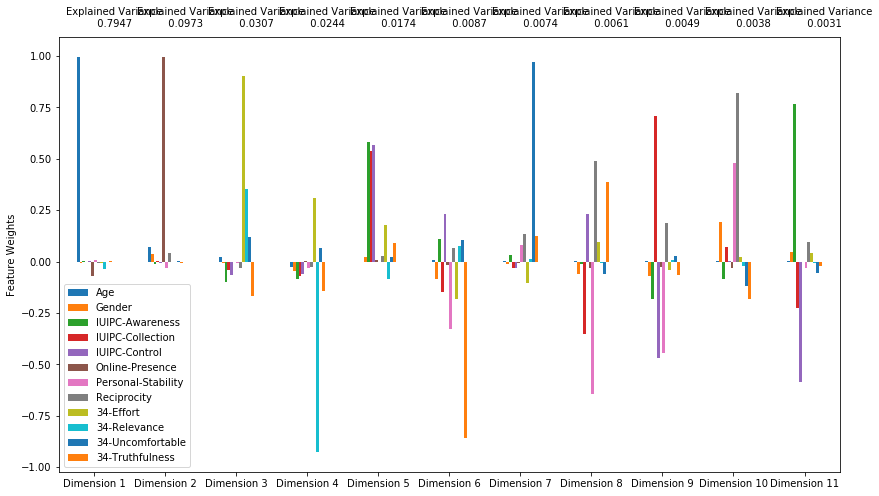

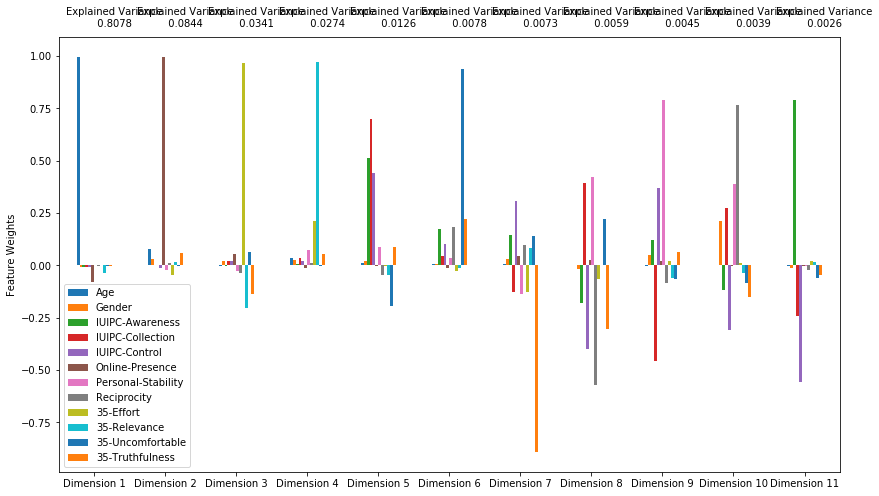

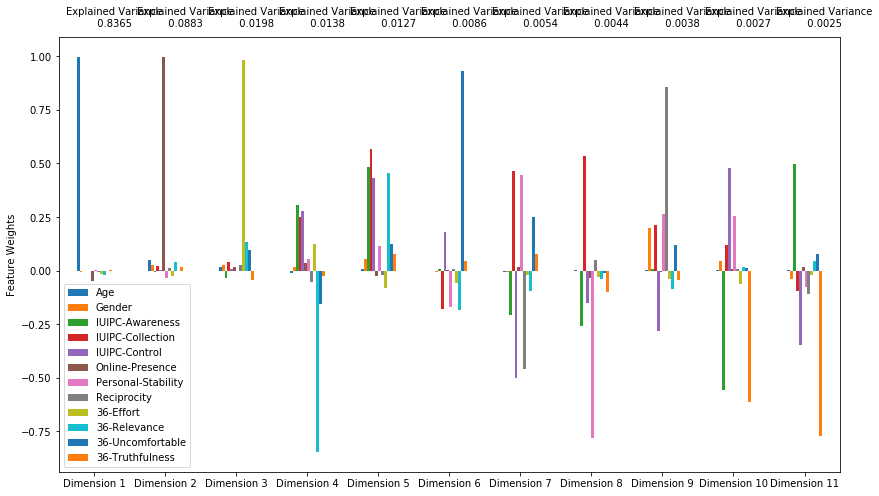

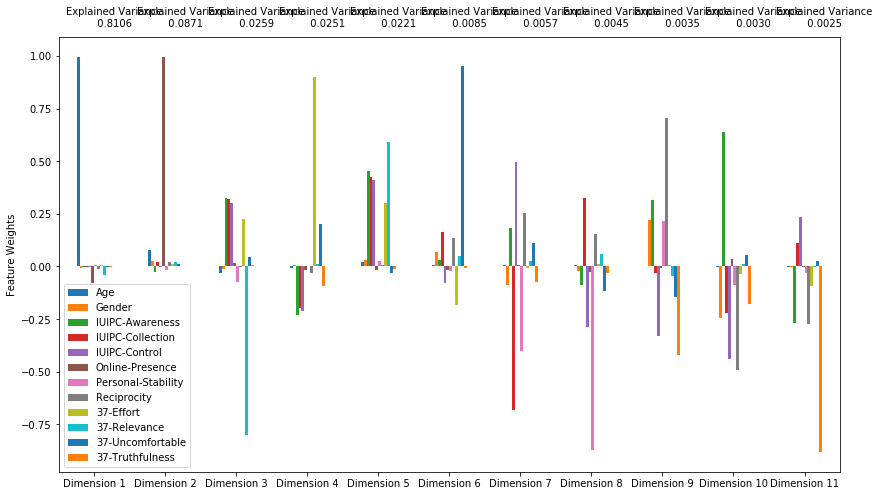

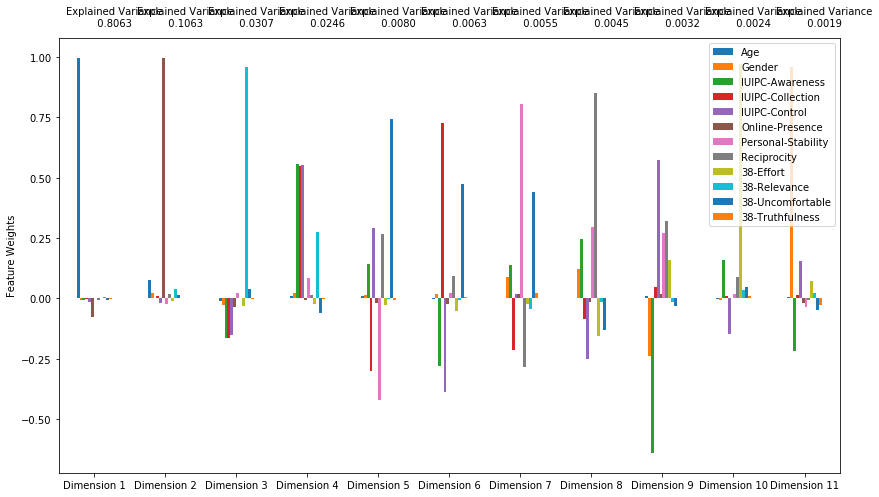

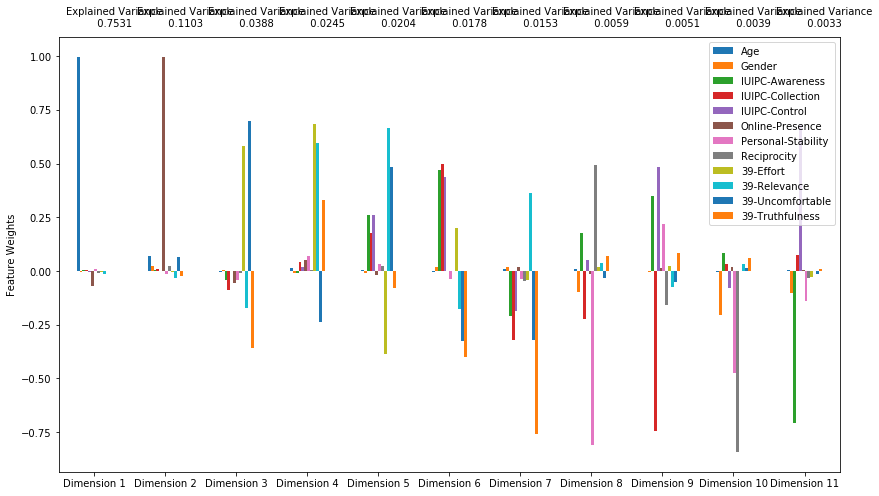

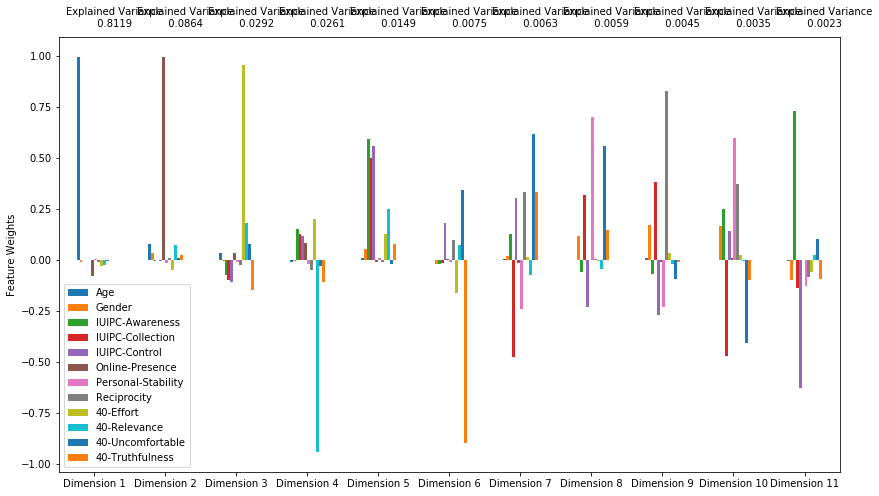

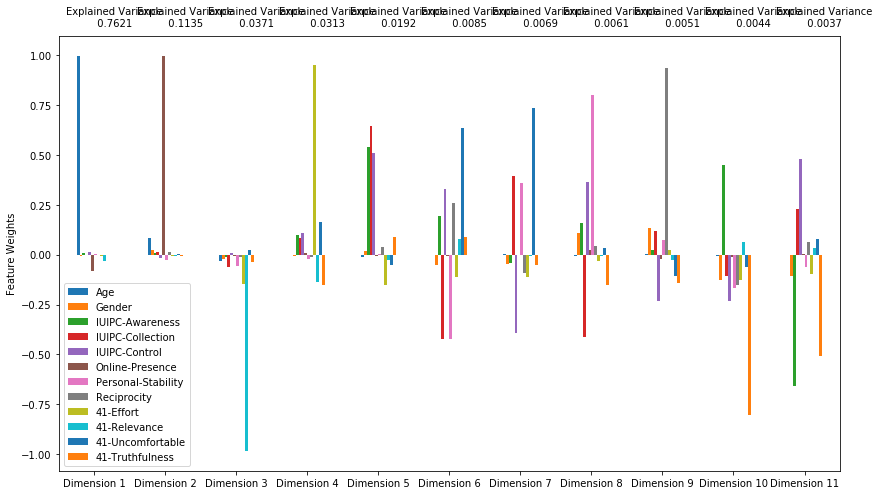

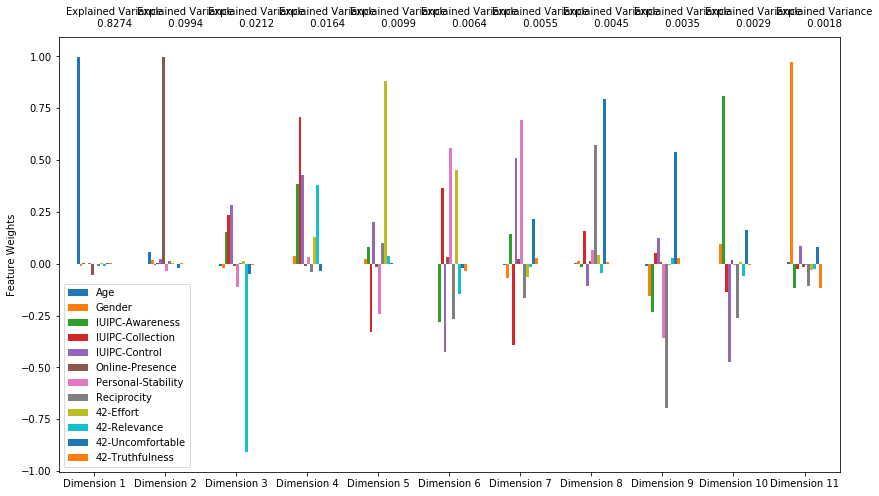

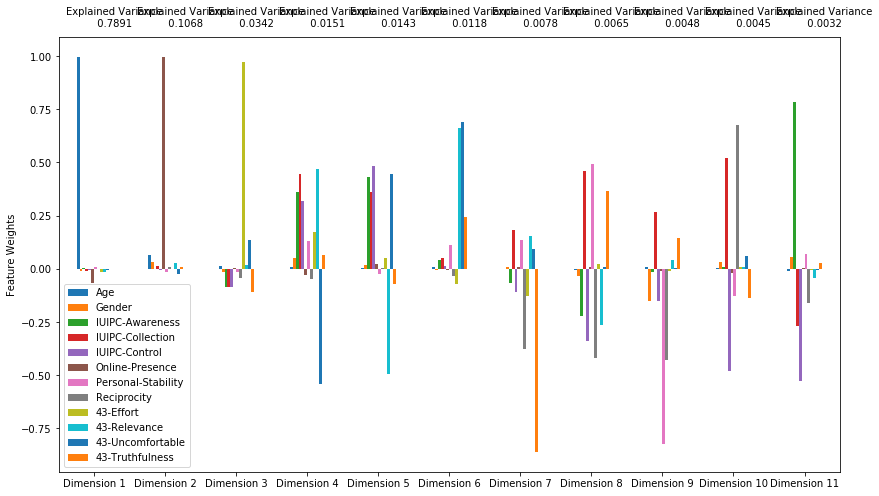

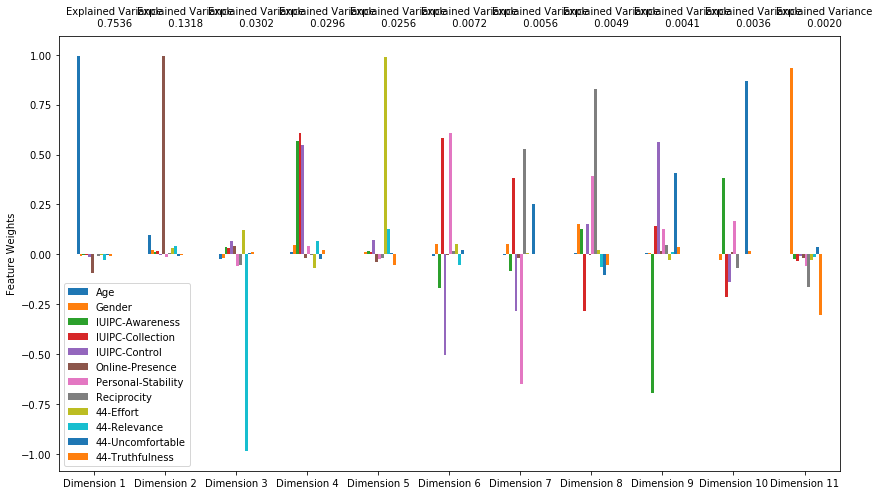

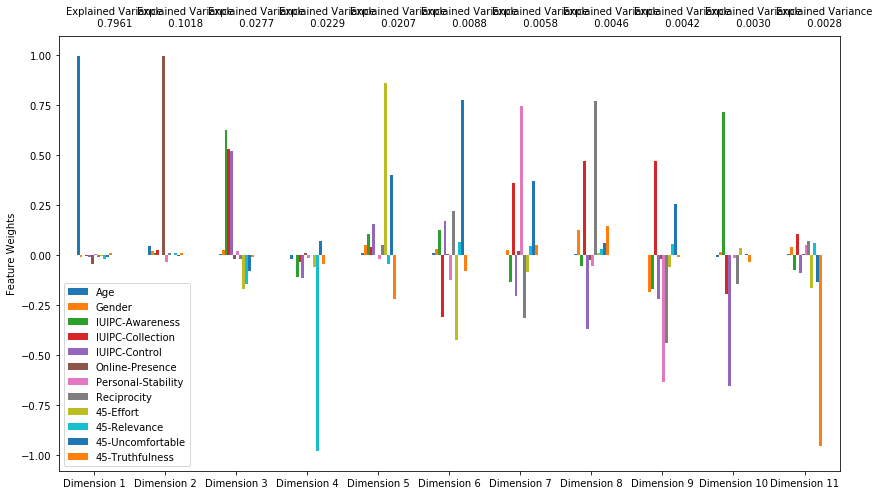

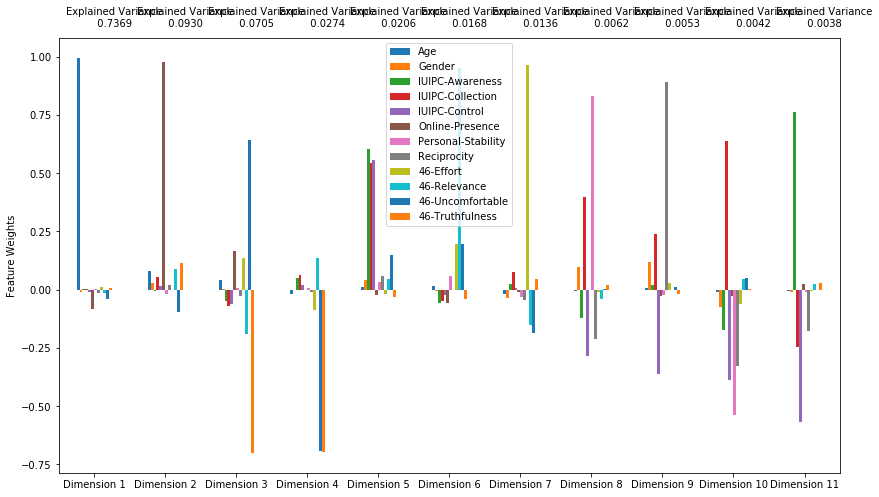

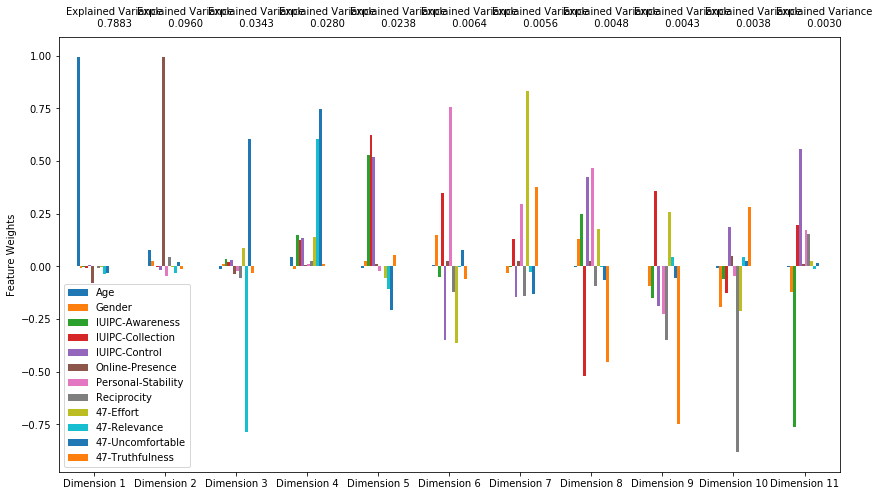

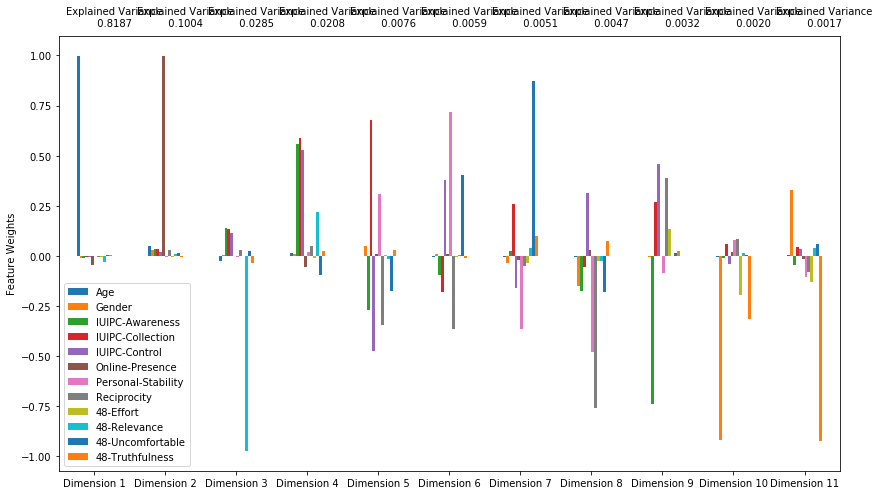

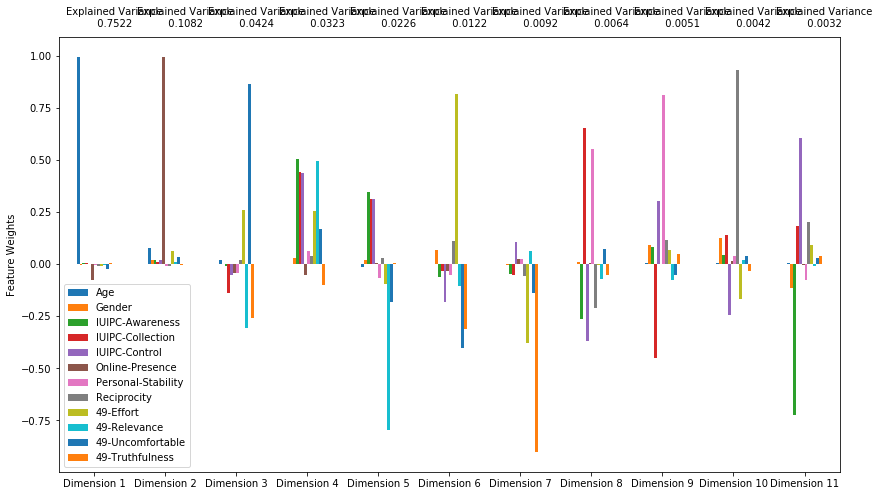

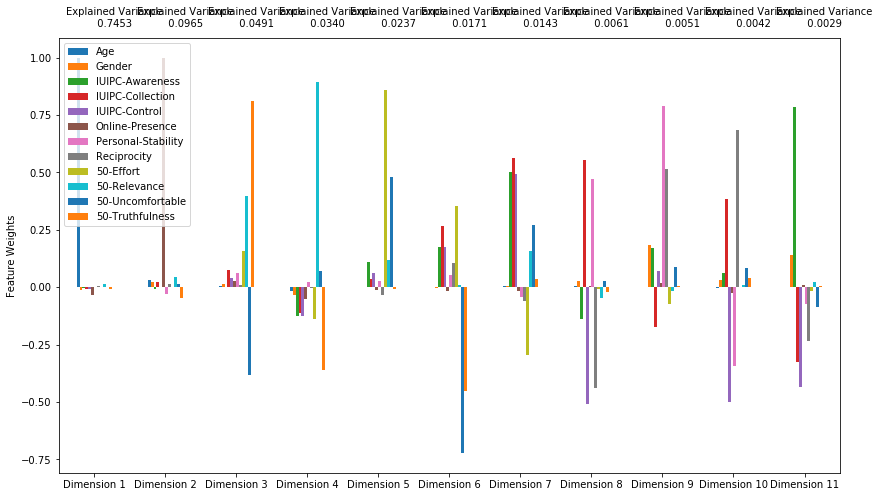

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7518  0.9972 -0.0102           0.0153   
Dimension 2               0.0864  0.0610  0.0186           0.0215   
Dimension 3               0.0578  0.0232 -0.0020          -0.0995   
Dimension 4               0.0316 -0.0191  0.0313           0.6129   
Dimension 5               0.0259 -0.0208  0.0071           0.0279   
Dimension 6               0.0187 -0.0104 -0.0150          -0.0848   
Dimension 7               0.0098 -0.0108 -0.0106          -0.0817   
Dimension 8               0.0056  0.0003  0.0792          -0.1210   
Dimension 9               0.0042 -0.0114 -0.0927          -0.1577   
Dimension 10              0.0040 -0.0058 -0.0923           0.2048   
Dimension 11              0.0026 -0.0057  0.0299           0.7189   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0141         0.0066          -0.0580   
Dimension 2             0.0184         0.0083           0.9844   
Dimension 3            -0.1914        -0.0883          -0.1469   
Dimension 4             0.4861         0.5538          -0.0611   
Dimension 5             0.0404         0.0280           0.0066   
Dimension 6            -0.0031         0.0029          -0.0243   
Dimension 7            -0.1350        -0.0754           0.0117   
Dimension 8             0.4827        -0.3111           0.0085   
Dimension 9             0.4778        -0.2547          -0.0211   
Dimension 10           -0.4721         0.2522           0.0226   
Dimension 11           -0.1406        -0.6730          -0.0087   

              Personal-Stability  Reciprocity  01-Effort  01-Relevance  \
Dimension 1              -0.0026      -0.0081     0.0129        0.0199   
Dimension 2              -0.0289       0.0077     0.0242       -0.0266   
Dimension 3              -0.0383      -0.0282     0.1515       -0.0983   
Dimension 4               0.0092       0.0222     0.1851       -0.1041   
Dimension 5              -0.0036      -0.0257     0.1745        0.9770   
Dimension 6               0.0779       0.0071    -0.0347       -0.0436   
Dimension 7               0.0762       0.0318     0.9490       -0.1407   
Dimension 8               0.7090      -0.3705     0.0034       -0.0193   
Dimension 9              -0.6815      -0.4423     0.0947       -0.0402   
Dimension 10              0.0625      -0.8084    -0.0238       -0.0047   
Dimension 11             -0.0469       0.0497    -0.0123        0.0054   

              01-Uncomfortable  01-Truthfulness  
Dimension 1            -0.0286           0.0121  
Dimension 2             0.0859          -0.1280  
Dimension 3             0.6679          -0.6652  
Dimension 4             0.0804          -0.1556  
Dimension 5             0.0253          -0.0996  
Dimension 6            -0.7055          -0.6964  
Dimension 7            -0.1531           0.1357  
Dimension 8             0.0936          -0.0091  
Dimension 9            -0.0367          -0.0268  
Dimension 10           -0.0560           0.0365  
Dimension 11           -0.0572          -0.0365

Dimension 1     0.7518
Dimension 2     0.8382
Dimension 3     0.8960
Dimension 4     0.9276
Dimension 5     0.9535
Dimension 6     0.9722
Dimension 7     0.9820
Dimension 8     0.9876
Dimension 9     0.9918
Dimension 10    0.9958
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.8096  0.9978 -0.0106           0.0058   
Dimension 2               0.0982  0.0618  0.0202           0.0076   
Dimension 3               0.0308 -0.0082  0.0334           0.5632   
Dimension 4               0.0242 -0.0093 -0.0251           0.2185   
Dimension 5               0.0123 -0.0091  0.0070          -0.0196   
Dimension 6               0.0061 -0.0074 -0.0102          -0.3081   
Dimension 7               0.0044 -0.0041  0.0460           0.2189   
Dimension 8               0.0041  0.0114  0.0238           0.0851   
Dimension 9               0.0033  0.0051  0.1714           0.4742   
Dimension 10              0.0029  0.0083  0.1685          -0.5065   
Dimension 11              0.0024 -0.0041  0.0180           0.0486   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0056         0.0048          -0.0618   
Dimension 2             0.0238         0.0028           0.9971   
Dimension 3             0.5420         0.5154          -0.0094   
Dimension 4             0.1377         0.2163          -0.0309   
Dimension 5            -0.2036         0.0680           0.0032   
Dimension 6             0.6027        -0.3020          -0.0080   
Dimension 7            -0.4236         0.1762           0.0127   
Dimension 8            -0.2262         0.0806           0.0003   
Dimension 9             0.1104        -0.6817          -0.0116   
Dimension 10            0.1805         0.2925          -0.0078   
Dimension 11           -0.0752        -0.0443           0.0134   

              Personal-Stability  Reciprocity  02-Effort  02-Relevance  \
Dimension 1               0.0026      -0.0143    -0.0003       -0.0032   
Dimension 2              -0.0064       0.0078     0.0042       -0.0269   
Dimension 3               0.0509       0.0320     0.0200        0.3403   
Dimension 4              -0.0449       0.0580     0.0283       -0.9234   
Dimension 5               0.0036       0.0622     0.1483        0.1543   
Dimension 6               0.5996      -0.2045    -0.0962       -0.0674   
Dimension 7               0.6131      -0.3787     0.4424       -0.0350   
Dimension 8               0.4963       0.7164    -0.3530        0.0025   
Dimension 9              -0.0319       0.2997     0.4141       -0.0014   
Dimension 10              0.0029       0.4300     0.5865        0.0004   
Dimension 11              0.1072       0.0358    -0.3129       -0.0010   

              02-Uncomfortable  02-Truthfulness  
Dimension 1             0.0120          -0.0061  
Dimension 2             0.0058           0.0109  
Dimension 3             0.0284          -0.0382  
Dimension 4             0.1598          -0.0228  
Dimension 5             0.9499          -0.0386  
Dimension 6             0.1833           0.0418  
Dimension 7            -0.1424          -0.0533  
Dimension 8            -0.0377           0.2212  
Dimension 9            -0.0061          -0.0794  
Dimension 10           -0.1230          -0.2299  
Dimension 11           -0.0040          -0.9375

Dimension 1     0.8096
Dimension 2     0.9078
Dimension 3     0.9386
Dimension 4     0.9628
Dimension 5     0.9751
Dimension 6     0.9812
Dimension 7     0.9856
Dimension 8     0.9897
Dimension 9     0.9930
Dimension 10    0.9959
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7588  0.9977 -0.0107           0.0077   
Dimension 2               0.0950  0.0632  0.0157          -0.0190   
Dimension 3               0.0480 -0.0043 -0.0070          -0.2340   
Dimension 4               0.0296 -0.0166 -0.0059           0.5365   
Dimension 5               0.0274 -0.0009  0.0091           0.2343   
Dimension 6               0.0158 -0.0055 -0.0021          -0.0849   
Dimension 7               0.0063  0.0120  0.0312           0.1702   
Dimension 8               0.0055 -0.0005  0.0863           0.1303   
Dimension 9               0.0048 -0.0066  0.0284          -0.1206   
Dimension 10              0.0041  0.0073  0.0821          -0.0174   
Dimension 11              0.0029 -0.0026 -0.0758           0.7295   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0107         0.0055          -0.0626   
Dimension 2             0.0061        -0.0304           0.9967   
Dimension 3            -0.2837        -0.1894          -0.0090   
Dimension 4             0.3678         0.4927           0.0242   
Dimension 5             0.2457         0.2082           0.0102   
Dimension 6             0.0039        -0.0825          -0.0097   
Dimension 7            -0.6502         0.3468           0.0062   
Dimension 8            -0.3981         0.1628           0.0340   
Dimension 9             0.1484        -0.1006           0.0057   
Dimension 10            0.2926        -0.3339          -0.0107   
Dimension 11           -0.1862        -0.6325          -0.0041   

              Personal-Stability  Reciprocity  03-Effort  03-Relevance  \
Dimension 1               0.0064      -0.0124     0.0036       -0.0100   
Dimension 2              -0.0294       0.0073    -0.0005       -0.0007   
Dimension 3              -0.0151      -0.0158     0.0824       -0.1611   
Dimension 4               0.0293       0.0468     0.0849       -0.5025   
Dimension 5               0.0540      -0.0019     0.0902        0.8301   
Dimension 6               0.0038       0.0488     0.1385       -0.1565   
Dimension 7              -0.2565       0.4414     0.3846        0.0801   
Dimension 8               0.8558      -0.0930    -0.2110        0.0025   
Dimension 9               0.2964      -0.2701     0.8725       -0.0313   
Dimension 10              0.3037       0.8325     0.0503       -0.0158   
Dimension 11             -0.0746      -0.1394     0.0456        0.0091   

              03-Uncomfortable  03-Truthfulness  
Dimension 1             0.0031          -0.0094  
Dimension 2            -0.0034          -0.0048  
Dimension 3             0.6809          -0.5761  
Dimension 4             0.1938          -0.1816  
Dimension 5             0.1294          -0.3526  
Dimension 6            -0.6843          -0.6867  
Dimension 7            -0.0648           0.0871  
Dimension 8            -0.0555          -0.0283  
Dimension 9             0.0236           0.1697  
Dimension 10            0.0760           0.0426  
Dimension 11           -0.0148          -0.0034

Dimension 1     0.7588
Dimension 2     0.8538
Dimension 3     0.9018
Dimension 4     0.9314
Dimension 5     0.9588
Dimension 6     0.9746
Dimension 7     0.9809
Dimension 8     0.9864
Dimension 9     0.9912
Dimension 10    0.9953
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7327  0.9991 -0.0045           0.0075   
Dimension 2               0.0961  0.0362  0.0164          -0.0034   
Dimension 3               0.0556 -0.0068 -0.0020           0.1135   
Dimension 4               0.0404 -0.0045  0.0164           0.6161   
Dimension 5               0.0248  0.0118 -0.0141          -0.0070   
Dimension 6               0.0215 -0.0022  0.0002          -0.1094   
Dimension 7               0.0077 -0.0093 -0.0247          -0.1802   
Dimension 8               0.0064 -0.0065  0.0351           0.0651   
Dimension 9               0.0056 -0.0089  0.0546           0.2010   
Dimension 10              0.0047  0.0002  0.1632          -0.0392   
Dimension 11              0.0028 -0.0049 -0.0684           0.7183   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0021        -0.0001          -0.0354   
Dimension 2             0.0074        -0.0141           0.9880   
Dimension 3             0.1433         0.0926           0.1256   
Dimension 4             0.5211         0.5326          -0.0164   
Dimension 5            -0.0625         0.0020           0.0626   
Dimension 6            -0.0246        -0.0962           0.0073   
Dimension 7             0.5823        -0.3723           0.0034   
Dimension 8            -0.3190         0.1984          -0.0172   
Dimension 9            -0.4693         0.2005           0.0436   
Dimension 10            0.1269        -0.1973          -0.0058   
Dimension 11           -0.1612        -0.6624          -0.0085   

              Personal-Stability  Reciprocity  04-Effort  04-Relevance  \
Dimension 1               0.0141      -0.0040    -0.0071        0.0062   
Dimension 2              -0.0342       0.0021    -0.0840        0.0068   
Dimension 3               0.0198       0.0316     0.1445        0.1338   
Dimension 4               0.0214       0.0475     0.0182        0.0035   
Dimension 5              -0.0409       0.0379     0.9751        0.0577   
Dimension 6              -0.0520      -0.0380     0.0971        0.0544   
Dimension 7               0.5495      -0.3405     0.0418        0.2498   
Dimension 8               0.0701      -0.0058    -0.0863        0.9119   
Dimension 9               0.7748      -0.0967     0.0364       -0.2743   
Dimension 10              0.2641       0.9167    -0.0202        0.0643   
Dimension 11             -0.0977      -0.0526    -0.0083        0.0456   

              04-Uncomfortable  04-Truthfulness  
Dimension 1            -0.0083           0.0080  
Dimension 2             0.0500          -0.1060  
Dimension 3            -0.3905           0.8658  
Dimension 4            -0.0390          -0.2450  
Dimension 5             0.1570          -0.0993  
Dimension 6            -0.8960          -0.3985  
Dimension 7             0.0695          -0.0479  
Dimension 8             0.0559          -0.0771  
Dimension 9            -0.0889           0.0056  
Dimension 10           -0.0103          -0.0443  
Dimension 11           -0.0031           0.0015

Dimension 1     0.7327
Dimension 2     0.8288
Dimension 3     0.8844
Dimension 4     0.9248
Dimension 5     0.9496
Dimension 6     0.9711
Dimension 7     0.9788
Dimension 8     0.9852
Dimension 9     0.9908
Dimension 10    0.9955
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7876  0.9993 -0.0048          -0.0035   
Dimension 2               0.1067  0.0279  0.0224          -0.0350   
Dimension 3               0.0359  0.0137  0.0176           0.6306   
Dimension 4               0.0281 -0.0107 -0.0368           0.0964   
Dimension 5               0.0124  0.0105  0.0174           0.0362   
Dimension 6               0.0062 -0.0017 -0.0941           0.0951   
Dimension 7               0.0059 -0.0007  0.0015           0.0621   
Dimension 8               0.0047 -0.0017  0.0879           0.1807   
Dimension 9               0.0043 -0.0025 -0.0990           0.0106   
Dimension 10              0.0040  0.0087 -0.0211          -0.0032   
Dimension 11              0.0025  0.0036 -0.0828          -0.7342   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0077        -0.0068          -0.0272   
Dimension 2            -0.0262        -0.0402           0.9901   
Dimension 3             0.5492         0.5326           0.0499   
Dimension 4            -0.0590         0.0782           0.1238   
Dimension 5            -0.2277         0.1033           0.0160   
Dimension 6            -0.6049         0.5350          -0.0094   
Dimension 7            -0.1082        -0.0558          -0.0039   
Dimension 8            -0.4406         0.2197           0.0029   
Dimension 9             0.0602        -0.0498           0.0141   
Dimension 10           -0.0006        -0.0987           0.0039   
Dimension 11            0.2588         0.5862           0.0140   

              Personal-Stability  Reciprocity  05-Effort  05-Relevance  \
Dimension 1              -0.0023      -0.0076    -0.0056       -0.0167   
Dimension 2              -0.0097      -0.0042    -0.0212        0.1126   
Dimension 3               0.0214       0.0454     0.0495        0.0893   
Dimension 4              -0.0597       0.0586     0.0787       -0.9575   
Dimension 5               0.0612       0.0268     0.1701        0.2088   
Dimension 6              -0.4533      -0.0578     0.1163        0.0728   
Dimension 7              -0.1801       0.0435     0.4360        0.0909   
Dimension 8               0.7877       0.0247    -0.1905       -0.0195   
Dimension 9               0.2452      -0.7595     0.5519       -0.0413   
Dimension 10              0.2169       0.6362     0.6351        0.0230   
Dimension 11              0.1443       0.0435     0.0621       -0.0281   

              05-Uncomfortable  05-Truthfulness  
Dimension 1            -0.0071          -0.0018  
Dimension 2            -0.0369           0.0147  
Dimension 3             0.0116          -0.0313  
Dimension 4             0.1594          -0.0945  
Dimension 5             0.9074          -0.1874  
Dimension 6            -0.1641           0.2745  
Dimension 7            -0.2838          -0.8174  
Dimension 8            -0.1898          -0.1530  
Dimension 9            -0.0247           0.1999  
Dimension 10           -0.0722           0.3590  
Dimension 11           -0.0132          -0.1251

Dimension 1     0.7876
Dimension 2     0.8943
Dimension 3     0.9302
Dimension 4     0.9583
Dimension 5     0.9707
Dimension 6     0.9769
Dimension 7     0.9828
Dimension 8     0.9875
Dimension 9     0.9918
Dimension 10    0.9958
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7681  0.9981 -0.0084          -0.0040   
Dimension 2               0.0976  0.0562  0.0302          -0.0120   
Dimension 3               0.0379 -0.0027 -0.0049           0.4386   
Dimension 4               0.0316 -0.0063  0.0005           0.1961   
Dimension 5               0.0289  0.0150 -0.0037           0.3952   
Dimension 6               0.0108 -0.0131 -0.0335           0.0222   
Dimension 7               0.0063  0.0013 -0.0310           0.2470   
Dimension 8               0.0055  0.0018  0.0267          -0.0774   
Dimension 9               0.0050 -0.0041  0.1163           0.0883   
Dimension 10              0.0042 -0.0114 -0.1285          -0.0683   
Dimension 11              0.0026  0.0011 -0.0307           0.7298   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0034        -0.0005          -0.0542   
Dimension 2             0.0018        -0.0033           0.9943   
Dimension 3             0.5014         0.3761           0.0500   
Dimension 4             0.1102         0.1595           0.0137   
Dimension 5             0.2485         0.3604          -0.0548   
Dimension 6            -0.0376        -0.0319           0.0313   
Dimension 7            -0.7235         0.4614           0.0057   
Dimension 8            -0.0053        -0.0883           0.0055   
Dimension 9            -0.3290         0.2116           0.0211   
Dimension 10           -0.0799         0.1718           0.0118   
Dimension 11           -0.1878        -0.6381           0.0089   

              Personal-Stability  Reciprocity  06-Effort  06-Relevance  \
Dimension 1               0.0049      -0.0110    -0.0013       -0.0074   
Dimension 2              -0.0206       0.0047     0.0100        0.0040   
Dimension 3               0.0627       0.0254    -0.0391        0.2720   
Dimension 4              -0.0517       0.0657    -0.0094       -0.9519   
Dimension 5               0.0406       0.0164     0.1726        0.0847   
Dimension 6              -0.0582      -0.0707     0.1434        0.0140   
Dimension 7              -0.3347       0.1622     0.1801        0.0859   
Dimension 8               0.4855       0.4155     0.7487       -0.0254   
Dimension 9               0.7726       0.0022    -0.4635       -0.0220   
Dimension 10              0.1810      -0.8706     0.3608       -0.0614   
Dimension 11              0.0462      -0.1290     0.0344        0.0112   

              06-Uncomfortable  06-Truthfulness  
Dimension 1            -0.0230          -0.0040  
Dimension 2             0.0802          -0.0067  
Dimension 3            -0.5200           0.2486  
Dimension 4            -0.0981           0.0287  
Dimension 5             0.6922          -0.3618  
Dimension 6            -0.4649          -0.8657  
Dimension 7            -0.1000           0.1164  
Dimension 8            -0.0774           0.0992  
Dimension 9            -0.0251          -0.1107  
Dimension 10           -0.0248           0.1320  
Dimension 11            0.0063           0.0618

Dimension 1     0.7681
Dimension 2     0.8657
Dimension 3     0.9036
Dimension 4     0.9352
Dimension 5     0.9641
Dimension 6     0.9749
Dimension 7     0.9812
Dimension 8     0.9867
Dimension 9     0.9917
Dimension 10    0.9959
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7331  0.9974 -0.0099           0.0013   
Dimension 2               0.1091  0.0558  0.0314           0.0106   
Dimension 3               0.0517  0.0377 -0.0058          -0.1059   
Dimension 4               0.0333  0.0030  0.0160           0.6319   
Dimension 5               0.0276 -0.0130  0.0173          -0.0497   
Dimension 6               0.0181 -0.0075  0.0157           0.0047   
Dimension 7               0.0090 -0.0077 -0.0442          -0.0816   
Dimension 8               0.0053 -0.0107 -0.0083          -0.2239   
Dimension 9               0.0043 -0.0030 -0.0354           0.0588   
Dimension 10              0.0038 -0.0094 -0.1151          -0.1979   
Dimension 11              0.0030 -0.0081 -0.1793           0.6924   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0108        -0.0060          -0.0484   
Dimension 2             0.0255         0.0151           0.9818   
Dimension 3            -0.1943        -0.0834          -0.1608   
Dimension 4             0.4784         0.5545          -0.0687   
Dimension 5            -0.0476        -0.0130          -0.0098   
Dimension 6             0.1095        -0.0357           0.0012   
Dimension 7             0.0513        -0.1006          -0.0225   
Dimension 8             0.7261        -0.4242          -0.0153   
Dimension 9            -0.3903         0.2212           0.0228   
Dimension 10            0.0316         0.2946           0.0251   
Dimension 11           -0.1819        -0.5925           0.0233   

              Personal-Stability  Reciprocity  07-Effort  07-Relevance  \
Dimension 1               0.0004      -0.0136     0.0029        0.0247   
Dimension 2              -0.0001       0.0291     0.0395       -0.0440   
Dimension 3              -0.0413      -0.0128     0.0731       -0.3160   
Dimension 4               0.0541       0.0296     0.1109       -0.0098   
Dimension 5              -0.0268       0.0015     0.1072        0.9271   
Dimension 6              -0.0531       0.0197    -0.1476       -0.1646   
Dimension 7              -0.0299       0.1061     0.9631       -0.0982   
Dimension 8               0.3442      -0.3258    -0.0326        0.0132   
Dimension 9               0.7491      -0.4552     0.1012       -0.0132   
Dimension 10             -0.5318      -0.7553     0.0683       -0.0153   
Dimension 11             -0.1570      -0.2790     0.0244        0.0205   

              07-Uncomfortable  07-Truthfulness  
Dimension 1            -0.0358           0.0212  
Dimension 2             0.1161          -0.1148  
Dimension 3             0.6350          -0.6375  
Dimension 4             0.1559          -0.1372  
Dimension 5             0.0782          -0.3417  
Dimension 6            -0.7032          -0.6631  
Dimension 7            -0.1691           0.0071  
Dimension 8             0.1260          -0.0259  
Dimension 9            -0.1084          -0.0546  
Dimension 10           -0.0242           0.0199  
Dimension 11           -0.0123           0.0094

Dimension 1     0.7331
Dimension 2     0.8422
Dimension 3     0.8939
Dimension 4     0.9272
Dimension 5     0.9548
Dimension 6     0.9729
Dimension 7     0.9819
Dimension 8     0.9872
Dimension 9     0.9915
Dimension 10    0.9953
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7562  0.9992 -0.0081           0.0023   
Dimension 2               0.0953 -0.0074  0.0338           0.0241   
Dimension 3               0.0481 -0.0022  0.0091           0.0763   
Dimension 4               0.0302 -0.0153  0.0030           0.5676   
Dimension 5               0.0220 -0.0156 -0.0201          -0.2450   
Dimension 6               0.0178 -0.0277  0.0216          -0.1576   
Dimension 7               0.0131  0.0106 -0.0034          -0.0363   
Dimension 8               0.0055  0.0041 -0.0588           0.1301   
Dimension 9               0.0041  0.0058  0.0393           0.0859   
Dimension 10              0.0034 -0.0095 -0.1751          -0.1774   
Dimension 11              0.0028 -0.0043  0.0721           0.7226   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0053        -0.0039           0.0081   
Dimension 2             0.0090         0.0231           0.9892   
Dimension 3             0.1237         0.0727           0.1268   
Dimension 4             0.5005         0.4730          -0.0511   
Dimension 5            -0.1429        -0.1813          -0.0047   
Dimension 6            -0.0969        -0.1871           0.0357   
Dimension 7             0.0458         0.0526           0.0054   
Dimension 8            -0.5899         0.4057          -0.0026   
Dimension 9            -0.4716         0.3613          -0.0077   
Dimension 10           -0.1187         0.3956           0.0149   
Dimension 11           -0.3427        -0.4849           0.0012   

              Personal-Stability  Reciprocity  08-Effort  08-Relevance  \
Dimension 1              -0.0038      -0.0100     0.0130        0.0219   
Dimension 2              -0.0014       0.0104    -0.0003       -0.0262   
Dimension 3               0.0499       0.0169    -0.1340        0.0482   
Dimension 4               0.0065       0.0218    -0.0101        0.2390   
Dimension 5              -0.0141      -0.0412    -0.5013        0.0600   
Dimension 6               0.0370      -0.0289     0.4648        0.8318   
Dimension 7              -0.0246      -0.0748    -0.7091        0.4848   
Dimension 8              -0.4982       0.4562    -0.0125        0.0868   
Dimension 9               0.7931      -0.0876    -0.0245        0.0160   
Dimension 10             -0.3088      -0.8129     0.0889       -0.0251   
Dimension 11             -0.1019      -0.3254    -0.0554        0.0085   

              08-Uncomfortable  08-Truthfulness  
Dimension 1            -0.0241          -0.0106  
Dimension 2             0.0440          -0.1278  
Dimension 3            -0.4469           0.8571  
Dimension 4            -0.2368          -0.2947  
Dimension 5            -0.6944          -0.3835  
Dimension 6            -0.1343          -0.0075  
Dimension 7             0.4873           0.1104  
Dimension 8            -0.0455           0.0296  
Dimension 9            -0.0080          -0.0229  
Dimension 10           -0.0385           0.0283  
Dimension 11           -0.0104           0.0230

Dimension 1     0.7562
Dimension 2     0.8515
Dimension 3     0.8996
Dimension 4     0.9298
Dimension 5     0.9518
Dimension 6     0.9696
Dimension 7     0.9827
Dimension 8     0.9882
Dimension 9     0.9923
Dimension 10    0.9957
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7459  0.9986 -0.0085          -0.0014   
Dimension 2               0.1129  0.0506  0.0238           0.0269   
Dimension 3               0.0535  0.0036 -0.0076          -0.0690   
Dimension 4               0.0285 -0.0020  0.0093           0.5979   
Dimension 5               0.0210 -0.0000 -0.0135          -0.0847   
Dimension 6               0.0109  0.0011 -0.0007          -0.1114   
Dimension 7               0.0071  0.0026  0.0444          -0.0989   
Dimension 8               0.0065  0.0116  0.0045           0.3058   
Dimension 9               0.0052 -0.0015  0.0861           0.1310   
Dimension 10              0.0039  0.0100  0.2077          -0.1207   
Dimension 11              0.0028 -0.0002 -0.1225          -0.6901   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0057        -0.0024          -0.0502   
Dimension 2             0.0431         0.0262           0.9946   
Dimension 3            -0.1702        -0.0669           0.0493   
Dimension 4             0.4577         0.5587          -0.0379   
Dimension 5             0.0278        -0.1009           0.0047   
Dimension 6            -0.2198        -0.0964           0.0509   
Dimension 7            -0.0853        -0.0641          -0.0105   
Dimension 8            -0.7033         0.3079          -0.0084   
Dimension 9            -0.4257         0.2086           0.0177   
Dimension 10            0.1609        -0.0898          -0.0306   
Dimension 11            0.0379         0.7111           0.0009   

              Personal-Stability  Reciprocity  09-Effort  09-Relevance  \
Dimension 1               0.0041      -0.0141     0.0026       -0.0004   
Dimension 2              -0.0136       0.0302    -0.0489        0.0053   
Dimension 3              -0.0083       0.0143     0.2211       -0.0443   
Dimension 4               0.0149       0.0504     0.2477        0.1846   
Dimension 5               0.0228      -0.0186     0.0727       -0.0289   
Dimension 6               0.0596       0.0389     0.9031        0.1827   
Dimension 7              -0.2407       0.0370    -0.1937        0.9354   
Dimension 8              -0.3849       0.3589    -0.0762       -0.1387   
Dimension 9               0.8018      -0.2394    -0.1401        0.1707   
Dimension 10              0.3557       0.8816    -0.0466        0.0317   
Dimension 11             -0.0296       0.0130     0.0074       -0.0221   

              09-Uncomfortable  09-Truthfulness  
Dimension 1            -0.0001           0.0013  
Dimension 2            -0.0248           0.0153  
Dimension 3             0.7512          -0.5864  
Dimension 4             0.0387          -0.1403  
Dimension 5            -0.6280          -0.7618  
Dimension 6            -0.1526           0.2235  
Dimension 7             0.0240          -0.0663  
Dimension 8            -0.1193          -0.0246  
Dimension 9            -0.0241          -0.0293  
Dimension 10            0.0199          -0.0055  
Dimension 11           -0.0045          -0.0098

Dimension 1     0.7459
Dimension 2     0.8588
Dimension 3     0.9123
Dimension 4     0.9408
Dimension 5     0.9618
Dimension 6     0.9727
Dimension 7     0.9798
Dimension 8     0.9863
Dimension 9     0.9915
Dimension 10    0.9954
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7386  0.9989 -0.0076           0.0092   
Dimension 2               0.0963  0.0333  0.0169           0.0099   
Dimension 3               0.0569  0.0237  0.0008          -0.1041   
Dimension 4               0.0363 -0.0062  0.0199           0.6277   
Dimension 5               0.0199 -0.0087  0.0062           0.0215   
Dimension 6               0.0191  0.0060  0.0126          -0.0815   
Dimension 7               0.0145 -0.0119 -0.0172           0.0301   
Dimension 8               0.0059  0.0035  0.0022           0.1799   
Dimension 9               0.0047  0.0019  0.0559           0.1171   
Dimension 10              0.0036  0.0132  0.1940          -0.1000   
Dimension 11              0.0026 -0.0031 -0.1948           0.7138   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0073         0.0055          -0.0340   
Dimension 2             0.0187        -0.0145           0.9981   
Dimension 3            -0.1281        -0.0977           0.0259   
Dimension 4             0.4849         0.5498           0.0017   
Dimension 5             0.0583        -0.0298          -0.0159   
Dimension 6            -0.1193        -0.0790           0.0210   
Dimension 7            -0.0114         0.0850          -0.0085   
Dimension 8            -0.7300         0.4647           0.0090   
Dimension 9            -0.3709         0.1438           0.0184   
Dimension 10            0.1530        -0.1098          -0.0151   
Dimension 11           -0.1830        -0.6397          -0.0115   

              Personal-Stability  Reciprocity  10-Effort  10-Relevance  \
Dimension 1              -0.0016      -0.0130    -0.0003        0.0013   
Dimension 2              -0.0149       0.0087    -0.0145       -0.0053   
Dimension 3              -0.0269      -0.0014     0.1728       -0.2209   
Dimension 4               0.0492       0.0506     0.0994        0.0826   
Dimension 5               0.0287      -0.0281    -0.2440        0.4881   
Dimension 6               0.0635       0.0289     0.6272        0.7185   
Dimension 7              -0.0994      -0.0196     0.7050       -0.4176   
Dimension 8              -0.3839       0.2379    -0.0990        0.0670   
Dimension 9               0.9008      -0.0346    -0.0010       -0.0925   
Dimension 10              0.1112       0.9489     0.0081       -0.0413   
Dimension 11             -0.0537       0.0753     0.0124       -0.0246   

              10-Uncomfortable  10-Truthfulness  
Dimension 1            -0.0240           0.0060  
Dimension 2            -0.0337           0.0018  
Dimension 3             0.6693          -0.6593  
Dimension 4             0.2033          -0.0723  
Dimension 5            -0.4533          -0.7000  
Dimension 6             0.1830           0.1558  
Dimension 7            -0.5152          -0.2101  
Dimension 8            -0.0187          -0.0072  
Dimension 9            -0.0519          -0.0255  
Dimension 10           -0.0366          -0.0252  
Dimension 11           -0.0148           0.0154

Dimension 1     0.7386
Dimension 2     0.8349
Dimension 3     0.8918
Dimension 4     0.9281
Dimension 5     0.9480
Dimension 6     0.9671
Dimension 7     0.9816
Dimension 8     0.9875
Dimension 9     0.9922
Dimension 10    0.9958
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7432  0.9945 -0.0082           0.0094   
Dimension 2               0.0846  0.0938  0.0034           0.0290   
Dimension 3               0.0631  0.0190 -0.0014          -0.0315   
Dimension 4               0.0379 -0.0236  0.0202           0.6203   
Dimension 5               0.0232 -0.0023  0.0132           0.0255   
Dimension 6               0.0162 -0.0213  0.0290          -0.1063   
Dimension 7               0.0124 -0.0224 -0.0086          -0.0579   
Dimension 8               0.0061  0.0093 -0.0624           0.2638   
Dimension 9               0.0046  0.0085  0.0554           0.2063   
Dimension 10              0.0038 -0.0115 -0.1616           0.2453   
Dimension 11              0.0033  0.0030  0.0149          -0.6509   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0172        -0.0013          -0.0939   
Dimension 2             0.0276         0.0261           0.9855   
Dimension 3            -0.1008        -0.0386          -0.0934   
Dimension 4             0.4830         0.5456          -0.0572   
Dimension 5             0.1176         0.0199          -0.0511   
Dimension 6            -0.1547        -0.1446          -0.0020   
Dimension 7            -0.0181        -0.0696          -0.0597   
Dimension 8            -0.7480         0.4248          -0.0149   
Dimension 9            -0.3885         0.0469           0.0344   
Dimension 10           -0.0526        -0.1400           0.0195   
Dimension 11            0.0491         0.6866           0.0083   

              Personal-Stability  Reciprocity  11-Effort  11-Relevance  \
Dimension 1               0.0019      -0.0094     0.0142        0.0275   
Dimension 2              -0.0301       0.0267    -0.0117        0.0584   
Dimension 3              -0.0313      -0.0055     0.1545       -0.0999   
Dimension 4               0.0605       0.0529     0.2228        0.1373   
Dimension 5              -0.0320      -0.0259    -0.4492       -0.0447   
Dimension 6              -0.0234       0.0270     0.7937        0.2951   
Dimension 7               0.1103       0.0324    -0.2874        0.9290   
Dimension 8              -0.3989       0.1110    -0.0924        0.0573   
Dimension 9               0.8855      -0.0601    -0.0178       -0.0887   
Dimension 10             -0.1201      -0.9343     0.0170        0.0549   
Dimension 11              0.1178      -0.2923     0.0443        0.0229   

              11-Uncomfortable  11-Truthfulness  
Dimension 1            -0.0209           0.0162  
Dimension 2             0.0375          -0.1058  
Dimension 3             0.6305          -0.7388  
Dimension 4             0.0287          -0.0648  
Dimension 5            -0.6196          -0.6269  
Dimension 6            -0.4271          -0.2047  
Dimension 7             0.1654          -0.0340  
Dimension 8            -0.0532           0.0143  
Dimension 9            -0.0527          -0.0362  
Dimension 10            0.0052           0.0142  
Dimension 11           -0.0058          -0.0174

Dimension 1     0.7432
Dimension 2     0.8278
Dimension 3     0.8909
Dimension 4     0.9288
Dimension 5     0.9520
Dimension 6     0.9682
Dimension 7     0.9806
Dimension 8     0.9867
Dimension 9     0.9913
Dimension 10    0.9951
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7688  0.9993 -0.0050           0.0108   
Dimension 2               0.0916 -0.0003  0.0358          -0.0249   
Dimension 3               0.0454  0.0016  0.0114           0.2208   
Dimension 4               0.0287  0.0072  0.0024           0.1201   
Dimension 5               0.0262 -0.0270  0.0204           0.5364   
Dimension 6               0.0165 -0.0189 -0.0411          -0.1995   
Dimension 7               0.0053  0.0045 -0.0046           0.1970   
Dimension 8               0.0051 -0.0100  0.0977          -0.0156   
Dimension 9               0.0045 -0.0010  0.1069           0.1479   
Dimension 10              0.0036  0.0095  0.0915          -0.2422   
Dimension 11              0.0028 -0.0010 -0.1407          -0.6902   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0077         0.0106           0.0001   
Dimension 2            -0.0102        -0.0251           0.9948   
Dimension 3             0.1970         0.1677           0.0484   
Dimension 4             0.0706         0.0975           0.0417   
Dimension 5             0.4620         0.5278           0.0044   
Dimension 6            -0.0047        -0.1784          -0.0218   
Dimension 7            -0.5510         0.2809          -0.0402   
Dimension 8            -0.2903         0.0392          -0.0145   
Dimension 9            -0.5170         0.2729           0.0440   
Dimension 10            0.2827        -0.0959          -0.0231   
Dimension 11            0.0666         0.6956           0.0092   

              Personal-Stability  Reciprocity  12-Effort  12-Relevance  \
Dimension 1               0.0069      -0.0088    -0.0071        0.0102   
Dimension 2              -0.0484       0.0296    -0.0342        0.0299   
Dimension 3               0.0449       0.0266    -0.0572        0.1446   
Dimension 4               0.0314       0.0342     0.9740        0.0281   
Dimension 5               0.0669       0.0455    -0.1266        0.0810   
Dimension 6               0.0050       0.0518     0.1693        0.0522   
Dimension 7              -0.5944       0.4521    -0.0025        0.1232   
Dimension 8               0.3898      -0.0855    -0.0194        0.8573   
Dimension 9               0.6240       0.0714    -0.0052       -0.4632   
Dimension 10              0.2706       0.8687    -0.0356        0.0410   
Dimension 11             -0.0444      -0.1095     0.0134        0.0067   

              12-Uncomfortable  12-Truthfulness  
Dimension 1            -0.0208          -0.0188  
Dimension 2            -0.0037          -0.0499  
Dimension 3            -0.3377           0.8607  
Dimension 4             0.1270           0.0388  
Dimension 5            -0.1176          -0.4197  
Dimension 6            -0.9061          -0.2661  
Dimension 7            -0.0639          -0.0057  
Dimension 8             0.0591          -0.0774  
Dimension 9            -0.1158           0.0207  
Dimension 10            0.1110           0.0095  
Dimension 11            0.0067           0.0357

Dimension 1     0.7688
Dimension 2     0.8604
Dimension 3     0.9058
Dimension 4     0.9345
Dimension 5     0.9607
Dimension 6     0.9772
Dimension 7     0.9825
Dimension 8     0.9876
Dimension 9     0.9921
Dimension 10    0.9957
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7207  0.9983 -0.0088           0.0020   
Dimension 2               0.1089  0.0206  0.0341          -0.0048   
Dimension 3               0.0526  0.0046  0.0052           0.0383   
Dimension 4               0.0336  0.0359  0.0003           0.4280   
Dimension 5               0.0296 -0.0372 -0.0005           0.4279   
Dimension 6               0.0228  0.0062 -0.0052          -0.0724   
Dimension 7               0.0129 -0.0020  0.0047          -0.1355   
Dimension 8               0.0065  0.0043 -0.0307           0.1374   
Dimension 9               0.0041 -0.0075 -0.0697           0.2160   
Dimension 10              0.0040 -0.0066 -0.1410          -0.1015   
Dimension 11              0.0027 -0.0001  0.1833           0.7181   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0038        -0.0024          -0.0187   
Dimension 2            -0.0231        -0.0038           0.9758   
Dimension 3             0.1120         0.0450           0.2062   
Dimension 4             0.3445         0.3988          -0.0302   
Dimension 5             0.4106         0.3589           0.0136   
Dimension 6            -0.0568        -0.0421          -0.0457   
Dimension 7            -0.0761        -0.1136          -0.0034   
Dimension 8            -0.5354         0.3549          -0.0181   
Dimension 9            -0.4927         0.3187           0.0157   
Dimension 10            0.3630        -0.1841          -0.0016   
Dimension 11           -0.1683        -0.6459          -0.0075   

              Personal-Stability  Reciprocity  13-Effort  13-Relevance  \
Dimension 1              -0.0005      -0.0104     0.0070        0.0443   
Dimension 2              -0.0229       0.0219     0.0279       -0.0677   
Dimension 3               0.0177      -0.0268    -0.1831        0.0727   
Dimension 4               0.0148       0.0627     0.0915       -0.6294   
Dimension 5               0.0036       0.0437     0.1422        0.4752   
Dimension 6              -0.0096      -0.0156    -0.2827       -0.5781   
Dimension 7               0.0095       0.0965     0.9188       -0.1699   
Dimension 8              -0.6155       0.4266    -0.0274        0.0424   
Dimension 9               0.1376      -0.7575     0.0981        0.0042   
Dimension 10             -0.7650      -0.4632     0.0509       -0.0332   
Dimension 11             -0.0626       0.0152    -0.0002       -0.0168   

              13-Uncomfortable  13-Truthfulness  
Dimension 1            -0.0213          -0.0172  
Dimension 2             0.0886          -0.1774  
Dimension 3            -0.5007           0.8067  
Dimension 4             0.3058           0.1862  
Dimension 5            -0.3851          -0.3488  
Dimension 6            -0.6490          -0.3898  
Dimension 7            -0.2715           0.0825  
Dimension 8            -0.0431           0.0436  
Dimension 9            -0.0371           0.0075  
Dimension 10            0.0242          -0.0030  
Dimension 11           -0.0193           0.0174

Dimension 1     0.7207
Dimension 2     0.8296
Dimension 3     0.8822
Dimension 4     0.9158
Dimension 5     0.9454
Dimension 6     0.9682
Dimension 7     0.9811
Dimension 8     0.9876
Dimension 9     0.9917
Dimension 10    0.9957
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7329  0.9990 -0.0027           0.0047   
Dimension 2               0.1055  0.0310  0.0284           0.0230   
Dimension 3               0.0655  0.0023  0.0022          -0.0494   
Dimension 4               0.0287 -0.0111  0.0421           0.6019   
Dimension 5               0.0234 -0.0279 -0.0130          -0.1779   
Dimension 6               0.0147 -0.0097 -0.0096          -0.0350   
Dimension 7               0.0102 -0.0016  0.0045          -0.0234   
Dimension 8               0.0064 -0.0063 -0.0002          -0.2659   
Dimension 9               0.0042 -0.0052 -0.1944           0.1971   
Dimension 10              0.0037  0.0022  0.0357           0.0527   
Dimension 11              0.0031  0.0067 -0.0793          -0.6976   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0051        -0.0066          -0.0292   
Dimension 2             0.0312         0.0317           0.9742   
Dimension 3            -0.0828        -0.0239           0.2123   
Dimension 4             0.5242         0.5281          -0.0163   
Dimension 5            -0.0883        -0.1484           0.0443   
Dimension 6            -0.0563        -0.0678           0.0301   
Dimension 7             0.0238         0.0449          -0.0107   
Dimension 8             0.6537        -0.3234           0.0182   
Dimension 9            -0.2200         0.1109           0.0029   
Dimension 10           -0.4567         0.3404           0.0196   
Dimension 11            0.1407         0.6757          -0.0123   

              Personal-Stability  Reciprocity  14-Effort  14-Relevance  \
Dimension 1               0.0040      -0.0071     0.0061        0.0015   
Dimension 2              -0.0262       0.0099    -0.0270        0.0053   
Dimension 3              -0.0167      -0.0168     0.0833       -0.1258   
Dimension 4               0.0319       0.0436     0.0278        0.0440   
Dimension 5               0.0245      -0.0427    -0.1310       -0.1095   
Dimension 6               0.0102      -0.0179     0.7632        0.6198   
Dimension 7               0.0695       0.1145     0.6208       -0.7565   
Dimension 8               0.5285      -0.3345     0.0027        0.0027   
Dimension 9              -0.1357      -0.9103     0.0626       -0.0983   
Dimension 10              0.8161       0.0262    -0.0481        0.0452   
Dimension 11             -0.1545      -0.0673     0.0033        0.0447   

              14-Uncomfortable  14-Truthfulness  
Dimension 1            -0.0233          -0.0219  
Dimension 2            -0.0882           0.1930  
Dimension 3             0.5615          -0.7788  
Dimension 4            -0.1525          -0.2302  
Dimension 5            -0.7904          -0.5286  
Dimension 6            -0.1228          -0.0885  
Dimension 7            -0.0866           0.1168  
Dimension 8             0.0746           0.0117  
Dimension 9            -0.0163           0.0411  
Dimension 10           -0.0035           0.0071  
Dimension 11            0.0034           0.0053

Dimension 1     0.7329
Dimension 2     0.8384
Dimension 3     0.9039
Dimension 4     0.9326
Dimension 5     0.9560
Dimension 6     0.9707
Dimension 7     0.9809
Dimension 8     0.9873
Dimension 9     0.9915
Dimension 10    0.9952
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7739  0.9984 -0.0091           0.0014   
Dimension 2               0.0769  0.0404  0.0311          -0.0098   
Dimension 3               0.0514 -0.0263 -0.0061           0.0295   
Dimension 4               0.0289  0.0001  0.0032           0.6018   
Dimension 5               0.0224 -0.0159 -0.0001           0.0128   
Dimension 6               0.0167 -0.0171  0.0007          -0.1301   
Dimension 7               0.0135 -0.0096  0.0126          -0.0587   
Dimension 8               0.0048 -0.0104  0.0936          -0.1264   
Dimension 9               0.0037 -0.0009 -0.1125          -0.0842   
Dimension 10              0.0035 -0.0063 -0.1323          -0.0696   
Dimension 11              0.0025 -0.0061 -0.0161           0.7671   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0033        -0.0081          -0.0365   
Dimension 2             0.0032        -0.0236           0.9869   
Dimension 3             0.1043         0.0575           0.1424   
Dimension 4             0.5395         0.5181           0.0010   
Dimension 5            -0.0443         0.0189          -0.0196   
Dimension 6            -0.1041        -0.1219          -0.0298   
Dimension 7            -0.1050        -0.0929           0.0328   
Dimension 8             0.6155        -0.5309          -0.0100   
Dimension 9             0.4189        -0.2668          -0.0286   
Dimension 10           -0.1354         0.2588           0.0119   
Dimension 11           -0.3169        -0.5307           0.0008   

              Personal-Stability  Reciprocity  15-Effort  15-Relevance  \
Dimension 1               0.0038      -0.0094     0.0203        0.0108   
Dimension 2              -0.0258       0.0038     0.0132        0.0169   
Dimension 3               0.0114       0.0192    -0.0737        0.1415   
Dimension 4               0.0386       0.0094     0.2130        0.0961   
Dimension 5               0.0224      -0.0141     0.5305       -0.1366   
Dimension 6              -0.0571      -0.0065     0.4527        0.8504   
Dimension 7               0.0090       0.0180     0.6781       -0.4733   
Dimension 8               0.4283      -0.3598     0.0246       -0.0072   
Dimension 9              -0.8462       0.1081     0.0171       -0.0606   
Dimension 10             -0.2411      -0.9125     0.0015       -0.0165   
Dimension 11             -0.0835      -0.1372    -0.0382        0.0203   

              15-Uncomfortable  15-Truthfulness  
Dimension 1            -0.0118           0.0307  
Dimension 2             0.0969          -0.1106  
Dimension 3            -0.4675           0.8482  
Dimension 4            -0.0407          -0.1432  
Dimension 5             0.6965           0.4594  
Dimension 6            -0.0962          -0.1246  
Dimension 7            -0.5225          -0.1351  
Dimension 8             0.0237          -0.0145  
Dimension 9             0.0316           0.0114  
Dimension 10           -0.0337           0.0066  
Dimension 11           -0.0124           0.0384

Dimension 1     0.7739
Dimension 2     0.8508
Dimension 3     0.9022
Dimension 4     0.9311
Dimension 5     0.9535
Dimension 6     0.9702
Dimension 7     0.9837
Dimension 8     0.9885
Dimension 9     0.9922
Dimension 10    0.9957
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7913  0.9985 -0.0097          -0.0044   
Dimension 2               0.1049  0.0489  0.0180          -0.0068   
Dimension 3               0.0429  0.0126  0.0190           0.6189   
Dimension 4               0.0182 -0.0030  0.0335           0.0381   
Dimension 5               0.0161  0.0125  0.0438          -0.1007   
Dimension 6               0.0069 -0.0037  0.0031          -0.3077   
Dimension 7               0.0048  0.0073 -0.0012          -0.2316   
Dimension 8               0.0041  0.0088  0.1466           0.0937   
Dimension 9               0.0039 -0.0021  0.0198           0.1383   
Dimension 10              0.0033 -0.0029 -0.1044           0.6533   
Dimension 11              0.0019 -0.0017 -0.4946          -0.0356   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0045        -0.0074          -0.0482   
Dimension 2             0.0110         0.0024           0.9980   
Dimension 3             0.5212         0.5510          -0.0071   
Dimension 4            -0.0963         0.0806           0.0048   
Dimension 5            -0.1045        -0.1229          -0.0171   
Dimension 6             0.7294        -0.3648           0.0013   
Dimension 7             0.3504        -0.0888          -0.0227   
Dimension 8            -0.2064        -0.0387          -0.0023   
Dimension 9            -0.0981        -0.0792           0.0184   
Dimension 10            0.0119        -0.7207           0.0042   
Dimension 11           -0.0164         0.0637           0.0144   

              Personal-Stability  Reciprocity  16-Effort  16-Relevance  \
Dimension 1               0.0001      -0.0117    -0.0033       -0.0156   
Dimension 2              -0.0152       0.0185     0.0037        0.0189   
Dimension 3               0.0589       0.0415     0.0451        0.1826   
Dimension 4              -0.0442       0.0643     0.2032       -0.2121   
Dimension 5               0.0335      -0.0233     0.1136        0.9517   
Dimension 6               0.4385      -0.1464    -0.0379       -0.0420   
Dimension 7              -0.5551       0.5280     0.3606       -0.0076   
Dimension 8               0.6500       0.6754     0.1789       -0.0382   
Dimension 9               0.1734      -0.4567     0.5337       -0.1029   
Dimension 10             -0.1598       0.0800    -0.0778       -0.0065   
Dimension 11              0.0717       0.1468    -0.5728        0.0321   

              16-Uncomfortable  16-Truthfulness  
Dimension 1             0.0023           0.0033  
Dimension 2            -0.0025           0.0088  
Dimension 3             0.0106          -0.0218  
Dimension 4             0.9417          -0.0497  
Dimension 5             0.1921          -0.0649  
Dimension 6             0.1491           0.0322  
Dimension 7            -0.1043          -0.2953  
Dimension 8            -0.0932          -0.0687  
Dimension 9            -0.1424          -0.6403  
Dimension 10            0.0452           0.0511  
Dimension 11            0.1034          -0.6189

Dimension 1     0.7913
Dimension 2     0.8962
Dimension 3     0.9391
Dimension 4     0.9573
Dimension 5     0.9734
Dimension 6     0.9803
Dimension 7     0.9851
Dimension 8     0.9892
Dimension 9     0.9931
Dimension 10    0.9964
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7929  0.9992 -0.0122           0.0010   
Dimension 2               0.1072  0.0269  0.0173          -0.0086   
Dimension 3               0.0321  0.0064  0.0109           0.6039   
Dimension 4               0.0255  0.0069  0.0274           0.0396   
Dimension 5               0.0102  0.0170  0.0281          -0.1089   
Dimension 6               0.0095  0.0117  0.0243           0.0285   
Dimension 7               0.0053  0.0013 -0.0149           0.0486   
Dimension 8               0.0048  0.0084  0.0913           0.3116   
Dimension 9               0.0043 -0.0079 -0.0568           0.0984   
Dimension 10              0.0039 -0.0007  0.0807          -0.0428   
Dimension 11              0.0029  0.0068 -0.0341          -0.7125   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0004        -0.0042          -0.0263   
Dimension 2            -0.0107        -0.0228           0.9984   
Dimension 3             0.5497         0.5137           0.0206   
Dimension 4            -0.0258         0.0987          -0.0018   
Dimension 5            -0.1051        -0.1870          -0.0137   
Dimension 6            -0.0348         0.0179          -0.0133   
Dimension 7            -0.2519         0.2642          -0.0235   
Dimension 8            -0.6522         0.2367          -0.0006   
Dimension 9            -0.4069         0.3877           0.0262   
Dimension 10           -0.1133         0.0130          -0.0101   
Dimension 11            0.1245         0.6432           0.0102   

              Personal-Stability  Reciprocity  17-Effort  17-Relevance  \
Dimension 1              -0.0011      -0.0124    -0.0169       -0.0141   
Dimension 2              -0.0130       0.0243     0.0028        0.0036   
Dimension 3               0.0752       0.0413     0.0212        0.2241   
Dimension 4               0.0229      -0.0003     0.3233        0.0716   
Dimension 5              -0.0828      -0.0268     0.2894        0.9053   
Dimension 6               0.0360       0.0760     0.7881       -0.3302   
Dimension 7              -0.7031       0.2842    -0.2498        0.0181   
Dimension 8               0.3030       0.4664     0.0538        0.0482   
Dimension 9              -0.0734      -0.8106     0.0466       -0.0065   
Dimension 10              0.6092      -0.0583    -0.3448        0.0915   
Dimension 11              0.1231       0.1620     0.0577        0.0605   

              17-Uncomfortable  17-Truthfulness  
Dimension 1             0.0015           0.0042  
Dimension 2            -0.0042          -0.0249  
Dimension 3            -0.1006          -0.0212  
Dimension 4             0.9018          -0.2527  
Dimension 5            -0.1660          -0.0488  
Dimension 6            -0.3626          -0.3578  
Dimension 7            -0.0638          -0.4709  
Dimension 8            -0.0038           0.3139  
Dimension 9            -0.0574           0.0490  
Dimension 10           -0.0960          -0.6838  
Dimension 11           -0.0319           0.1114

Dimension 1     0.7929
Dimension 2     0.9001
Dimension 3     0.9322
Dimension 4     0.9577
Dimension 5     0.9679
Dimension 6     0.9774
Dimension 7     0.9827
Dimension 8     0.9875
Dimension 9     0.9918
Dimension 10    0.9957
Dimension 11    0.9986
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7964  0.9988 -0.0086          -0.0095   
Dimension 2               0.1073  0.0406  0.0238          -0.0250   
Dimension 3               0.0350  0.0194  0.0125           0.6195   
Dimension 4               0.0210 -0.0006  0.0212          -0.0231   
Dimension 5               0.0128  0.0112  0.0113          -0.0818   
Dimension 6               0.0063 -0.0060  0.0257          -0.2806   
Dimension 7               0.0050 -0.0084 -0.0881          -0.0056   
Dimension 8               0.0044 -0.0001 -0.0798          -0.2241   
Dimension 9               0.0041 -0.0041 -0.2070          -0.2106   
Dimension 10              0.0033  0.0058  0.0374          -0.6360   
Dimension 11              0.0028 -0.0053 -0.1871          -0.1596   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0053        -0.0120          -0.0407   
Dimension 2            -0.0009        -0.0256           0.9977   
Dimension 3             0.5276         0.5404           0.0274   
Dimension 4            -0.0735        -0.0021           0.0190   
Dimension 5            -0.1521        -0.1180          -0.0172   
Dimension 6             0.6102        -0.2980          -0.0067   
Dimension 7             0.0605        -0.0678           0.0110   
Dimension 8             0.5526        -0.2825          -0.0214   
Dimension 9            -0.0253         0.3215           0.0097   
Dimension 10            0.0914         0.6128           0.0026   
Dimension 11           -0.0504         0.1946          -0.0116   

              Personal-Stability  Reciprocity  18-Effort  18-Relevance  \
Dimension 1               0.0013      -0.0101    -0.0053       -0.0147   
Dimension 2              -0.0072       0.0113    -0.0165        0.0149   
Dimension 3               0.0530       0.0177     0.0555        0.1870   
Dimension 4               0.0326       0.0721     0.2481       -0.0499   
Dimension 5               0.1073      -0.0025     0.1840        0.9530   
Dimension 6               0.5201      -0.2143    -0.2191        0.0339   
Dimension 7               0.1145      -0.6822     0.4935       -0.1311   
Dimension 8              -0.6215       0.2538     0.0946        0.0735   
Dimension 9              -0.4708      -0.5835    -0.3475        0.1539   
Dimension 10              0.1317       0.2122     0.3569       -0.0473   
Dimension 11              0.2490       0.0950    -0.5742        0.0585   

              18-Uncomfortable  18-Truthfulness  
Dimension 1             0.0016          -0.0032  
Dimension 2            -0.0191          -0.0104  
Dimension 3             0.0399          -0.0423  
Dimension 4             0.9393          -0.2016  
Dimension 5            -0.0239          -0.0387  
Dimension 6             0.1545           0.2643  
Dimension 7            -0.1814          -0.4601  
Dimension 8            -0.0443          -0.3013  
Dimension 9             0.2107           0.2401  
Dimension 10           -0.1086           0.0796  
Dimension 11           -0.0150          -0.7032

Dimension 1     0.7964
Dimension 2     0.9037
Dimension 3     0.9387
Dimension 4     0.9597
Dimension 5     0.9725
Dimension 6     0.9788
Dimension 7     0.9838
Dimension 8     0.9882
Dimension 9     0.9923
Dimension 10    0.9956
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7709  0.9981 -0.0070           0.0032   
Dimension 2               0.1141  0.0531  0.0144           0.0451   
Dimension 3               0.0376 -0.0049  0.0084           0.5587   
Dimension 4               0.0308 -0.0036 -0.0042           0.2920   
Dimension 5               0.0125  0.0170  0.0125          -0.1779   
Dimension 6               0.0077 -0.0012 -0.0158           0.1194   
Dimension 7               0.0066 -0.0217 -0.0041          -0.1112   
Dimension 8               0.0060  0.0008 -0.0830          -0.1849   
Dimension 9               0.0052  0.0002 -0.0083           0.0177   
Dimension 10              0.0041 -0.0111 -0.2262          -0.0639   
Dimension 11              0.0029 -0.0023 -0.0280           0.7096   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0096         0.0004          -0.0528   
Dimension 2             0.0461         0.0318           0.9948   
Dimension 3             0.4578         0.4851          -0.0583   
Dimension 4             0.1621         0.2074          -0.0502   
Dimension 5            -0.0267        -0.2840          -0.0018   
Dimension 6            -0.3574         0.1654           0.0249   
Dimension 7             0.5010        -0.2903           0.0163   
Dimension 8             0.5090        -0.1631          -0.0048   
Dimension 9            -0.2958         0.2431           0.0201   
Dimension 10           -0.0903         0.1456           0.0142   
Dimension 11           -0.1661        -0.6492           0.0008   

              Personal-Stability  Reciprocity  19-Effort  19-Relevance  \
Dimension 1               0.0013      -0.0179    -0.0054       -0.0195   
Dimension 2              -0.0059       0.0187    -0.0082        0.0300   
Dimension 3               0.0270       0.0199     0.0135        0.2575   
Dimension 4               0.0074      -0.0349     0.1756        0.0701   
Dimension 5               0.0762       0.0116     0.3495        0.8363   
Dimension 6              -0.1985       0.1762     0.5563       -0.3168   
Dimension 7               0.3773      -0.4084    -0.0015       -0.2825   
Dimension 8              -0.3114       0.0976     0.5940       -0.1779   
Dimension 9               0.5893      -0.4284     0.4201       -0.0414   
Dimension 10             -0.5808      -0.7487    -0.0537        0.1089   
Dimension 11             -0.0629      -0.1270     0.0517       -0.0504   

              19-Uncomfortable  19-Truthfulness  
Dimension 1            -0.0019          -0.0093  
Dimension 2             0.0274           0.0063  
Dimension 3            -0.4141          -0.0187  
Dimension 4             0.8794          -0.1804  
Dimension 5            -0.0543          -0.2369  
Dimension 6            -0.2026          -0.5554  
Dimension 7            -0.0863          -0.5052  
Dimension 8            -0.0050           0.4268  
Dimension 9            -0.0327           0.3776  
Dimension 10           -0.0280          -0.0409  
Dimension 11           -0.0337           0.1420

Dimension 1     0.7709
Dimension 2     0.8850
Dimension 3     0.9226
Dimension 4     0.9534
Dimension 5     0.9659
Dimension 6     0.9736
Dimension 7     0.9802
Dimension 8     0.9862
Dimension 9     0.9914
Dimension 10    0.9955
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7840  0.9982 -0.0082           0.0020   
Dimension 2               0.0989  0.0438  0.0159           0.0205   
Dimension 3               0.0434  0.0014  0.0194           0.6409   
Dimension 4               0.0228 -0.0145  0.0091           0.0654   
Dimension 5               0.0199  0.0371  0.0571          -0.0878   
Dimension 6               0.0066  0.0102 -0.0271           0.1459   
Dimension 7               0.0064  0.0023  0.0613          -0.0919   
Dimension 8               0.0051  0.0009 -0.0171          -0.1445   
Dimension 9               0.0044  0.0000  0.1324           0.3700   
Dimension 10              0.0040  0.0036  0.0553          -0.2034   
Dimension 11              0.0030 -0.0004 -0.0091          -0.5882   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0040         0.0012          -0.0419   
Dimension 2             0.0324         0.0167           0.9965   
Dimension 3             0.5311         0.5215          -0.0474   
Dimension 4            -0.0097         0.0805           0.0345   
Dimension 5            -0.1010        -0.0901          -0.0300   
Dimension 6            -0.4484         0.2757          -0.0060   
Dimension 7             0.3343        -0.2799          -0.0020   
Dimension 8             0.4166        -0.2126          -0.0218   
Dimension 9            -0.4030        -0.0764           0.0088   
Dimension 10            0.2399        -0.0193           0.0046   
Dimension 11           -0.0092         0.7116           0.0005   

              Personal-Stability  Reciprocity  20-Effort  20-Relevance  \
Dimension 1               0.0041      -0.0076    -0.0065       -0.0404   
Dimension 2              -0.0145      -0.0047    -0.0006        0.0441   
Dimension 3               0.0399       0.0243     0.0187        0.1677   
Dimension 4               0.0104       0.0579     0.1906       -0.2438   
Dimension 5               0.0637       0.0662     0.0939        0.9462   
Dimension 6              -0.5408       0.3166     0.4844        0.0022   
Dimension 7               0.3979       0.0811     0.7526       -0.0688   
Dimension 8              -0.4137       0.0167    -0.2318        0.0562   
Dimension 9               0.5273       0.2766    -0.2619       -0.0376   
Dimension 10             -0.0046       0.8935    -0.1753       -0.0468   
Dimension 11              0.2824      -0.0435    -0.0171        0.0091   

              20-Uncomfortable  20-Truthfulness  
Dimension 1             0.0083           0.0004  
Dimension 2            -0.0282          -0.0078  
Dimension 3            -0.0429           0.0118  
Dimension 4             0.9291          -0.1590  
Dimension 5             0.2358          -0.0141  
Dimension 6            -0.1846          -0.1983  
Dimension 7            -0.1779          -0.1731  
Dimension 8            -0.0248          -0.7284  
Dimension 9            -0.0892          -0.4947  
Dimension 10            0.0296           0.2560  
Dimension 11           -0.0575          -0.2494

Dimension 1     0.7840
Dimension 2     0.8829
Dimension 3     0.9263
Dimension 4     0.9491
Dimension 5     0.9690
Dimension 6     0.9756
Dimension 7     0.9820
Dimension 8     0.9871
Dimension 9     0.9915
Dimension 10    0.9955
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7615  0.9942 -0.0090           0.0078   
Dimension 2               0.1062  0.1027  0.0222          -0.0291   
Dimension 3               0.0415 -0.0037  0.0169           0.6346   
Dimension 4               0.0370 -0.0230 -0.0020           0.0265   
Dimension 5               0.0199 -0.0058  0.0233           0.0585   
Dimension 6               0.0084 -0.0022  0.0976           0.0458   
Dimension 7               0.0067  0.0044 -0.0405           0.1684   
Dimension 8               0.0056  0.0142  0.1027          -0.0249   
Dimension 9               0.0046  0.0021 -0.1622          -0.0839   
Dimension 10              0.0039  0.0144  0.0604          -0.0937   
Dimension 11              0.0030  0.0006  0.1420           0.7283   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0049         0.0072          -0.1016   
Dimension 2            -0.0422        -0.0332           0.9921   
Dimension 3             0.5547         0.5146           0.0596   
Dimension 4            -0.0118        -0.0187           0.0007   
Dimension 5             0.0334         0.0632           0.0216   
Dimension 6            -0.2048         0.0671          -0.0020   
Dimension 7            -0.5047         0.4202          -0.0214   
Dimension 8            -0.2399         0.1365          -0.0050   
Dimension 9             0.3192        -0.1675          -0.0027   
Dimension 10            0.3952        -0.3619          -0.0118   
Dimension 11           -0.2644        -0.6050          -0.0138   

              Personal-Stability  Reciprocity  21-Effort  21-Relevance  \
Dimension 1               0.0056      -0.0136     0.0197       -0.0108   
Dimension 2              -0.0200       0.0101    -0.0104       -0.0037   
Dimension 3               0.0701       0.0398    -0.0846        0.0620   
Dimension 4               0.0398       0.0213     0.5987        0.0869   
Dimension 5              -0.0775       0.0144     0.7667        0.0577   
Dimension 6              -0.1021       0.2406    -0.1884       -0.0131   
Dimension 7              -0.5398       0.3671     0.0256       -0.1323   
Dimension 8               0.2064       0.1148    -0.0730        0.9178   
Dimension 9              -0.7819      -0.3044    -0.0654        0.3434   
Dimension 10             -0.0755       0.8243     0.0044        0.0513   
Dimension 11             -0.0444      -0.0803    -0.0133        0.0377   

              21-Uncomfortable  21-Truthfulness  
Dimension 1             0.0121          -0.0131  
Dimension 2             0.0143           0.0108  
Dimension 3             0.0419          -0.0397  
Dimension 4             0.7615          -0.2244  
Dimension 5            -0.6239          -0.0611  
Dimension 6            -0.1220          -0.9072  
Dimension 7             0.0953           0.2911  
Dimension 8            -0.0343           0.0878  
Dimension 9             0.0369          -0.0953  
Dimension 10            0.0052           0.1106  
Dimension 11           -0.0169           0.0551

Dimension 1     0.7615
Dimension 2     0.8677
Dimension 3     0.9092
Dimension 4     0.9462
Dimension 5     0.9661
Dimension 6     0.9745
Dimension 7     0.9812
Dimension 8     0.9868
Dimension 9     0.9914
Dimension 10    0.9953
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7602  0.9980 -0.0032           0.0040   
Dimension 2               0.1074  0.0433  0.0238          -0.0045   
Dimension 3               0.0409  0.0422  0.0123          -0.1517   
Dimension 4               0.0322  0.0057  0.0146           0.6141   
Dimension 5               0.0193 -0.0144  0.0089           0.0292   
Dimension 6               0.0107 -0.0020  0.0173           0.0331   
Dimension 7               0.0086 -0.0014  0.0077          -0.1930   
Dimension 8               0.0068  0.0000 -0.0149          -0.2211   
Dimension 9               0.0046  0.0074  0.1861          -0.1423   
Dimension 10              0.0044 -0.0012  0.1715           0.2386   
Dimension 11              0.0034 -0.0011 -0.0606          -0.6558   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0015         0.0014          -0.0382   
Dimension 2             0.0163         0.0111           0.9928   
Dimension 3            -0.1316        -0.0924          -0.0957   
Dimension 4             0.5166         0.5257          -0.0360   
Dimension 5             0.0500         0.0278           0.0314   
Dimension 6            -0.1510         0.1117          -0.0137   
Dimension 7             0.1553        -0.2100           0.0011   
Dimension 8             0.7206        -0.3641          -0.0051   
Dimension 9             0.0765         0.0208          -0.0166   
Dimension 10           -0.3649         0.0622           0.0203   
Dimension 11            0.0647         0.7214          -0.0032   

              Personal-Stability  Reciprocity  22-Effort  22-Relevance  \
Dimension 1               0.0012      -0.0099    -0.0425        0.0002   
Dimension 2              -0.0191       0.0183     0.0877        0.0004   
Dimension 3              -0.0121       0.0457     0.6388       -0.0233   
Dimension 4               0.0347       0.0448     0.1770        0.1526   
Dimension 5               0.0089       0.0239    -0.7297       -0.0467   
Dimension 6              -0.1581      -0.0084    -0.1092       -0.2563   
Dimension 7               0.2361      -0.0604    -0.0707        0.8510   
Dimension 8               0.3056      -0.1617     0.0357       -0.4071   
Dimension 9               0.1854       0.9471    -0.0226       -0.0409   
Dimension 10              0.8593      -0.1439     0.0039       -0.1263   
Dimension 11              0.1453      -0.1367    -0.0057       -0.0189   

              22-Uncomfortable  22-Truthfulness  
Dimension 1            -0.0208           0.0112  
Dimension 2             0.0396          -0.0395  
Dimension 3             0.6583          -0.3098  
Dimension 4             0.0936          -0.1068  
Dimension 5             0.6616          -0.1470  
Dimension 6            -0.3236          -0.8693  
Dimension 7            -0.0835          -0.3145  
Dimension 8            -0.0398          -0.1043  
Dimension 9            -0.0695          -0.0142  
Dimension 10           -0.0070          -0.0320  
Dimension 11           -0.0017           0.0372

Dimension 1     0.7602
Dimension 2     0.8676
Dimension 3     0.9085
Dimension 4     0.9407
Dimension 5     0.9600
Dimension 6     0.9707
Dimension 7     0.9793
Dimension 8     0.9861
Dimension 9     0.9907
Dimension 10    0.9951
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.8189  0.9998 -0.0081           0.0020   
Dimension 2               0.0917 -0.0005  0.0242           0.0120   
Dimension 3               0.0285  0.0027  0.0004           0.4726   
Dimension 4               0.0275 -0.0053  0.0250           0.3655   
Dimension 5               0.0094 -0.0022  0.0227           0.0245   
Dimension 6               0.0059 -0.0020 -0.0595           0.2495   
Dimension 7               0.0044  0.0030  0.1714           0.0654   
Dimension 8               0.0040  0.0026  0.0356          -0.0872   
Dimension 9               0.0036 -0.0147 -0.1281           0.0310   
Dimension 10              0.0023  0.0040  0.1475           0.5116   
Dimension 11              0.0022  0.0032 -0.0502          -0.5424   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0027         0.0049           0.0007   
Dimension 2             0.0243        -0.0058           0.9971   
Dimension 3             0.3963         0.4536           0.0223   
Dimension 4             0.3870         0.3438          -0.0549   
Dimension 5            -0.1702         0.0756          -0.0130   
Dimension 6            -0.6045         0.3442           0.0041   
Dimension 7            -0.3860         0.1535           0.0191   
Dimension 8             0.3126        -0.2855          -0.0025   
Dimension 9            -0.1326         0.1780           0.0355   
Dimension 10           -0.0366        -0.5406          -0.0076   
Dimension 11            0.1800         0.3301           0.0073   

              Personal-Stability  Reciprocity  23-Effort  23-Relevance  \
Dimension 1              -0.0014      -0.0131    -0.0017        0.0065   
Dimension 2              -0.0129       0.0264    -0.0064        0.0572   
Dimension 3               0.0240       0.0577     0.0526       -0.6342   
Dimension 4               0.0715       0.0288     0.0606        0.7628   
Dimension 5              -0.0330       0.0295     0.3501        0.0801   
Dimension 6              -0.5429       0.2506     0.0979        0.0542   
Dimension 7               0.7903       0.1504     0.2801       -0.0212   
Dimension 8              -0.1547       0.1299     0.3598       -0.0034   
Dimension 9              -0.0179      -0.9290     0.1609        0.0002   
Dimension 10             -0.0925      -0.0800     0.4923       -0.0324   
Dimension 11             -0.1185       0.0803     0.6143       -0.0388   

              23-Uncomfortable  23-Truthfulness  
Dimension 1             0.0013          -0.0034  
Dimension 2             0.0167           0.0067  
Dimension 3             0.0484          -0.0459  
Dimension 4            -0.0518           0.0232  
Dimension 5             0.8830          -0.2311  
Dimension 6            -0.2556          -0.1217  
Dimension 7            -0.2158          -0.1441  
Dimension 8            -0.2642          -0.7562  
Dimension 9            -0.1160          -0.1707  
Dimension 10           -0.0672           0.4000  
Dimension 11           -0.1238           0.3837

Dimension 1     0.8189
Dimension 2     0.9106
Dimension 3     0.9391
Dimension 4     0.9666
Dimension 5     0.9760
Dimension 6     0.9819
Dimension 7     0.9863
Dimension 8     0.9903
Dimension 9     0.9939
Dimension 10    0.9962
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7772  0.9988 -0.0097           0.0010   
Dimension 2               0.0933  0.0359  0.0218           0.0132   
Dimension 3               0.0388  0.0245  0.0218           0.0315   
Dimension 4               0.0345 -0.0045  0.0231           0.6343   
Dimension 5               0.0163  0.0125  0.0262          -0.0957   
Dimension 6               0.0132  0.0031 -0.0002           0.0087   
Dimension 7               0.0066 -0.0055  0.0837          -0.2818   
Dimension 8               0.0061  0.0107 -0.0696          -0.1433   
Dimension 9               0.0047 -0.0077  0.0137          -0.1058   
Dimension 10              0.0042  0.0065  0.1075          -0.1062   
Dimension 11              0.0035 -0.0020  0.0244          -0.6811   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0105        -0.0000          -0.0359   
Dimension 2             0.0325         0.0015           0.9975   
Dimension 3            -0.0303         0.0443           0.0073   
Dimension 4             0.5288         0.5294          -0.0322   
Dimension 5            -0.0449        -0.1054          -0.0141   
Dimension 6            -0.0188        -0.1456          -0.0294   
Dimension 7             0.7188        -0.3977          -0.0101   
Dimension 8             0.0242         0.0434           0.0074   
Dimension 9             0.4201        -0.2086          -0.0244   
Dimension 10            0.0063         0.0147          -0.0247   
Dimension 11            0.1255         0.6940           0.0008   

              Personal-Stability  Reciprocity  24-Effort  24-Relevance  \
Dimension 1              -0.0022      -0.0077    -0.0183       -0.0124   
Dimension 2              -0.0080       0.0228     0.0232       -0.0079   
Dimension 3               0.0230       0.0163     0.2930        0.0195   
Dimension 4               0.0436       0.0495     0.1371        0.0802   
Dimension 5               0.0595      -0.0219     0.8967        0.0568   
Dimension 6              -0.0174      -0.0409     0.2681        0.1199   
Dimension 7               0.4492      -0.1189    -0.0747        0.1118   
Dimension 8              -0.2808       0.1686    -0.0686        0.9233   
Dimension 9              -0.8155       0.1294     0.0646       -0.2847   
Dimension 10              0.2070       0.9573     0.0159       -0.1142   
Dimension 11             -0.0027      -0.1096     0.0503       -0.1064   

              24-Uncomfortable  24-Truthfulness  
Dimension 1            -0.0178           0.0062  
Dimension 2            -0.0240          -0.0184  
Dimension 3             0.8887          -0.3437  
Dimension 4            -0.0815          -0.0041  
Dimension 5            -0.1448           0.3800  
Dimension 6            -0.4115          -0.8485  
Dimension 7             0.0674           0.0057  
Dimension 8             0.0412           0.0768  
Dimension 9             0.0326           0.0010  
Dimension 10           -0.0420          -0.0441  
Dimension 11           -0.0559          -0.0956

Dimension 1     0.7772
Dimension 2     0.8705
Dimension 3     0.9093
Dimension 4     0.9438
Dimension 5     0.9601
Dimension 6     0.9733
Dimension 7     0.9799
Dimension 8     0.9860
Dimension 9     0.9907
Dimension 10    0.9949
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7968  0.9974 -0.0128          -0.0001   
Dimension 2               0.1018  0.0675  0.0103           0.0201   
Dimension 3               0.0406  0.0037  0.0139           0.6187   
Dimension 4               0.0180  0.0161 -0.0027           0.0518   
Dimension 5               0.0146  0.0120  0.0371          -0.1532   
Dimension 6               0.0068 -0.0034 -0.0201          -0.2239   
Dimension 7               0.0056  0.0033  0.0984          -0.1462   
Dimension 8               0.0048 -0.0021 -0.1247          -0.1847   
Dimension 9               0.0041  0.0104  0.1362          -0.0358   
Dimension 10              0.0029  0.0038 -0.0395          -0.6875   
Dimension 11              0.0024 -0.0012 -0.2214           0.1044   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0019        -0.0051          -0.0670   
Dimension 2             0.0417         0.0152           0.9960   
Dimension 3             0.5528         0.5205          -0.0436   
Dimension 4            -0.1410         0.0793          -0.0096   
Dimension 5            -0.0683        -0.0903           0.0090   
Dimension 6             0.5976        -0.3108          -0.0040   
Dimension 7             0.2314        -0.1659           0.0028   
Dimension 8             0.4651        -0.2538          -0.0297   
Dimension 9             0.1565        -0.1847          -0.0141   
Dimension 10            0.1258         0.6957          -0.0017   
Dimension 11            0.0000        -0.0881           0.0098   

              Personal-Stability  Reciprocity  25-Effort  25-Relevance  \
Dimension 1              -0.0014      -0.0124    -0.0033       -0.0120   
Dimension 2              -0.0216       0.0154     0.0073       -0.0013   
Dimension 3               0.0348       0.0413     0.0498        0.1761   
Dimension 4              -0.0260       0.0909     0.1764        0.0590   
Dimension 5               0.0786       0.0365     0.0316        0.9744   
Dimension 6               0.4199      -0.3011    -0.1598       -0.0189   
Dimension 7               0.3050      -0.1030     0.4385       -0.0753   
Dimension 8              -0.8022       0.0937     0.0540        0.0463   
Dimension 9               0.2293       0.9255    -0.0688       -0.0686   
Dimension 10              0.0239       0.0823    -0.1201       -0.0345   
Dimension 11              0.0476      -0.0227    -0.8202        0.0407   

              25-Uncomfortable  25-Truthfulness  
Dimension 1            -0.0141           0.0056  
Dimension 2             0.0099           0.0029  
Dimension 3            -0.0249          -0.0393  
Dimension 4             0.9513          -0.1493  
Dimension 5            -0.0632          -0.0085  
Dimension 6             0.2559           0.3705  
Dimension 7            -0.1208          -0.7560  
Dimension 8             0.0403          -0.0987  
Dimension 9            -0.0169           0.0491  
Dimension 10            0.0065          -0.0551  
Dimension 11            0.0759          -0.4993

Dimension 1     0.7968
Dimension 2     0.8986
Dimension 3     0.9392
Dimension 4     0.9572
Dimension 5     0.9718
Dimension 6     0.9786
Dimension 7     0.9842
Dimension 8     0.9890
Dimension 9     0.9931
Dimension 10    0.9960
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7215  0.9980 -0.0109          -0.0000   
Dimension 2               0.1061  0.0492  0.0207           0.0362   
Dimension 3               0.0518  0.0103 -0.0167           0.0448   
Dimension 4               0.0354  0.0089  0.0063           0.6130   
Dimension 5               0.0294  0.0314  0.0149          -0.1354   
Dimension 6               0.0189  0.0154  0.0066          -0.0773   
Dimension 7               0.0159  0.0025  0.0123          -0.0980   
Dimension 8               0.0065 -0.0097 -0.0302          -0.2168   
Dimension 9               0.0054  0.0014  0.1040           0.2284   
Dimension 10              0.0045  0.0018  0.1205          -0.0954   
Dimension 11              0.0031 -0.0043  0.1671           0.6784   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0053        -0.0074          -0.0462   
Dimension 2             0.0451         0.0291           0.9937   
Dimension 3            -0.0545         0.0452          -0.0202   
Dimension 4             0.4877         0.5194          -0.0800   
Dimension 5            -0.1504        -0.1264          -0.0511   
Dimension 6            -0.1066        -0.1074          -0.0046   
Dimension 7            -0.1102        -0.0739           0.0027   
Dimension 8             0.5497        -0.2668           0.0021   
Dimension 9            -0.5610         0.2404           0.0174   
Dimension 10            0.2909        -0.2488          -0.0170   
Dimension 11           -0.0812        -0.6997          -0.0014   

              Personal-Stability  Reciprocity  26-Effort  26-Relevance  \
Dimension 1               0.0035      -0.0070    -0.0205       -0.0303   
Dimension 2              -0.0069       0.0173     0.0389        0.0539   
Dimension 3              -0.0633      -0.0011     0.2089       -0.2805   
Dimension 4               0.0465       0.0347     0.2493        0.1903   
Dimension 5               0.0067       0.0206     0.3164        0.8610   
Dimension 6               0.0691      -0.0490     0.1514        0.1656   
Dimension 7               0.0052      -0.0201     0.8749       -0.3311   
Dimension 8               0.5383      -0.5275     0.0244       -0.0111   
Dimension 9               0.7452      -0.0409    -0.0507       -0.0309   
Dimension 10              0.3589       0.8346     0.0217       -0.0401   
Dimension 11             -0.0752      -0.0940    -0.0087       -0.0137   

              26-Uncomfortable  26-Truthfulness  
Dimension 1            -0.0077           0.0161  
Dimension 2             0.0221          -0.0170  
Dimension 3             0.7426          -0.5607  
Dimension 4            -0.0719          -0.0564  
Dimension 5             0.3013           0.0811  
Dimension 6            -0.5572          -0.7764  
Dimension 7            -0.1717           0.2602  
Dimension 8             0.0993          -0.0051  
Dimension 9             0.0359           0.0485  
Dimension 10            0.0260          -0.0385  
Dimension 11            0.0115           0.0281

Dimension 1     0.7215
Dimension 2     0.8276
Dimension 3     0.8794
Dimension 4     0.9148
Dimension 5     0.9442
Dimension 6     0.9631
Dimension 7     0.9790
Dimension 8     0.9855
Dimension 9     0.9909
Dimension 10    0.9954
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.8178  0.9997 -0.0052           0.0116   
Dimension 2               0.0861  0.0063  0.0223           0.0212   
Dimension 3               0.0355 -0.0110  0.0012           0.6377   
Dimension 4               0.0184  0.0127  0.0254          -0.1100   
Dimension 5               0.0139  0.0067 -0.0170          -0.0554   
Dimension 6               0.0069  0.0025  0.0396          -0.0342   
Dimension 7               0.0052  0.0025  0.1092           0.2013   
Dimension 8               0.0047 -0.0079  0.0686          -0.1715   
Dimension 9               0.0041 -0.0067  0.0528          -0.0158   
Dimension 10              0.0034 -0.0049 -0.1173          -0.1823   
Dimension 11              0.0026 -0.0083 -0.0238           0.6876   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0092        -0.0001          -0.0067   
Dimension 2             0.0544         0.0426           0.9960   
Dimension 3             0.5178         0.5354          -0.0664   
Dimension 4            -0.0061        -0.0639           0.0027   
Dimension 5            -0.0808        -0.0154          -0.0179   
Dimension 6            -0.0868        -0.0391          -0.0031   
Dimension 7            -0.4971         0.2747          -0.0199   
Dimension 8             0.5652        -0.3813          -0.0287   
Dimension 9            -0.2937         0.2238           0.0233   
Dimension 10            0.1793         0.1537          -0.0185   
Dimension 11           -0.1657        -0.6411           0.0237   

              Personal-Stability  Reciprocity  27-Effort  27-Relevance  \
Dimension 1               0.0046      -0.0087    -0.0063       -0.0112   
Dimension 2              -0.0298       0.0105    -0.0021        0.0062   
Dimension 3               0.0839       0.0435     0.0178        0.1115   
Dimension 4               0.0558      -0.0279     0.1375        0.9778   
Dimension 5              -0.0941       0.0725     0.6433       -0.0420   
Dimension 6               0.1423       0.1004    -0.6515        0.1189   
Dimension 7              -0.4673       0.1696    -0.2651        0.1068   
Dimension 8               0.0415       0.0756    -0.2349        0.0004   
Dimension 9               0.7161      -0.4563    -0.0229       -0.0361   
Dimension 10             -0.4722      -0.8025    -0.1072        0.0211   
Dimension 11             -0.0311      -0.2901     0.0164        0.0284   

              27-Uncomfortable  27-Truthfulness  
Dimension 1            -0.0044          -0.0052  
Dimension 2             0.0187          -0.0275  
Dimension 3             0.1035          -0.0406  
Dimension 4            -0.0592           0.0238  
Dimension 5             0.6474          -0.3752  
Dimension 6             0.7126           0.1066  
Dimension 7            -0.1547          -0.5214  
Dimension 8            -0.1001          -0.6539  
Dimension 9            -0.0662          -0.3645  
Dimension 10            0.1342          -0.0031  
Dimension 11            0.0364          -0.0001

Dimension 1     0.8178
Dimension 2     0.9039
Dimension 3     0.9394
Dimension 4     0.9578
Dimension 5     0.9717
Dimension 6     0.9786
Dimension 7     0.9838
Dimension 8     0.9885
Dimension 9     0.9926
Dimension 10    0.9960
Dimension 11    0.9986
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.8057  0.9989 -0.0109          -0.0032   
Dimension 2               0.1065  0.0428  0.0038          -0.0079   
Dimension 3               0.0346 -0.0009  0.0095           0.6002   
Dimension 4               0.0169 -0.0023 -0.0286          -0.1203   
Dimension 5               0.0081 -0.0024  0.0394           0.0239   
Dimension 6               0.0066 -0.0109  0.0638          -0.1625   
Dimension 7               0.0054  0.0060  0.1517          -0.0343   
Dimension 8               0.0046 -0.0084 -0.0616           0.0573   
Dimension 9               0.0040  0.0033 -0.0326          -0.0103   
Dimension 10              0.0031  0.0023  0.0747           0.4773   
Dimension 11              0.0027 -0.0022  0.1014          -0.6038   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0018         0.0018          -0.0424   
Dimension 2             0.0154        -0.0067           0.9982   
Dimension 3             0.5338         0.5166          -0.0018   
Dimension 4            -0.2228        -0.1018          -0.0130   
Dimension 5            -0.1651        -0.0907           0.0084   
Dimension 6             0.5026        -0.3475           0.0022   
Dimension 7             0.0177        -0.0332           0.0076   
Dimension 8            -0.3118         0.2061           0.0355   
Dimension 9             0.4360        -0.5321          -0.0090   
Dimension 10           -0.2009        -0.3627           0.0063   
Dimension 11            0.2330         0.3681          -0.0045   

              Personal-Stability  Reciprocity  28-Effort  28-Relevance  \
Dimension 1               0.0096      -0.0122     0.0016        0.0036   
Dimension 2              -0.0206       0.0116    -0.0163        0.0016   
Dimension 3               0.0371       0.0160     0.1137        0.1118   
Dimension 4               0.0819      -0.0130     0.1491        0.0160   
Dimension 5               0.0635       0.0682     0.2426        0.9320   
Dimension 6               0.6199      -0.4072    -0.1475        0.1008   
Dimension 7               0.5377       0.7475     0.2942       -0.1833   
Dimension 8               0.3004      -0.4971     0.5992       -0.2295   
Dimension 9              -0.4333       0.0500     0.5190       -0.1128   
Dimension 10              0.1358       0.0254    -0.3838       -0.0813   
Dimension 11             -0.0382       0.0527    -0.1361        0.0421   

              28-Uncomfortable  28-Truthfulness  
Dimension 1             0.0002          -0.0019  
Dimension 2             0.0210           0.0081  
Dimension 3             0.2282          -0.0933  
Dimension 4             0.9430          -0.0769  
Dimension 5            -0.1127          -0.1158  
Dimension 6             0.0338           0.1135  
Dimension 7            -0.0789          -0.0007  
Dimension 8            -0.1903          -0.2580  
Dimension 9            -0.0174          -0.2300  
Dimension 10           -0.0257          -0.6488  
Dimension 11           -0.0067          -0.6409

Dimension 1     0.8057
Dimension 2     0.9122
Dimension 3     0.9468
Dimension 4     0.9637
Dimension 5     0.9718
Dimension 6     0.9784
Dimension 7     0.9838
Dimension 8     0.9884
Dimension 9     0.9924
Dimension 10    0.9955
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7705  0.9994 -0.0028          -0.0016   
Dimension 2               0.0993  0.0285  0.0204          -0.0033   
Dimension 3               0.0425  0.0078  0.0149           0.5758   
Dimension 4               0.0308  0.0153 -0.0009          -0.2844   
Dimension 5               0.0176  0.0061  0.0312          -0.0191   
Dimension 6               0.0106 -0.0062  0.0728          -0.0733   
Dimension 7               0.0077  0.0052  0.0185           0.1376   
Dimension 8               0.0065 -0.0002 -0.0467          -0.2286   
Dimension 9               0.0052 -0.0067  0.0866           0.0179   
Dimension 10              0.0044  0.0055  0.1774          -0.0175   
Dimension 11              0.0032  0.0011  0.0772           0.7106   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0036        -0.0009          -0.0266   
Dimension 2            -0.0129        -0.0102           0.9955   
Dimension 3             0.4380         0.4809          -0.0151   
Dimension 4            -0.2937        -0.2368          -0.0617   
Dimension 5            -0.0436        -0.0623          -0.0240   
Dimension 6             0.0694        -0.2081           0.0204   
Dimension 7            -0.4650         0.2937          -0.0394   
Dimension 8             0.6576        -0.3410          -0.0274   
Dimension 9            -0.1939         0.0801           0.0114   
Dimension 10           -0.0274        -0.0421          -0.0178   
Dimension 11           -0.1543        -0.6730          -0.0102   

              Personal-Stability  Reciprocity  29-Effort  29-Relevance  \
Dimension 1               0.0061      -0.0091     0.0007       -0.0022   
Dimension 2              -0.0268       0.0309    -0.0191        0.0112   
Dimension 3               0.0797       0.0382     0.1798       -0.0801   
Dimension 4              -0.0048      -0.0140     0.1048       -0.2415   
Dimension 5               0.0297       0.0639     0.2243        0.9461   
Dimension 6               0.0741       0.0525     0.8030       -0.1664   
Dimension 7              -0.4634       0.2837    -0.1826        0.0371   
Dimension 8              -0.1447       0.1236    -0.3737        0.0623   
Dimension 9               0.7583      -0.3000    -0.2707        0.0521   
Dimension 10              0.3929       0.8857    -0.0600       -0.0637   
Dimension 11             -0.0387      -0.0290    -0.0986       -0.0142   

              29-Uncomfortable  29-Truthfulness  
Dimension 1            -0.0207           0.0002  
Dimension 2             0.0670          -0.0284  
Dimension 3             0.4243          -0.1352  
Dimension 4             0.8306          -0.1152  
Dimension 5             0.2024          -0.0292  
Dimension 6            -0.2668          -0.4346  
Dimension 7            -0.0816          -0.5832  
Dimension 8             0.0574          -0.4616  
Dimension 9            -0.0526          -0.4520  
Dimension 10           -0.0036           0.1372  
Dimension 11            0.0039           0.0009

Dimension 1     0.7705
Dimension 2     0.8698
Dimension 3     0.9123
Dimension 4     0.9431
Dimension 5     0.9607
Dimension 6     0.9713
Dimension 7     0.9790
Dimension 8     0.9855
Dimension 9     0.9907
Dimension 10    0.9951
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7775  0.9993 -0.0054           0.0076   
Dimension 2               0.0846  0.0194  0.0265           0.0147   
Dimension 3               0.0544 -0.0063  0.0066           0.1326   
Dimension 4               0.0309 -0.0104  0.0210           0.6063   
Dimension 5               0.0208 -0.0226 -0.0167          -0.1391   
Dimension 6               0.0122  0.0144  0.0156          -0.0550   
Dimension 7               0.0051  0.0023 -0.0906           0.1923   
Dimension 8               0.0038  0.0004  0.0352           0.1688   
Dimension 9               0.0037  0.0117  0.1193          -0.1015   
Dimension 10              0.0027 -0.0007  0.1314           0.5062   
Dimension 11              0.0027  0.0039  0.0849          -0.5099   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0043         0.0028          -0.0184   
Dimension 2             0.0165         0.0143           0.9757   
Dimension 3             0.1730         0.1125           0.1986   
Dimension 4             0.5114         0.4960          -0.0710   
Dimension 5            -0.0794        -0.1348           0.0082   
Dimension 6            -0.1021        -0.0775           0.0357   
Dimension 7            -0.5875         0.4125          -0.0112   
Dimension 8            -0.4952         0.2062           0.0268   
Dimension 9             0.2105        -0.1860          -0.0181   
Dimension 10           -0.0445        -0.5896          -0.0060   
Dimension 11            0.2175         0.3374          -0.0080   

              Personal-Stability  Reciprocity  30-Effort  30-Relevance  \
Dimension 1               0.0019      -0.0127    -0.0107        0.0003   
Dimension 2              -0.0220       0.0151     0.0101       -0.0130   
Dimension 3              -0.0052       0.0084    -0.1702        0.0338   
Dimension 4               0.0420       0.0558     0.1860        0.0574   
Dimension 5              -0.0125      -0.0144     0.0580        0.0484   
Dimension 6              -0.0736       0.0794     0.9527        0.1026   
Dimension 7              -0.5758       0.3130    -0.0819       -0.0391   
Dimension 8               0.7502       0.1194    -0.0191        0.3221   
Dimension 9               0.1204       0.9267    -0.0497       -0.1420   
Dimension 10             -0.2330       0.0398    -0.1032        0.5552   
Dimension 11             -0.1633       0.0799    -0.0713        0.7279   

              30-Uncomfortable  30-Truthfulness  
Dimension 1            -0.0239          -0.0104  
Dimension 2             0.1238          -0.1732  
Dimension 3            -0.5801           0.7305  
Dimension 4            -0.0333          -0.2746  
Dimension 5            -0.7976          -0.5595  
Dimension 6            -0.0444           0.2169  
Dimension 7            -0.0396          -0.0119  
Dimension 8            -0.0216           0.0147  
Dimension 9             0.0025          -0.0116  
Dimension 10            0.0460          -0.0055  
Dimension 11            0.0590          -0.0151

Dimension 1     0.7775
Dimension 2     0.8621
Dimension 3     0.9165
Dimension 4     0.9474
Dimension 5     0.9682
Dimension 6     0.9804
Dimension 7     0.9855
Dimension 8     0.9893
Dimension 9     0.9930
Dimension 10    0.9957
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7423  0.9978 -0.0079          -0.0018   
Dimension 2               0.0967  0.0413  0.0265          -0.0232   
Dimension 3               0.0439  0.0027  0.0171           0.1877   
Dimension 4               0.0372  0.0126  0.0152           0.6018   
Dimension 5               0.0280  0.0341 -0.0254          -0.0163   
Dimension 6               0.0173  0.0335  0.0051          -0.1019   
Dimension 7               0.0143 -0.0023 -0.0029           0.0137   
Dimension 8               0.0067  0.0088 -0.0200           0.2458   
Dimension 9               0.0048 -0.0034  0.1519           0.2606   
Dimension 10              0.0042  0.0033  0.1410           0.0960   
Dimension 11              0.0029  0.0038  0.0184          -0.6718   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0010        -0.0050          -0.0398   
Dimension 2             0.0084        -0.0181           0.9968   
Dimension 3             0.2000         0.1540           0.0276   
Dimension 4             0.4629         0.5227           0.0045   
Dimension 5             0.0101        -0.0306          -0.0014   
Dimension 6            -0.1297        -0.1475          -0.0318   
Dimension 7             0.0597         0.0080           0.0094   
Dimension 8            -0.7041         0.3841          -0.0004   
Dimension 9            -0.4300         0.0286           0.0320   
Dimension 10            0.1889        -0.3606          -0.0322   
Dimension 11            0.0925         0.6328          -0.0078   

              Personal-Stability  Reciprocity  31-Effort  31-Relevance  \
Dimension 1               0.0054      -0.0113    -0.0021       -0.0420   
Dimension 2              -0.0258       0.0315     0.0123        0.0004   
Dimension 3               0.0572       0.0459    -0.8173        0.2815   
Dimension 4               0.0372       0.0460     0.2027       -0.0073   
Dimension 5               0.0364      -0.0023     0.3886        0.8892   
Dimension 6              -0.0031       0.0834    -0.3620        0.3244   
Dimension 7              -0.0585      -0.0137     0.0553        0.1338   
Dimension 8              -0.4039       0.3562    -0.0094        0.0348   
Dimension 9               0.8406      -0.1004     0.0136       -0.0148   
Dimension 10              0.1558       0.8764     0.0714       -0.0541   
Dimension 11              0.2612       0.2648     0.0107        0.0014   

              31-Uncomfortable  31-Truthfulness  
Dimension 1            -0.0260           0.0074  
Dimension 2             0.0335          -0.0095  
Dimension 3            -0.3133           0.2219  
Dimension 4             0.2914          -0.1428  
Dimension 5            -0.0719           0.2205  
Dimension 6             0.6978          -0.4677  
Dimension 7            -0.5603          -0.8109  
Dimension 8            -0.0615           0.0268  
Dimension 9            -0.0439          -0.0572  
Dimension 10           -0.0576           0.0209  
Dimension 11            0.0086          -0.0268

Dimension 1     0.7423
Dimension 2     0.8390
Dimension 3     0.8829
Dimension 4     0.9201
Dimension 5     0.9481
Dimension 6     0.9654
Dimension 7     0.9797
Dimension 8     0.9864
Dimension 9     0.9912
Dimension 10    0.9954
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7980  0.9989 -0.0045           0.0110   
Dimension 2               0.0973  0.0338  0.0221          -0.0296   
Dimension 3               0.0376 -0.0114  0.0239           0.6284   
Dimension 4               0.0188  0.0119  0.0020          -0.0278   
Dimension 5               0.0112  0.0171  0.0114          -0.0910   
Dimension 6               0.0090  0.0191 -0.0094          -0.0598   
Dimension 7               0.0089 -0.0032  0.0490           0.0742   
Dimension 8               0.0056  0.0060  0.0685           0.1680   
Dimension 9               0.0049 -0.0101  0.0932          -0.0914   
Dimension 10              0.0042  0.0063  0.1173           0.1453   
Dimension 11              0.0028 -0.0025  0.1509           0.7114   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0138         0.0020          -0.0334   
Dimension 2            -0.0160        -0.0346           0.9971   
Dimension 3             0.5414         0.5393           0.0504   
Dimension 4            -0.0665         0.0171           0.0085   
Dimension 5            -0.0243        -0.0399           0.0277   
Dimension 6             0.0124        -0.0019          -0.0055   
Dimension 7            -0.0608         0.0139           0.0038   
Dimension 8            -0.7313         0.4684           0.0163   
Dimension 9             0.2986        -0.2981           0.0113   
Dimension 10            0.0389        -0.2848          -0.0153   
Dimension 11           -0.2639        -0.5531          -0.0039   

              Personal-Stability  Reciprocity  32-Effort  32-Relevance  \
Dimension 1               0.0055      -0.0131    -0.0030       -0.0152   
Dimension 2              -0.0199       0.0100    -0.0081       -0.0352   
Dimension 3               0.0714       0.0384     0.0410        0.0917   
Dimension 4              -0.0565       0.0223     0.7328        0.1097   
Dimension 5              -0.0088       0.0782    -0.0116        0.9782   
Dimension 6               0.0936       0.1193    -0.3370        0.0293   
Dimension 7               0.0239       0.0041    -0.5816        0.1061   
Dimension 8               0.4496       0.0508     0.0343        0.0024   
Dimension 9               0.8487      -0.2739     0.0723        0.0218   
Dimension 10              0.1771       0.9119     0.0523       -0.0746   
Dimension 11             -0.1197      -0.2564     0.0147        0.0520   

              32-Uncomfortable  32-Truthfulness  
Dimension 1            -0.0177          -0.0090  
Dimension 2             0.0003           0.0047  
Dimension 3             0.0284           0.0210  
Dimension 4             0.5360          -0.3929  
Dimension 5            -0.1191           0.1048  
Dimension 6             0.8001           0.4671  
Dimension 7             0.2056          -0.7719  
Dimension 8            -0.0554           0.0605  
Dimension 9            -0.0046          -0.0596  
Dimension 10           -0.0916          -0.0507  
Dimension 11            0.0586           0.0954

Dimension 1     0.7980
Dimension 2     0.8953
Dimension 3     0.9329
Dimension 4     0.9517
Dimension 5     0.9629
Dimension 6     0.9719
Dimension 7     0.9808
Dimension 8     0.9864
Dimension 9     0.9913
Dimension 10    0.9955
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7499  0.9995 -0.0066          -0.0102   
Dimension 2               0.1313 -0.0051  0.0239           0.0087   
Dimension 3               0.0373  0.0127  0.0195           0.6206   
Dimension 4               0.0338  0.0207  0.0154           0.0761   
Dimension 5               0.0163 -0.0116  0.0154          -0.0891   
Dimension 6               0.0076  0.0046  0.0161          -0.0355   
Dimension 7               0.0061 -0.0023 -0.0658          -0.3150   
Dimension 8               0.0047 -0.0132 -0.0733           0.1155   
Dimension 9               0.0045 -0.0040 -0.2081           0.0736   
Dimension 10              0.0036  0.0000  0.0035           0.3099   
Dimension 11              0.0030 -0.0018 -0.0447          -0.6198   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0138        -0.0049           0.0060   
Dimension 2             0.0252        -0.0149           0.9968   
Dimension 3             0.4917         0.5466          -0.0145   
Dimension 4             0.0741         0.0440          -0.0314   
Dimension 5            -0.1815        -0.1355          -0.0281   
Dimension 6            -0.0513         0.0105           0.0443   
Dimension 7             0.7051        -0.2762          -0.0022   
Dimension 8            -0.4564         0.3489           0.0398   
Dimension 9             0.0243        -0.0726          -0.0026   
Dimension 10           -0.0903        -0.3757          -0.0201   
Dimension 11            0.0447         0.5797          -0.0035   

              Personal-Stability  Reciprocity  33-Effort  33-Relevance  \
Dimension 1               0.0018      -0.0088    -0.0042       -0.0192   
Dimension 2              -0.0207       0.0301    -0.0126        0.0297   
Dimension 3               0.0174       0.0282     0.1398       -0.1291   
Dimension 4               0.0418      -0.0188     0.0775        0.9871   
Dimension 5               0.0534       0.0399     0.5013       -0.0570   
Dimension 6               0.1469      -0.2684     0.7948       -0.0403   
Dimension 7               0.3198      -0.4381    -0.0813       -0.0377   
Dimension 8               0.3936      -0.6413    -0.2220       -0.0058   
Dimension 9              -0.8158      -0.5228     0.0239        0.0184   
Dimension 10              0.1549      -0.1103    -0.1746        0.0082   
Dimension 11             -0.0942       0.0335    -0.0499        0.0282   

              33-Uncomfortable  33-Truthfulness  
Dimension 1             0.0113           0.0007  
Dimension 2             0.0430          -0.0268  
Dimension 3             0.1495          -0.1177  
Dimension 4             0.0506          -0.0007  
Dimension 5             0.8121          -0.1455  
Dimension 6            -0.5130          -0.0606  
Dimension 7             0.1352           0.0503  
Dimension 8             0.1359           0.1245  
Dimension 9             0.0642          -0.0383  
Dimension 10           -0.0936          -0.8239  
Dimension 11           -0.0150          -0.5121

Dimension 1     0.7499
Dimension 2     0.8812
Dimension 3     0.9185
Dimension 4     0.9523
Dimension 5     0.9686
Dimension 6     0.9762
Dimension 7     0.9823
Dimension 8     0.9870
Dimension 9     0.9915
Dimension 10    0.9951
Dimension 11    0.9981
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7838  0.9978 -0.0079           0.0077   
Dimension 2               0.0970  0.0517  0.0328           0.0149   
Dimension 3               0.0304 -0.0055  0.0172           0.5886   
Dimension 4               0.0284 -0.0107  0.0218           0.2405   
Dimension 5               0.0238 -0.0342 -0.0416           0.1135   
Dimension 6               0.0100  0.0114 -0.0355           0.0317   
Dimension 7               0.0082 -0.0069  0.0206          -0.0201   
Dimension 8               0.0058  0.0120 -0.0090           0.0802   
Dimension 9               0.0046 -0.0011  0.0628           0.2607   
Dimension 10              0.0036  0.0035  0.1850          -0.1190   
Dimension 11              0.0029  0.0010  0.0481           0.7008   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0108         0.0033          -0.0515   
Dimension 2             0.0299         0.0095           0.9962   
Dimension 3             0.4811         0.4991          -0.0288   
Dimension 4             0.1850         0.2025          -0.0172   
Dimension 5             0.0184         0.0939          -0.0033   
Dimension 6            -0.2774         0.0344          -0.0151   
Dimension 7             0.0350        -0.1505          -0.0150   
Dimension 8            -0.3732         0.3246          -0.0236   
Dimension 9            -0.7015         0.3466           0.0342   
Dimension 10            0.0382         0.0260          -0.0234   
Dimension 11           -0.1466        -0.6715          -0.0055   

              Personal-Stability  Reciprocity  34-Effort  34-Relevance  \
Dimension 1               0.0098      -0.0103    -0.0025       -0.0352   
Dimension 2              -0.0240       0.0375    -0.0098        0.0004   
Dimension 3               0.0360       0.0162     0.3052        0.1936   
Dimension 4               0.0360       0.0275    -0.8862       -0.0861   
Dimension 5              -0.0721       0.0049     0.0699       -0.9500   
Dimension 6              -0.2007       0.0969    -0.3208        0.2141   
Dimension 7               0.1310       0.0261     0.0057       -0.0612   
Dimension 8              -0.6389       0.4593     0.1038        0.0061   
Dimension 9               0.4915      -0.2506     0.0444       -0.0099   
Dimension 10              0.5107       0.8203     0.0125       -0.0312   
Dimension 11             -0.0486       0.1442     0.0251        0.0060   

              34-Uncomfortable  34-Truthfulness  
Dimension 1             0.0028           0.0021  
Dimension 2             0.0217          -0.0014  
Dimension 3             0.1596          -0.1189  
Dimension 4            -0.1166           0.2400  
Dimension 5             0.0981          -0.2299  
Dimension 6             0.4825          -0.6986  
Dimension 7             0.8383           0.5006  
Dimension 8            -0.0427           0.3410  
Dimension 9            -0.0250           0.0868  
Dimension 10           -0.0473          -0.1090  
Dimension 11           -0.1010           0.0091

Dimension 1     0.7838
Dimension 2     0.8808
Dimension 3     0.9112
Dimension 4     0.9396
Dimension 5     0.9634
Dimension 6     0.9734
Dimension 7     0.9816
Dimension 8     0.9874
Dimension 9     0.9920
Dimension 10    0.9956
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7914  0.9964 -0.0098          -0.0097   
Dimension 2               0.0806  0.0704  0.0215          -0.0060   
Dimension 3               0.0341  0.0118  0.0266           0.3750   
Dimension 4               0.0312  0.0236  0.0119           0.5244   
Dimension 5               0.0250  0.0342  0.0141          -0.0997   
Dimension 6               0.0113 -0.0073 -0.0063          -0.0084   
Dimension 7               0.0082  0.0119  0.0180           0.0489   
Dimension 8               0.0059  0.0018  0.0191           0.1709   
Dimension 9               0.0045 -0.0012  0.0668           0.1238   
Dimension 10              0.0036  0.0017  0.2063          -0.1103   
Dimension 11              0.0026 -0.0056 -0.0286           0.7175   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0141        -0.0124          -0.0689   
Dimension 2            -0.0079        -0.0221           0.9946   
Dimension 3             0.3336         0.3102           0.0495   
Dimension 4             0.4284         0.4055          -0.0151   
Dimension 5            -0.0501        -0.0633          -0.0287   
Dimension 6            -0.1827         0.0121           0.0281   
Dimension 7            -0.0031        -0.0586          -0.0174   
Dimension 8            -0.6099         0.4322          -0.0127   
Dimension 9            -0.4087         0.2583           0.0253   
Dimension 10            0.2675        -0.2405          -0.0018   
Dimension 11           -0.2387        -0.6478          -0.0110   

              Personal-Stability  Reciprocity  35-Effort  35-Relevance  \
Dimension 1              -0.0006      -0.0056     0.0026       -0.0376   
Dimension 2              -0.0244       0.0107    -0.0369        0.0248   
Dimension 3               0.0058       0.0047     0.7639        0.0265   
Dimension 4               0.0333       0.0517    -0.5885        0.1406   
Dimension 5               0.0648       0.0208     0.0827        0.9814   
Dimension 6              -0.0410       0.0557    -0.2376        0.0650   
Dimension 7               0.0567       0.1433     0.0369       -0.0718   
Dimension 8              -0.3386       0.5181     0.0549        0.0144   
Dimension 9               0.8380      -0.2010     0.0135       -0.0445   
Dimension 10              0.3912       0.7973     0.0060       -0.0479   
Dimension 11             -0.0236      -0.0087     0.0228        0.0220   

              35-Uncomfortable  35-Truthfulness  
Dimension 1            -0.0045          -0.0183  
Dimension 2            -0.0146           0.0443  
Dimension 3             0.1472          -0.2064  
Dimension 4            -0.0343           0.0713  
Dimension 5             0.0104           0.0814  
Dimension 6             0.6359          -0.7041  
Dimension 7             0.7347           0.6507  
Dimension 8            -0.1330           0.0864  
Dimension 9            -0.0293           0.0096  
Dimension 10           -0.0949          -0.1260  
Dimension 11           -0.0712          -0.0272

Dimension 1     0.7914
Dimension 2     0.8720
Dimension 3     0.9061
Dimension 4     0.9373
Dimension 5     0.9623
Dimension 6     0.9736
Dimension 7     0.9818
Dimension 8     0.9877
Dimension 9     0.9922
Dimension 10    0.9958
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.8243  0.9997 -0.0034           0.0057   
Dimension 2               0.0807  0.0077  0.0326          -0.0184   
Dimension 3               0.0296 -0.0016  0.0319           0.5582   
Dimension 4               0.0199  0.0065 -0.0010          -0.2872   
Dimension 5               0.0128  0.0151 -0.0080          -0.0982   
Dimension 6               0.0100 -0.0079 -0.0090          -0.0111   
Dimension 7               0.0070  0.0047  0.0374          -0.0052   
Dimension 8               0.0051 -0.0078 -0.0226          -0.1741   
Dimension 9               0.0038 -0.0022 -0.1023          -0.1308   
Dimension 10              0.0034  0.0078  0.1067          -0.1388   
Dimension 11              0.0022 -0.0026  0.0231           0.7264   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0034         0.0020          -0.0068   
Dimension 2             0.0015        -0.0105           0.9979   
Dimension 3             0.4920         0.4858           0.0198   
Dimension 4            -0.2109        -0.2187           0.0024   
Dimension 5            -0.0692        -0.0747          -0.0201   
Dimension 6            -0.1858         0.0785           0.0333   
Dimension 7             0.0382        -0.1788           0.0030   
Dimension 8             0.6087        -0.4265           0.0162   
Dimension 9             0.3242        -0.0515          -0.0214   
Dimension 10            0.3993        -0.2886          -0.0219   
Dimension 11           -0.1934        -0.6357           0.0030   

              Personal-Stability  Reciprocity  36-Effort  36-Relevance  \
Dimension 1               0.0038      -0.0110    -0.0034       -0.0171   
Dimension 2              -0.0296       0.0109    -0.0022        0.0260   
Dimension 3               0.0272       0.0468     0.3166        0.1535   
Dimension 4              -0.0320      -0.0294     0.8392        0.0786   
Dimension 5              -0.0765       0.0398    -0.2748        0.8864   
Dimension 6              -0.1131      -0.0060    -0.3244       -0.4060   
Dimension 7               0.0204       0.0768    -0.0884        0.0780   
Dimension 8               0.4629      -0.3908    -0.0781       -0.0495   
Dimension 9              -0.8375      -0.3976     0.0003       -0.0255   
Dimension 10             -0.2078       0.8094    -0.0063       -0.0973   
Dimension 11             -0.1287      -0.0594     0.0252       -0.0069   

              36-Uncomfortable  36-Truthfulness  
Dimension 1             0.0024           0.0015  
Dimension 2            -0.0210           0.0241  
Dimension 3             0.1860          -0.2181  
Dimension 4             0.2601          -0.2127  
Dimension 5             0.3235          -0.0770  
Dimension 6             0.6774          -0.4649  
Dimension 7            -0.5225          -0.8197  
Dimension 8             0.2002          -0.0275  
Dimension 9            -0.0643           0.0028  
Dimension 10            0.1092           0.0798  
Dimension 11            0.0673           0.0710

Dimension 1     0.8243
Dimension 2     0.9050
Dimension 3     0.9346
Dimension 4     0.9545
Dimension 5     0.9673
Dimension 6     0.9773
Dimension 7     0.9843
Dimension 8     0.9894
Dimension 9     0.9932
Dimension 10    0.9966
Dimension 11    0.9988
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7885  0.9972 -0.0086           0.0004   
Dimension 2               0.0860  0.0609  0.0167           0.0053   
Dimension 3               0.0382 -0.0019  0.0144           0.6310   
Dimension 4               0.0285 -0.0106  0.0085          -0.0552   
Dimension 5               0.0235  0.0374  0.0268          -0.0045   
Dimension 6               0.0125  0.0101  0.0427           0.0107   
Dimension 7               0.0059  0.0018 -0.0293           0.1621   
Dimension 8               0.0049 -0.0097  0.0883          -0.0833   
Dimension 9               0.0043  0.0031 -0.0539          -0.0735   
Dimension 10              0.0034  0.0086  0.2407           0.0287   
Dimension 11              0.0028  0.0021  0.1000          -0.7446   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0021        -0.0034          -0.0601   
Dimension 2             0.0452         0.0207           0.9959   
Dimension 3             0.5369         0.5414          -0.0425   
Dimension 4            -0.0620        -0.0617           0.0017   
Dimension 5            -0.0021        -0.0139          -0.0080   
Dimension 6            -0.0628        -0.0799          -0.0269   
Dimension 7            -0.5596         0.2978           0.0073   
Dimension 8             0.4488        -0.4065          -0.0094   
Dimension 9             0.3428        -0.2731          -0.0261   
Dimension 10            0.0444        -0.1179          -0.0178   
Dimension 11            0.2472         0.5947          -0.0257   

              Personal-Stability  Reciprocity  37-Effort  37-Relevance  \
Dimension 1               0.0047      -0.0108     0.0001       -0.0400   
Dimension 2              -0.0145       0.0230    -0.0077        0.0070   
Dimension 3               0.0011       0.0399     0.0579       -0.0203   
Dimension 4              -0.0331      -0.0109     0.8295       -0.3401   
Dimension 5               0.0511       0.0084     0.3419        0.9333   
Dimension 6               0.0357       0.1282    -0.4245        0.0780   
Dimension 7              -0.1707       0.2645    -0.0429        0.0061   
Dimension 8               0.4143       0.0042    -0.0446       -0.0365   
Dimension 9              -0.8693       0.1424    -0.0260        0.0478   
Dimension 10              0.1451       0.9107     0.0793       -0.0357   
Dimension 11             -0.0008       0.0933    -0.0208        0.0018   

              37-Uncomfortable  37-Truthfulness  
Dimension 1            -0.0093          -0.0034  
Dimension 2             0.0241          -0.0129  
Dimension 3             0.0834          -0.0784  
Dimension 4             0.3849          -0.1898  
Dimension 5             0.0629          -0.0550  
Dimension 6             0.8534          -0.2338  
Dimension 7            -0.2437          -0.6407  
Dimension 8            -0.2178          -0.6293  
Dimension 9            -0.0371          -0.1360  
Dimension 10           -0.0515           0.2538  
Dimension 11            0.0250          -0.1020

Dimension 1     0.7885
Dimension 2     0.8745
Dimension 3     0.9127
Dimension 4     0.9412
Dimension 5     0.9647
Dimension 6     0.9772
Dimension 7     0.9831
Dimension 8     0.9880
Dimension 9     0.9923
Dimension 10    0.9957
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7866  0.9993 -0.0030          -0.0074   
Dimension 2               0.1075  0.0264  0.0349          -0.0226   
Dimension 3               0.0346  0.0140  0.0088           0.6165   
Dimension 4               0.0264 -0.0175 -0.0105          -0.1042   
Dimension 5               0.0149  0.0043 -0.0236          -0.0568   
Dimension 6               0.0068 -0.0089 -0.0188          -0.1879   
Dimension 7               0.0063  0.0041 -0.0245           0.2794   
Dimension 8               0.0050  0.0011  0.0502           0.1576   
Dimension 9               0.0042  0.0041  0.0732           0.1153   
Dimension 10              0.0033 -0.0008 -0.0528          -0.2311   
Dimension 11              0.0028  0.0088 -0.1979          -0.6128   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0004        -0.0174          -0.0277   
Dimension 2            -0.0113        -0.0405           0.9964   
Dimension 3             0.5111         0.5499           0.0399   
Dimension 4            -0.0644        -0.1103          -0.0422   
Dimension 5            -0.1877         0.0143           0.0154   
Dimension 6             0.4037        -0.2760           0.0134   
Dimension 7            -0.6598         0.2994           0.0140   
Dimension 8            -0.3101         0.0187           0.0210   
Dimension 9            -0.0587        -0.1843          -0.0091   
Dimension 10            0.0311         0.2618           0.0250   
Dimension 11            0.0141         0.6257           0.0142   

              Personal-Stability  Reciprocity  38-Effort  38-Relevance  \
Dimension 1              -0.0002      -0.0094    -0.0004        0.0134   
Dimension 2              -0.0198       0.0162    -0.0161        0.0356   
Dimension 3               0.0739       0.0375     0.1020        0.1661   
Dimension 4               0.0335      -0.0269    -0.0154        0.9832   
Dimension 5              -0.1314       0.0836     0.3636        0.0276   
Dimension 6               0.2533      -0.3124     0.7152       -0.0307   
Dimension 7              -0.1840      -0.1475     0.4614        0.0221   
Dimension 8               0.8738      -0.2464    -0.1471       -0.0350   
Dimension 9               0.2664       0.8395     0.1591        0.0107   
Dimension 10             -0.0110      -0.2144    -0.2532        0.0250   
Dimension 11              0.2059       0.2436     0.1395       -0.0036   

              38-Uncomfortable  38-Truthfulness  
Dimension 1            -0.0048          -0.0003  
Dimension 2            -0.0069           0.0260  
Dimension 3             0.0848          -0.0487  
Dimension 4            -0.0177           0.0396  
Dimension 5             0.7887          -0.4257  
Dimension 6            -0.2101          -0.0808  
Dimension 7            -0.3551           0.0311  
Dimension 8             0.1677          -0.0210  
Dimension 9            -0.2641          -0.2701  
Dimension 10           -0.3183          -0.8134  
Dimension 11            0.0300           0.2670

Dimension 1     0.7866
Dimension 2     0.8941
Dimension 3     0.9287
Dimension 4     0.9551
Dimension 5     0.9700
Dimension 6     0.9768
Dimension 7     0.9831
Dimension 8     0.9881
Dimension 9     0.9923
Dimension 10    0.9956
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7616  0.9997 -0.0035           0.0045   
Dimension 2               0.1080 -0.0033  0.0249           0.0153   
Dimension 3               0.0334  0.0028  0.0028          -0.0867   
Dimension 4               0.0281 -0.0022  0.0030           0.6146   
Dimension 5               0.0205  0.0125 -0.0074          -0.0515   
Dimension 6               0.0169  0.0068 -0.0046          -0.0277   
Dimension 7               0.0143 -0.0122  0.0073           0.0205   
Dimension 8               0.0050  0.0089 -0.0580           0.3625   
Dimension 9               0.0047 -0.0074  0.0322           0.1952   
Dimension 10              0.0032 -0.0084 -0.1817           0.0329   
Dimension 11              0.0026  0.0049 -0.0646          -0.6630   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0049        -0.0028           0.0029   
Dimension 2             0.0175         0.0090           0.9978   
Dimension 3            -0.1144        -0.0412          -0.0108   
Dimension 4             0.5183         0.5679          -0.0246   
Dimension 5            -0.0547        -0.0134           0.0433   
Dimension 6            -0.0882        -0.0163          -0.0165   
Dimension 7            -0.0625         0.0185          -0.0217   
Dimension 8            -0.6474         0.2371          -0.0014   
Dimension 9            -0.5207         0.2615           0.0175   
Dimension 10            0.1146        -0.0942           0.0148   
Dimension 11            0.0004         0.7350           0.0043   

              Personal-Stability  Reciprocity  39-Effort  39-Relevance  \
Dimension 1               0.0058      -0.0122    -0.0074       -0.0067   
Dimension 2              -0.0112       0.0180    -0.0305       -0.0081   
Dimension 3              -0.0564      -0.0075     0.5169       -0.2958   
Dimension 4               0.0279       0.0165     0.0902        0.0501   
Dimension 5               0.0723      -0.0102     0.7189        0.6033   
Dimension 6               0.0399       0.0123    -0.4531        0.6269   
Dimension 7              -0.0288      -0.0410    -0.0094        0.3781   
Dimension 8              -0.5757       0.2220    -0.0011       -0.0007   
Dimension 9               0.6454      -0.4416    -0.0224       -0.0926   
Dimension 10             -0.4531      -0.8568    -0.0056        0.0326   
Dimension 11             -0.1168      -0.0304    -0.0294       -0.0031   

              39-Uncomfortable  39-Truthfulness  
Dimension 1            -0.0076          -0.0142  
Dimension 2             0.0196          -0.0363  
Dimension 3             0.6896          -0.3796  
Dimension 4             0.1316          -0.0390  
Dimension 5            -0.1245           0.3006  
Dimension 6             0.6227           0.0547  
Dimension 7            -0.3168          -0.8653  
Dimension 8            -0.0450           0.0847  
Dimension 9            -0.0143           0.0121  
Dimension 10            0.0188           0.0518  
Dimension 11           -0.0218           0.0115

Dimension 1     0.7616
Dimension 2     0.8696
Dimension 3     0.9030
Dimension 4     0.9311
Dimension 5     0.9516
Dimension 6     0.9685
Dimension 7     0.9828
Dimension 8     0.9878
Dimension 9     0.9925
Dimension 10    0.9957
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7973  0.9988 -0.0052           0.0026   
Dimension 2               0.0925  0.0296  0.0366           0.0163   
Dimension 3               0.0311 -0.0048  0.0068           0.6158   
Dimension 4               0.0265  0.0288 -0.0073           0.0153   
Dimension 5               0.0214  0.0228  0.0139           0.1547   
Dimension 6               0.0096  0.0000  0.0012          -0.0668   
Dimension 7               0.0064  0.0007  0.0266           0.0263   
Dimension 8               0.0049 -0.0025  0.0895          -0.1420   
Dimension 9               0.0038  0.0092  0.1537          -0.0179   
Dimension 10              0.0032 -0.0022 -0.1644          -0.1393   
Dimension 11              0.0020 -0.0064 -0.1288           0.7378   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0006        -0.0039          -0.0294   
Dimension 2             0.0160         0.0048           0.9974   
Dimension 3             0.5304         0.5184          -0.0143   
Dimension 4            -0.0381        -0.0370           0.0284   
Dimension 5             0.1178         0.1522          -0.0359   
Dimension 6            -0.0763         0.0348          -0.0133   
Dimension 7            -0.2217         0.0790          -0.0094   
Dimension 8             0.5638        -0.4416          -0.0010   
Dimension 9             0.2295        -0.1895          -0.0179   
Dimension 10            0.4555        -0.3131          -0.0081   
Dimension 11           -0.2606        -0.6042          -0.0021   

              Personal-Stability  Reciprocity  40-Effort  40-Relevance  \
Dimension 1               0.0034      -0.0093    -0.0272       -0.0244   
Dimension 2              -0.0126       0.0115    -0.0315        0.0285   
Dimension 3               0.0156      -0.0070     0.0129       -0.2475   
Dimension 4              -0.0145      -0.0330     0.9488        0.0296   
Dimension 5               0.0031       0.0355    -0.0046        0.9593   
Dimension 6               0.0154       0.1327    -0.2980        0.0503   
Dimension 7               0.0932       0.1804     0.0270       -0.1132   
Dimension 8               0.6631      -0.0526     0.0022        0.0101   
Dimension 9              -0.2529       0.8974     0.0562       -0.0234   
Dimension 10             -0.6832      -0.3134    -0.0373        0.0024   
Dimension 11             -0.0065      -0.0203    -0.0600        0.0153   

              40-Uncomfortable  40-Truthfulness  
Dimension 1            -0.0050           0.0041  
Dimension 2             0.0144           0.0061  
Dimension 3             0.0796          -0.0483  
Dimension 4             0.1685          -0.2540  
Dimension 5             0.0693           0.1035  
Dimension 6             0.5474          -0.7612  
Dimension 7             0.7463           0.5757  
Dimension 8             0.1246           0.0295  
Dimension 9            -0.1180           0.0134  
Dimension 10            0.2703           0.0928  
Dimension 11            0.0067          -0.0407

Dimension 1     0.7973
Dimension 2     0.8898
Dimension 3     0.9209
Dimension 4     0.9474
Dimension 5     0.9688
Dimension 6     0.9784
Dimension 7     0.9848
Dimension 8     0.9897
Dimension 9     0.9935
Dimension 10    0.9967
Dimension 11    0.9987
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7431  0.9970 -0.0071           0.0120   
Dimension 2               0.1127  0.0646  0.0245           0.0161   
Dimension 3               0.0399 -0.0217  0.0143           0.6193   
Dimension 4               0.0338 -0.0321 -0.0258          -0.0742   
Dimension 5               0.0319  0.0125 -0.0138          -0.0749   
Dimension 6               0.0097  0.0017 -0.0190           0.0831   
Dimension 7               0.0074  0.0006 -0.0021          -0.1910   
Dimension 8               0.0061 -0.0081  0.1103           0.1156   
Dimension 9               0.0052 -0.0019 -0.0085           0.0297   
Dimension 10              0.0049  0.0100  0.1241          -0.0723   
Dimension 11              0.0035  0.0010  0.0034           0.7361   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0036         0.0152          -0.0652   
Dimension 2             0.0082        -0.0047           0.9964   
Dimension 3             0.5265         0.5460          -0.0170   
Dimension 4            -0.1091        -0.0528          -0.0223   
Dimension 5            -0.0698        -0.0576          -0.0128   
Dimension 6            -0.2471         0.0540          -0.0211   
Dimension 7             0.6218        -0.4516          -0.0016   
Dimension 8            -0.4300         0.2108           0.0077   
Dimension 9             0.1082        -0.1020          -0.0213   
Dimension 10            0.1550        -0.1598          -0.0162   
Dimension 11           -0.1933        -0.6389          -0.0105   

              Personal-Stability  Reciprocity  41-Effort  41-Relevance  \
Dimension 1               0.0044      -0.0077    -0.0060       -0.0343   
Dimension 2              -0.0188       0.0171     0.0073       -0.0205   
Dimension 3               0.0465       0.0505     0.1064       -0.1083   
Dimension 4              -0.0708      -0.0115     0.1200       -0.9648   
Dimension 5              -0.0119      -0.0188     0.8978        0.1940   
Dimension 6              -0.0487       0.1797    -0.3702        0.1099   
Dimension 7               0.4830      -0.1497    -0.1125       -0.0262   
Dimension 8               0.6871       0.1397    -0.0081       -0.0156   
Dimension 9              -0.5230       0.1514    -0.0983        0.0604   
Dimension 10              0.0527       0.9383     0.0848       -0.0367   
Dimension 11             -0.0000      -0.0439     0.0399       -0.0085   

              41-Uncomfortable  41-Truthfulness  
Dimension 1            -0.0038          -0.0066  
Dimension 2             0.0197          -0.0231  
Dimension 3             0.0902          -0.0660  
Dimension 4             0.1145          -0.1188  
Dimension 5             0.2795          -0.2519  
Dimension 6             0.7992          -0.3254  
Dimension 7             0.1387          -0.2909  
Dimension 8            -0.3091          -0.3969  
Dimension 9            -0.3780          -0.7237  
Dimension 10           -0.0158           0.1936  
Dimension 11           -0.0270           0.0904

Dimension 1     0.7431
Dimension 2     0.8558
Dimension 3     0.8957
Dimension 4     0.9295
Dimension 5     0.9614
Dimension 6     0.9711
Dimension 7     0.9785
Dimension 8     0.9846
Dimension 9     0.9898
Dimension 10    0.9947
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.8088  0.9996 -0.0058           0.0107   
Dimension 2               0.0973  0.0047  0.0277          -0.0146   
Dimension 3               0.0295 -0.0157  0.0139           0.5418   
Dimension 4               0.0215 -0.0090 -0.0049          -0.2387   
Dimension 5               0.0156  0.0140  0.0352          -0.0594   
Dimension 6               0.0062 -0.0029 -0.0239          -0.2862   
Dimension 7               0.0059  0.0049  0.0101          -0.0770   
Dimension 8               0.0045  0.0027  0.0149          -0.1319   
Dimension 9               0.0034  0.0117  0.1483          -0.1499   
Dimension 10              0.0032  0.0013 -0.0575          -0.6694   
Dimension 11              0.0024  0.0029 -0.0003          -0.2628   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0045         0.0067          -0.0036   
Dimension 2            -0.0038         0.0030           0.9980   
Dimension 3             0.4811         0.5122           0.0231   
Dimension 4            -0.3403        -0.1698           0.0301   
Dimension 5            -0.1262        -0.0343          -0.0156   
Dimension 6             0.5855        -0.2519           0.0167   
Dimension 7             0.2626        -0.3523           0.0148   
Dimension 8             0.4247        -0.3219          -0.0288   
Dimension 9             0.1006         0.0323          -0.0043   
Dimension 10            0.1673         0.5504          -0.0077   
Dimension 11           -0.0809         0.3344          -0.0150   

              Personal-Stability  Reciprocity  42-Effort  42-Relevance  \
Dimension 1              -0.0023      -0.0110    -0.0030       -0.0195   
Dimension 2              -0.0312       0.0055    -0.0042        0.0427   
Dimension 3              -0.0206       0.0413     0.2528       -0.3191   
Dimension 4              -0.0650       0.0015     0.3478       -0.8026   
Dimension 5               0.0426      -0.0015     0.8140        0.4796   
Dimension 6               0.4441      -0.3871     0.2045       -0.1001   
Dimension 7               0.2470       0.1633    -0.2661       -0.0133   
Dimension 8              -0.7949       0.1531     0.0731        0.0354   
Dimension 9               0.2899       0.8734     0.0885       -0.0210   
Dimension 10             -0.1301       0.0064    -0.0192       -0.0112   
Dimension 11              0.0211      -0.1195    -0.1574        0.0969   

              42-Uncomfortable  42-Truthfulness  
Dimension 1            -0.0008           0.0025  
Dimension 2            -0.0127          -0.0034  
Dimension 3             0.1427          -0.1530  
Dimension 4             0.0776          -0.1484  
Dimension 5             0.2393          -0.1610  
Dimension 6            -0.3295           0.0599  
Dimension 7             0.7179          -0.3558  
Dimension 8            -0.1289          -0.1376  
Dimension 9            -0.2981           0.0141  
Dimension 10            0.3259           0.3063  
Dimension 11           -0.2809          -0.8274

Dimension 1     0.8088
Dimension 2     0.9061
Dimension 3     0.9356
Dimension 4     0.9571
Dimension 5     0.9727
Dimension 6     0.9789
Dimension 7     0.9848
Dimension 8     0.9893
Dimension 9     0.9927
Dimension 10    0.9959
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7766  0.9990 -0.0088           0.0006   
Dimension 2               0.1009  0.0390  0.0214           0.0154   
Dimension 3               0.0338  0.0045 -0.0235          -0.1783   
Dimension 4               0.0314  0.0114  0.0153           0.5830   
Dimension 5               0.0163 -0.0050 -0.0267           0.0014   
Dimension 6               0.0140  0.0035 -0.0022          -0.1913   
Dimension 7               0.0084  0.0006  0.0299          -0.0810   
Dimension 8               0.0057 -0.0081 -0.0648          -0.2038   
Dimension 9               0.0044 -0.0092  0.1502          -0.0513   
Dimension 10              0.0040 -0.0018  0.0829           0.0530   
Dimension 11              0.0028 -0.0111  0.0108           0.7328   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0083        -0.0089          -0.0381   
Dimension 2             0.0260        -0.0016           0.9976   
Dimension 3            -0.1936        -0.1484           0.0040   
Dimension 4             0.5161         0.4727          -0.0319   
Dimension 5            -0.0563         0.0371           0.0033   
Dimension 6            -0.0814        -0.1755          -0.0310   
Dimension 7            -0.0191        -0.0683           0.0184   
Dimension 8             0.6203        -0.3775          -0.0012   
Dimension 9            -0.3550         0.4162           0.0200   
Dimension 10            0.2223        -0.3608          -0.0065   
Dimension 11           -0.3473        -0.5178          -0.0000   

              Personal-Stability  Reciprocity  43-Effort  43-Relevance  \
Dimension 1               0.0131      -0.0052    -0.0094       -0.0096   
Dimension 2              -0.0116       0.0061     0.0101        0.0365   
Dimension 3              -0.0144      -0.0400     0.8835       -0.0896   
Dimension 4               0.0556      -0.0052     0.2759        0.2498   
Dimension 5              -0.0093       0.0087    -0.3370       -0.0251   
Dimension 6               0.1312      -0.0409     0.0219        0.9392   
Dimension 7               0.0754      -0.1475    -0.1687        0.1107   
Dimension 8               0.3774      -0.4948    -0.0015       -0.1531   
Dimension 9               0.8074      -0.1072     0.0037       -0.0881   
Dimension 10              0.3815       0.8093     0.0146       -0.0435   
Dimension 11              0.1235      -0.2395    -0.0178       -0.0096   

              43-Uncomfortable  43-Truthfulness  
Dimension 1             0.0020           0.0024  
Dimension 2             0.0063           0.0178  
Dimension 3             0.2803          -0.1979  
Dimension 4             0.0980          -0.1325  
Dimension 5             0.9255          -0.1540  
Dimension 6             0.0610           0.1409  
Dimension 7            -0.2094          -0.9355  
Dimension 8             0.0724           0.1049  
Dimension 9            -0.0157           0.0609  
Dimension 10            0.0160          -0.0884  
Dimension 11            0.0008           0.0314

Dimension 1     0.7766
Dimension 2     0.8775
Dimension 3     0.9113
Dimension 4     0.9427
Dimension 5     0.9590
Dimension 6     0.9730
Dimension 7     0.9814
Dimension 8     0.9871
Dimension 9     0.9915
Dimension 10    0.9955
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7642  0.9974 -0.0070           0.0021   
Dimension 2               0.1151  0.0654  0.0195           0.0227   
Dimension 3               0.0364 -0.0105  0.0329           0.6096   
Dimension 4               0.0258 -0.0235 -0.0197          -0.1543   
Dimension 5               0.0224 -0.0064  0.0234          -0.0406   
Dimension 6               0.0104 -0.0001 -0.0066           0.0546   
Dimension 7               0.0066  0.0053 -0.0423           0.2581   
Dimension 8               0.0052  0.0020  0.1209           0.1049   
Dimension 9               0.0048 -0.0048 -0.0059          -0.1443   
Dimension 10              0.0040 -0.0084 -0.0501          -0.0637   
Dimension 11              0.0034 -0.0053 -0.0072           0.7045   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0046        -0.0023          -0.0654   
Dimension 2             0.0225         0.0059           0.9951   
Dimension 3             0.5052         0.5352          -0.0306   
Dimension 4            -0.1538        -0.0942           0.0210   
Dimension 5            -0.0117         0.0171          -0.0545   
Dimension 6            -0.3346         0.0213          -0.0170   
Dimension 7            -0.6384         0.4436           0.0084   
Dimension 8            -0.1908        -0.0966          -0.0051   
Dimension 9             0.3797        -0.2008          -0.0152   
Dimension 10           -0.0803         0.1466           0.0115   
Dimension 11           -0.1144        -0.6602          -0.0075   

              Personal-Stability  Reciprocity  44-Effort  44-Relevance  \
Dimension 1              -0.0011      -0.0087     0.0195       -0.0159   
Dimension 2              -0.0099       0.0123     0.0284        0.0493   
Dimension 3               0.0207       0.0432     0.1533       -0.1394   
Dimension 4              -0.0637      -0.0184     0.6674       -0.6864   
Dimension 5               0.0303       0.0159     0.7042        0.7011   
Dimension 6              -0.2703       0.0145    -0.1154        0.1115   
Dimension 7              -0.3963       0.0891    -0.0029        0.0087   
Dimension 8               0.4750       0.5586    -0.0837       -0.0154   
Dimension 9              -0.7023       0.1450    -0.0631        0.0374   
Dimension 10              0.1898      -0.7772    -0.0810        0.0236   
Dimension 11             -0.0636      -0.2019     0.0553        0.0087   

              44-Uncomfortable  44-Truthfulness  
Dimension 1             0.0018          -0.0098  
Dimension 2             0.0170          -0.0140  
Dimension 3             0.1502          -0.1298  
Dimension 4             0.0722          -0.1269  
Dimension 5            -0.0146          -0.0746  
Dimension 6             0.8423          -0.2754  
Dimension 7            -0.4012           0.0330  
Dimension 8            -0.1429          -0.6027  
Dimension 9            -0.2305          -0.4708  
Dimension 10           -0.1494          -0.5439  
Dimension 11           -0.0735           0.0357

Dimension 1     0.7642
Dimension 2     0.8793
Dimension 3     0.9157
Dimension 4     0.9415
Dimension 5     0.9639
Dimension 6     0.9743
Dimension 7     0.9809
Dimension 8     0.9861
Dimension 9     0.9909
Dimension 10    0.9949
Dimension 11    0.9983
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7951  0.9991 -0.0078           0.0036   
Dimension 2               0.0927  0.0269  0.0154           0.0130   
Dimension 3               0.0385 -0.0036  0.0215           0.6323   
Dimension 4               0.0241 -0.0193  0.0069          -0.0845   
Dimension 5               0.0194  0.0231  0.0287          -0.0260   
Dimension 6               0.0084  0.0043  0.0165           0.0714   
Dimension 7               0.0056 -0.0060  0.0117          -0.2253   
Dimension 8               0.0043  0.0053  0.1739           0.0299   
Dimension 9               0.0041 -0.0050  0.0857           0.2123   
Dimension 10              0.0035  0.0048 -0.0394          -0.0500   
Dimension 11              0.0027  0.0040 -0.0212          -0.6965   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0019        -0.0034          -0.0262   
Dimension 2             0.0247         0.0075           0.9985   
Dimension 3             0.5304         0.5438          -0.0232   
Dimension 4            -0.0549        -0.0798           0.0178   
Dimension 5            -0.0580         0.0336          -0.0000   
Dimension 6            -0.2261         0.0627          -0.0043   
Dimension 7             0.5222        -0.3024           0.0134   
Dimension 8             0.0454        -0.1020          -0.0089   
Dimension 9            -0.6075         0.3202           0.0300   
Dimension 10           -0.0469         0.0190           0.0036   
Dimension 11            0.1162         0.6986           0.0003   

              Personal-Stability  Reciprocity  45-Effort  45-Relevance  \
Dimension 1               0.0064      -0.0092    -0.0113       -0.0270   
Dimension 2              -0.0275       0.0114    -0.0085        0.0158   
Dimension 3               0.0403       0.0145     0.0201       -0.1008   
Dimension 4              -0.0368      -0.0127     0.1793       -0.9185   
Dimension 5              -0.0113       0.0739     0.8203        0.3238   
Dimension 6               0.0605       0.1183    -0.4939        0.1492   
Dimension 7               0.7236      -0.1577     0.0045        0.0199   
Dimension 8               0.1367       0.9458     0.0355       -0.0670   
Dimension 9               0.6263      -0.1042     0.1183       -0.0869   
Dimension 10              0.2271       0.1361    -0.1795        0.0706   
Dimension 11             -0.0005       0.0860    -0.0328       -0.0189   

              45-Uncomfortable  45-Truthfulness  
Dimension 1            -0.0055           0.0069  
Dimension 2             0.0022          -0.0012  
Dimension 3             0.0709          -0.0692  
Dimension 4             0.2699          -0.1804  
Dimension 5             0.3991          -0.2253  
Dimension 6             0.8079          -0.0551  
Dimension 7             0.1638           0.0945  
Dimension 8            -0.0886           0.1717  
Dimension 9            -0.1468           0.1702  
Dimension 10           -0.2313          -0.9124  
Dimension 11            0.0154           0.0615

Dimension 1     0.7951
Dimension 2     0.8878
Dimension 3     0.9263
Dimension 4     0.9504
Dimension 5     0.9698
Dimension 6     0.9782
Dimension 7     0.9838
Dimension 8     0.9881
Dimension 9     0.9922
Dimension 10    0.9957
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7343  0.9993 -0.0042          -0.0012   
Dimension 2               0.0921  0.0104  0.0289           0.0153   
Dimension 3               0.0622  0.0220 -0.0006          -0.0513   
Dimension 4               0.0400  0.0074  0.0092           0.6271   
Dimension 5               0.0223 -0.0203 -0.0078           0.0083   
Dimension 6               0.0175  0.0043 -0.0008          -0.1055   
Dimension 7               0.0128 -0.0143 -0.0391           0.0020   
Dimension 8               0.0054 -0.0055  0.0794          -0.2295   
Dimension 9               0.0047 -0.0103 -0.0985           0.0513   
Dimension 10              0.0040  0.0059  0.0640           0.2706   
Dimension 11              0.0032 -0.0062  0.0119           0.6812   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0026        -0.0086          -0.0097   
Dimension 2             0.0622         0.0256           0.9958   
Dimension 3            -0.0867        -0.0686           0.0097   
Dimension 4             0.5242         0.5287          -0.0614   
Dimension 5             0.0392        -0.0101          -0.0082   
Dimension 6            -0.1124        -0.0635          -0.0295   
Dimension 7             0.0105        -0.0586           0.0115   
Dimension 8             0.4561        -0.2906          -0.0001   
Dimension 9            -0.2180         0.2305           0.0299   
Dimension 10           -0.6617         0.2439           0.0378   
Dimension 11           -0.0757        -0.7138           0.0127   

              Personal-Stability  Reciprocity  46-Effort  46-Relevance  \
Dimension 1               0.0032      -0.0124     0.0027       -0.0026   
Dimension 2              -0.0231       0.0134     0.0122        0.0406   
Dimension 3              -0.0010      -0.0249     0.1116       -0.2668   
Dimension 4               0.0702       0.0593     0.1277        0.0809   
Dimension 5               0.0015      -0.0248    -0.1501        0.1359   
Dimension 6               0.0492      -0.0023     0.5315        0.8147   
Dimension 7              -0.0724      -0.0091     0.8147       -0.4786   
Dimension 8               0.8011       0.0606     0.0203       -0.0501   
Dimension 9               0.2976      -0.8921     0.0083       -0.0250   
Dimension 10              0.5016       0.4046     0.0149       -0.0657   
Dimension 11             -0.0089      -0.1314    -0.0270        0.0413   

              46-Uncomfortable  46-Truthfulness  
Dimension 1            -0.0334           0.0030  
Dimension 2             0.0038          -0.0078  
Dimension 3             0.6454          -0.6955  
Dimension 4             0.1025          -0.0820  
Dimension 5            -0.6752          -0.7072  
Dimension 6             0.1259          -0.0826  
Dimension 7            -0.3088           0.0322  
Dimension 8             0.0021           0.0096  
Dimension 9            -0.0168           0.0276  
Dimension 10           -0.0631          -0.0070  
Dimension 11            0.0096           0.0230

Dimension 1     0.7343
Dimension 2     0.8264
Dimension 3     0.8886
Dimension 4     0.9286
Dimension 5     0.9509
Dimension 6     0.9684
Dimension 7     0.9812
Dimension 8     0.9866
Dimension 9     0.9913
Dimension 10    0.9953
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7869  0.9988 -0.0065          -0.0067   
Dimension 2               0.0929  0.0201  0.0263          -0.0057   
Dimension 3               0.0313  0.0151  0.0046           0.2761   
Dimension 4               0.0303  0.0191  0.0022           0.4838   
Dimension 5               0.0244  0.0358 -0.0163          -0.2204   
Dimension 6               0.0087 -0.0030 -0.0084           0.0275   
Dimension 7               0.0073  0.0000 -0.0007           0.0269   
Dimension 8               0.0059 -0.0023  0.0889          -0.0960   
Dimension 9               0.0044  0.0021  0.1842           0.2403   
Dimension 10              0.0037 -0.0083 -0.0962           0.0994   
Dimension 11              0.0026 -0.0029 -0.1160          -0.7402   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0040        -0.0018          -0.0208   
Dimension 2            -0.0020        -0.0183           0.9971   
Dimension 3             0.2054         0.2501          -0.0057   
Dimension 4             0.4809         0.4346           0.0294   
Dimension 5            -0.2493        -0.2168           0.0211   
Dimension 6            -0.2154         0.0270          -0.0088   
Dimension 7            -0.2273         0.2415          -0.0289   
Dimension 8             0.4397        -0.3766           0.0110   
Dimension 9            -0.4962         0.2480           0.0158   
Dimension 10           -0.3024         0.2620           0.0438   
Dimension 11            0.1841         0.6031           0.0156   

              Personal-Stability  Reciprocity  47-Effort  47-Relevance  \
Dimension 1               0.0018      -0.0099    -0.0083       -0.0311   
Dimension 2              -0.0363       0.0367    -0.0086       -0.0325   
Dimension 3              -0.0317       0.0078     0.2585       -0.3567   
Dimension 4               0.0435       0.0444     0.0442        0.5470   
Dimension 5               0.0169       0.0192     0.1644        0.7489   
Dimension 6               0.0259       0.0916     0.7691       -0.0204   
Dimension 7              -0.2412       0.1496    -0.5304        0.0827   
Dimension 8               0.6297      -0.2183    -0.1230        0.0038   
Dimension 9               0.6904       0.2965    -0.1019       -0.0404   
Dimension 10              0.0707      -0.9013    -0.0081        0.0326   
Dimension 11              0.1822       0.0580     0.0602       -0.0087   

              47-Uncomfortable  47-Truthfulness  
Dimension 1            -0.0269           0.0005  
Dimension 2            -0.0039          -0.0234  
Dimension 3             0.7714          -0.1689  
Dimension 4            -0.1961           0.0305  
Dimension 5             0.5010          -0.0266  
Dimension 6            -0.3352          -0.4885  
Dimension 7             0.0191          -0.7207  
Dimension 8             0.0151          -0.4337  
Dimension 9             0.0384           0.1496  
Dimension 10           -0.0127          -0.0162  
Dimension 11            0.0088           0.0218

Dimension 1     0.7869
Dimension 2     0.8798
Dimension 3     0.9111
Dimension 4     0.9414
Dimension 5     0.9658
Dimension 6     0.9745
Dimension 7     0.9818
Dimension 8     0.9877
Dimension 9     0.9921
Dimension 10    0.9958
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7896  0.9991 -0.0084           0.0015   
Dimension 2               0.0996  0.0248  0.0277           0.0042   
Dimension 3               0.0403 -0.0046  0.0177           0.6329   
Dimension 4               0.0267 -0.0291 -0.0004          -0.0753   
Dimension 5               0.0141  0.0056  0.0152           0.0033   
Dimension 6               0.0067 -0.0025  0.0167          -0.2538   
Dimension 7               0.0056 -0.0027  0.0281          -0.0675   
Dimension 8               0.0051  0.0124  0.0929           0.0337   
Dimension 9               0.0040  0.0031 -0.0945          -0.2868   
Dimension 10              0.0034  0.0015  0.0073          -0.4589   
Dimension 11              0.0031  0.0003 -0.0304          -0.4781   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0005         0.0001          -0.0229   
Dimension 2             0.0203        -0.0046           0.9970   
Dimension 3             0.5174         0.5454          -0.0078   
Dimension 4            -0.0881        -0.0883           0.0432   
Dimension 5            -0.1418        -0.0025          -0.0404   
Dimension 6             0.7630        -0.4570          -0.0122   
Dimension 7            -0.2293         0.2505           0.0264   
Dimension 8             0.0465        -0.1983          -0.0119   
Dimension 9             0.0550         0.3100           0.0061   
Dimension 10            0.0504         0.3983           0.0038   
Dimension 11            0.2478         0.3561          -0.0116   

              Personal-Stability  Reciprocity  48-Effort  48-Relevance  \
Dimension 1               0.0007      -0.0068    -0.0078       -0.0315   
Dimension 2              -0.0161       0.0204     0.0101        0.0489   
Dimension 3               0.0634       0.0436     0.0802       -0.1265   
Dimension 4               0.0092       0.0161     0.0528       -0.9661   
Dimension 5               0.0131       0.0776     0.3268        0.2023   
Dimension 6               0.2205      -0.2572     0.0540        0.0051   
Dimension 7               0.8236      -0.4103    -0.1412        0.0131   
Dimension 8               0.3537       0.5244     0.4521        0.0494   
Dimension 9              -0.3285      -0.5294     0.4801        0.0161   
Dimension 10              0.1498       0.2987     0.3817       -0.0527   
Dimension 11             -0.0633       0.3259    -0.5291        0.0268   

              48-Uncomfortable  48-Truthfulness  
Dimension 1             0.0045           0.0042  
Dimension 2             0.0293          -0.0102  
Dimension 3             0.0713          -0.0205  
Dimension 4             0.1606          -0.1178  
Dimension 5             0.8841          -0.2061  
Dimension 6             0.1390           0.0843  
Dimension 7             0.0128          -0.1083  
Dimension 8            -0.3365          -0.4777  
Dimension 9            -0.2068          -0.3847  
Dimension 10           -0.0051           0.6066  
Dimension 11            0.1054          -0.4243

Dimension 1     0.7896
Dimension 2     0.8892
Dimension 3     0.9295
Dimension 4     0.9562
Dimension 5     0.9703
Dimension 6     0.9770
Dimension 7     0.9826
Dimension 8     0.9877
Dimension 9     0.9917
Dimension 10    0.9951
Dimension 11    0.9982
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7607  0.9992 -0.0019           0.0028   
Dimension 2               0.1038  0.0268  0.0222           0.0376   
Dimension 3               0.0381  0.0190  0.0175           0.4110   
Dimension 4               0.0367 -0.0168  0.0211           0.4574   
Dimension 5               0.0218  0.0058  0.0054          -0.1170   
Dimension 6               0.0113 -0.0014  0.0454          -0.0274   
Dimension 7               0.0088 -0.0032 -0.0204          -0.0943   
Dimension 8               0.0060 -0.0020 -0.0251          -0.2763   
Dimension 9               0.0048  0.0086  0.0929           0.0437   
Dimension 10              0.0037  0.0075  0.1201           0.0207   
Dimension 11              0.0027  0.0065 -0.1345          -0.7083   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1             0.0045        -0.0038          -0.0260   
Dimension 2             0.0353         0.0330           0.9959   
Dimension 3             0.2683         0.3183          -0.0685   
Dimension 4             0.4660         0.4255          -0.0305   
Dimension 5            -0.1085        -0.1189          -0.0157   
Dimension 6             0.0138        -0.1270          -0.0187   
Dimension 7             0.0103         0.0018           0.0248   
Dimension 8             0.7237        -0.4111          -0.0037   
Dimension 9            -0.3430         0.1915           0.0079   
Dimension 10            0.1617        -0.2662           0.0131   
Dimension 11            0.1686         0.6348          -0.0004   

              Personal-Stability  Reciprocity  49-Effort  49-Relevance  \
Dimension 1              -0.0049      -0.0103    -0.0103        0.0021   
Dimension 2              -0.0051      -0.0098     0.0476        0.0097   
Dimension 3               0.0007       0.0486     0.2757       -0.1152   
Dimension 4               0.0671       0.0280    -0.1039        0.3098   
Dimension 5               0.0455      -0.0184     0.2754        0.9181   
Dimension 6              -0.0521       0.0876     0.7389       -0.1590   
Dimension 7               0.0248      -0.0707    -0.5115        0.1222   
Dimension 8               0.4224      -0.1995     0.0246       -0.0515   
Dimension 9               0.8927       0.1801     0.0323       -0.0558   
Dimension 10             -0.0728       0.9279    -0.1353        0.0408   
Dimension 11             -0.0639       0.1922     0.0823       -0.0097   

              49-Uncomfortable  49-Truthfulness  
Dimension 1            -0.0244           0.0053  
Dimension 2             0.0276          -0.0051  
Dimension 3             0.6794          -0.3149  
Dimension 4            -0.5136           0.1229  
Dimension 5             0.1926          -0.0432  
Dimension 6            -0.4640          -0.4285  
Dimension 7            -0.0987          -0.8355  
Dimension 8             0.0862           0.0364  
Dimension 9            -0.0300          -0.0240  
Dimension 10            0.0417          -0.0002  
Dimension 11            0.0253           0.0137

Dimension 1     0.7607
Dimension 2     0.8645
Dimension 3     0.9026
Dimension 4     0.9393
Dimension 5     0.9611
Dimension 6     0.9724
Dimension 7     0.9812
Dimension 8     0.9872
Dimension 9     0.9920
Dimension 10    0.9957
Dimension 11    0.9984
Name: Explained Variance, dtype: float64

Explained Variance     Age  Gender  IUIPC-Awareness  \
Dimension 1               0.7497  0.9992 -0.0095           0.0067   
Dimension 2               0.0894  0.0318  0.0164           0.0100   
Dimension 3               0.0446 -0.0129  0.0238           0.1728   
Dimension 4               0.0369  0.0084  0.0223           0.5340   
Dimension 5               0.0256 -0.0108 -0.0229           0.2865   
Dimension 6               0.0214  0.0056  0.0004          -0.0433   
Dimension 7               0.0150  0.0005 -0.0022          -0.0754   
Dimension 8               0.0053 -0.0015 -0.0389           0.1368   
Dimension 9               0.0045  0.0018  0.1438           0.0928   
Dimension 10              0.0035  0.0009 -0.0194          -0.0169   
Dimension 11              0.0026 -0.0069  0.0671           0.7502   

              IUIPC-Collection  IUIPC-Control  Online-Presence  \
Dimension 1            -0.0021        -0.0021          -0.0310   
Dimension 2             0.0365         0.0122           0.9923   
Dimension 3             0.2068         0.1591           0.0707   
Dimension 4             0.4439         0.4348          -0.0247   
Dimension 5             0.2905         0.2173          -0.0800   
Dimension 6            -0.0985        -0.0596           0.0008   
Dimension 7             0.0088        -0.0385          -0.0275   
Dimension 8            -0.6140         0.5051          -0.0018   
Dimension 9            -0.1383        -0.0481           0.0109   
Dimension 10            0.3904        -0.4410          -0.0290   
Dimension 11           -0.3403        -0.5285           0.0124   

              Personal-Stability  Reciprocity  50-Effort  50-Relevance  \
Dimension 1               0.0011      -0.0023    -0.0042        0.0156   
Dimension 2              -0.0281       0.0157    -0.0050        0.0240   
Dimension 3               0.0636       0.0159     0.1870        0.3179   
Dimension 4               0.0002       0.0423     0.1157       -0.5445   
Dimension 5               0.0174       0.0137    -0.0625        0.7632   
Dimension 6               0.0233      -0.0128     0.8977        0.0916   
Dimension 7               0.0499       0.1031     0.3712       -0.0836   
Dimension 8              -0.4477       0.3772     0.0015        0.0555   
Dimension 9               0.7039       0.6649    -0.0625       -0.0022   
Dimension 10             -0.5268       0.6075     0.0109        0.0015   
Dimension 11             -0.0439      -0.1725    -0.0044        0.0118   

              50-Uncomfortable  50-Truthfulness  
Dimension 1            -0.0079           0.0098  
Dimension 2             0.0161          -0.1030  
Dimension 3            -0.3859           0.7792  
Dimension 4             0.0950          -0.0827  
Dimension 5             0.0947          -0.4283  
Dimension 6             0.4122          -0.0024  
Dimension 7            -0.8034          -0.4343  
Dimension 8            -0.0378           0.0180  
Dimension 9             0.0870           0.0085  
Dimension 10            0.0527           0.0469  
Dimension 11           -0.0748          -0.0051

Dimension 1     0.7497
Dimension 2     0.8391
Dimension 3     0.8837
Dimension 4     0.9206
Dimension 5     0.9462
Dimension 6     0.9676
Dimension 7     0.9826
Dimension 8     0.9879
Dimension 9     0.9924
Dimension 10    0.9959
Dimension 11    0.9985
Name: Explained Variance, dtype: float64

In [184]:
train_data, test_data = train_test_split(reordered_user_responses, test_size=0.2, random_state=42)
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

In [14]:
# from sklearn.pipeline import Pipeline
# ml_pipeline = Pipeline([
#     ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')), 
#     ('transformer', PowerTransformer())
#     ])


# train_data_copy = pd.DataFrame(ml_pipeline.fit_transform(train_data_copy), columns=train_data_copy.columns, index=train_data_copy.index)

# test_data_copy = pd.DataFrame(ml_pipeline.fit_transform(test_data_copy), columns=test_data_copy.columns, index=test_data_copy.index)


In [518]:
# train_data_copy.head()
# col_index = train_data_copy.columns[10:208:4]
# for i in train_data_copy[col_index]:
#     print(train_data_copy[i].value_counts())

In [519]:
# demographics_column_indexes = ['Age', 'Gender', 'IUIPC-Awareness', 'IUIPC-Collection', 'IUIPC-Control', 'Online-Presence', 'Personal-Stability', 'Reciprocity']
# question_column_indexes = range(8, 208)
# q01_column_indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# q02_column_indexes = [0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15]
# user_responses_q01 = train_data_copy.iloc[:,q01_column_indexes]
# user_responses_q02 = train_data_copy.iloc[:,q02_column_indexes]


In [520]:
# demographics_column_indexes = [0, 1, 2, 3, 4, 5, 6, 7]
# question_column_indexes = range(8, 208)
# q01_column_indexes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# q02_column_indexes = [0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15]
# user_test_responses_q01 = test_data_copy.iloc[:,q01_column_indexes]
# user_test_responses_q02 = test_data_copy.iloc[:,q02_column_indexes]

In [521]:
# reordered_columns = user_responses_q01.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 10]] 
# # reordered_columns


In [522]:
# user_responses_q01 = user_responses_q01.reindex(columns = reordered_columns)
# # user_responses_q01.isna()

In [523]:
# reordered_test_columns = user_test_responses_q01.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 10]] 
# # reordered_test_columns


In [524]:
# user_test_responses_q01 = user_test_responses_q01.reindex(columns = reordered_columns)
# # user_test_responses_q01.head()

In [525]:
# reordered_columns2 = user_responses_q02.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 10]] 
# user_responses_q02 = user_responses_q02.reindex(columns = reordered_columns2)


In [321]:
# user_responses_q02.hist(figsize=(20,12))
# plt.show()


In [322]:
# user_responses_q02.boxplot(figsize=(20,12))
# plt.show()

In [323]:
# user_responses_q01.hist(figsize=(20,12))
# plt.show()


In [324]:
# user_responses_q01.boxplot(figsize=(20,12))
# plt.show()

In [526]:
# cleaned_user_responses_q01 = user_responses_q01

In [527]:
# cleaned_test_user_responses_q01 = user_test_responses_q01

In [528]:
# cleaned_test_user_responses_q01_data = cleaned_test_user_responses_q01.loc[:, cleaned_test_user_responses_q01.columns != '01-Truthfulness']
# cleaned_test_user_responses_q01_label = cleaned_test_user_responses_q01.loc[:, cleaned_test_user_responses_q01.columns == '01-Truthfulness']
# cleaned_test_q01_data = cleaned_test_user_responses_q01_data.copy()
# cleaned_test_q01_label = cleaned_test_user_responses_q01_label.copy()

In [529]:
# cleaned_user_responses_q01_data = cleaned_user_responses_q01.loc[:, cleaned_user_responses_q01.columns != '01-Truthfulness']
# cleaned_user_responses_q01_label = cleaned_user_responses_q01.loc[:, cleaned_user_responses_q01.columns == '01-Truthfulness']
# cleaned_q01_data = cleaned_user_responses_q01_data.copy()
# cleaned_q01_label = cleaned_user_responses_q01_label.copy()


In [530]:
# cleaned_q01_label_7 = (cleaned_q01_label == 7.0)

In [531]:
# cleaned_test_q01_label_7 = (cleaned_test_q01_label == 7.0)

In [387]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# cleaned_q01_data = pd.DataFrame(scaler.fit_transform(cleaned_q01_data), columns=cleaned_q01_data.columns)

In [388]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# cleaned_test_q01_data = pd.DataFrame(scaler.fit_transform(cleaned_test_q01_data), columns=cleaned_test_q01_data.columns)

In [477]:
# type(cleaned_q01_data)


pandas.core.frame.DataFrame

In [478]:
# from sklearn.pipeline import Pipeline
# ml_pipeline = Pipeline([
#     ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')), 
#     ('transformer', PowerTransformer())
#     ])


In [479]:
# cleaned_q01_data = pd.DataFrame(ml_pipeline.fit_transform(cleaned_q01_data), columns=cleaned_q01_data.columns, index=cleaned_q01_data.index)

In [480]:
# cleaned_test_q01_data = pd.DataFrame(ml_pipeline.fit_transform(cleaned_test_q01_data), columns=cleaned_test_q01_data.columns, index=cleaned_test_q01_data.index)

In [15]:
# cleaned_q01_data.head()


In [76]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()
train_data_copy = pd.DataFrame(scaler.fit_transform(train_data_copy), columns=train_data_copy.columns, index=train_data_copy.index)


In [77]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()
test_data_copy = pd.DataFrame(scaler.fit_transform(test_data_copy), columns=test_data_copy.columns, index=test_data_copy.index)


/Users/smithkakar/anaconda2/envs/dissertation/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2863: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [187]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data_copy = pd.DataFrame(scaler.fit_transform(train_data_copy), columns=train_data_copy.columns, index=train_data_copy.index)



In [188]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
test_data_copy = pd.DataFrame(scaler.fit_transform(test_data_copy), columns=test_data_copy.columns, index=test_data_copy.index)


In [189]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()
train_data_copy = pd.DataFrame(scaler.fit_transform(train_data_copy), columns=train_data_copy.columns, index=train_data_copy.index)


from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()
test_data_copy = pd.DataFrame(scaler.fit_transform(test_data_copy), columns=test_data_copy.columns, index=test_data_copy.index)


In [190]:
# train_data_copy.hist(figsize=(20,12))
# plt.show()

In [335]:
# shuffle_index = np.random.permutation(len(cleaned_user_responses_q01_data))
# cleaned_q01_data, cleaned_q01_label = cleaned_user_responses_q01_data.iloc[shuffle_index], cleaned_user_responses_q01_label.iloc[shuffle_index]

In [336]:
# cleaned_q01_data.plot(kind='box',figsize=(16,8))
# plt.show()


In [337]:
# q01_test_X = q01_test.loc[:, q01_test.columns != '01-Truthfulness']
# q01_test_Y = q01_test.loc[:, q01_test.columns == '01-Truthfulness']
# q01_test_Y_7 = (q01_test_Y == 7.0)


In [338]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(q01_data,figsize=(20,20))
# plt.show()

In [339]:
# q01_data = q01_data.apply(np.around)


In [191]:
from sklearn.cluster import AffinityPropagation
clustering = AffinityPropagation().fit(train_data_copy)

In [192]:
clustering.labels_

array([ 0, 17, 21,  4, 73, 17,  0, 17, 13, 45, 45, 17, 72,  4,  1, 63, 17,
        4, 72, 27,  2,  3,  4,  4, 38, 13, 38, 45, 45, 17, 38,  4,  4,  5,
       73,  4, 38, 72, 17,  6, 38,  4,  6,  4, 63, 45,  4, 72, 13, 45, 21,
        6,  0,  7, 13,  8,  9, 27, 63, 10, 73, 21,  6, 17, 13,  8, 13,  6,
       73,  6, 38, 63,  4,  4, 27, 75, 38, 38,  4,  8, 38,  6,  8, 27, 71,
       63, 11,  8,  4, 38, 27, 38, 27,  0, 38,  4, 38, 17,  6,  6, 12,  8,
       38, 72,  6,  4,  4, 13,  4, 13, 38, 38, 45, 14, 38, 63, 62, 38,  8,
       38, 72, 15, 16, 72, 17, 63,  4, 18,  4, 19, 38,  6, 20, 21, 27, 63,
        0,  4, 22,  4, 23,  6, 13, 38, 24,  6, 72, 72, 63, 25, 17, 13, 27,
       26, 75, 38,  4, 21, 45,  6, 38,  6, 72,  6, 38, 27,  4, 21, 28, 21,
       17,  4,  4, 29, 30, 63, 13,  4,  6, 31,  4,  4, 45, 38, 38,  6, 63,
        6, 13,  4, 63, 32, 38, 73, 72,  0,  8,  8,  6,  8, 38, 45, 45, 63,
       38, 33,  4, 34, 13,  0, 63, 38,  8,  6,  4,  4,  4, 17, 17, 35, 63,
       36, 37, 38,  4, 38

In [ ]:
unique, counts = np.unique(clustering.labels_, return_counts=True)
dict(zip(unique, counts))

In [167]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=3).fit(train_data_copy)



In [168]:
clustering.labels_



array([0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 2, 1, 2, 0, 0, 1, 1,
       2, 1, 0, 2, 0, 0, 0, 2, 2, 1, 0, 1, 0, 2, 0, 0, 1, 0, 0, 0, 2, 0,
       0, 2, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 0, 1, 2, 2, 0,
       0, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1, 0,
       2, 0, 2, 2, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 2, 0, 2,
       2, 2, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 2, 2, 0, 2, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 2, 0, 1,
       2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 2, 1, 1, 2,
       1, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 1, 2, 1, 0, 2,
       2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 1, 1, 1,
       0, 0, 2, 0, 0, 2, 0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 1, 0,
       2, 2, 0, 1, 2, 1, 2, 0, 2, 0, 0, 1, 0, 1, 0,

In [170]:
unique, counts = np.unique(clustering.labels_, return_counts=True)

In [101]:
dict(zip(unique, counts))

{0: 212, 1: 449}

In [161]:
dict(zip(unique, counts))

{0: 449, 1: 8, 2: 204}

In [171]:
dict(zip(unique, counts))

{0: 344, 1: 158, 2: 159}

In [166]:
dict(zip(unique, counts))

{0: 79, 1: 16, 2: 159, 3: 132, 4: 212, 5: 11, 6: 52}

In [106]:
dict(zip(unique, counts))

{0: 370, 1: 4, 2: 4, 3: 79, 4: 165, 5: 34, 6: 5}

In [51]:
dict(zip(unique, counts))

{0: 108, 1: 237, 2: 301, 3: 4, 4: 5, 5: 5, 6: 1}

In [535]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
max_depth = np.arange(1, 6)
max_leaf_nodes = [2, 4, 6, 8, 10]
min_samples_leaf = [1, 2, 3, 4, 5]
min_samples_split = [2, 4, 6]

param_grid = [
{'max_depth': max_depth, 'min_samples_split': min_samples_split, 'max_leaf_nodes': max_leaf_nodes, 'min_samples_leaf': min_samples_leaf, }
]
d_tree = DecisionTreeClassifier()


In [536]:
grid_search = GridSearchCV(d_tree, param_grid, cv=10, scoring='accuracy',verbose = 5)


In [537]:
grid_search = grid_search.fit(cleaned_q01_data, cleaned_q01_label_7)

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2, score=0.806, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2, score=0.896, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_lea

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6, score=0.806, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6, score=0.896, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6, score=0.894,

[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.806, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.896, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.908,

[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2, score=0.954, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4, score=0.806, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4, score=0.896,

[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2, score=0.896, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2, score=0.908, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=2, score=0.923,

[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2, score=0.908, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2, score=0.954, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2, score=0.923,

[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, score=0.940,

[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, score=0.940,

[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.954,

[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.954,

[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.908, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.923, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.954, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.923,

[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.806, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.896, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, s

[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.896, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.908, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, s

[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.806, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.896, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=1, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, s

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.806, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.896, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.910, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.910, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.894,

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.806, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.896,

[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6, score=0.806,

[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6, score=0.910,

[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6, score=0.910,

[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4, score=0.909, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.940,

[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.925, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.908,

[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.925, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=2, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.908,

[CV]  max_depth=2, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.896,

[CV]  max_depth=2, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=

[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, s

[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=2, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, s

[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.894, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, score=0.940,

[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.894, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=2, score=0.940,

[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6, score=0.894, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=2, score=0.940,

[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6, score=0.970, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6, score=0.925, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6, score=0.894, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=6, score=0.938,

[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6, score=0.910, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6, score=0.970, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6, score=0.925, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6, score=0.894,

[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.910, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=6, score=0.970,

[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6, score=0.940,

[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.970, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.925, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.892, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4, score=0.938,

[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.896, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.970, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=4, score=0.909,

[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.908, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=4, score=0.896, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=3, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=4, score=0.955,

[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.909, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.908, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=2, s

[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.970, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, s

[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.881, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.970, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=3, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, s

[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=1, min_samples_split=6, score=0.923, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, score=0.806, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, score=0.896, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=2, score=0.910,

[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.806, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=3, min_samples_split=6, score=0.896,

[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=2, min_samples_leaf=5, min_samples_split=6, score=0.940,

[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=2, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4, score=0.970, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=2, min_samples_split=4, score=0.925,

[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2, score=0.894, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4, score=0.940,

[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, score=0.955, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, score=0.909,

[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=6, score=0.909, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=2, score=0.940,

[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6, score=0.925, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6, score=0.925, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6, score=0.910, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6, score=0.955, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6, score=0.940,

[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4, score=0.955, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=4, score=0.923,

[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4, score=0.925, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4, score=0.970, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=3, min_samples_split=4, score=0.955,

[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2, score=0.879, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2, score=0.908, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=8, min_samples_leaf=5, min_samples_split=2, score=0.923,

[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=2, score=0.925, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=2, score=0.896, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=2, min_samples_split=2, s

[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6, score=0.896, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6, score=0.970, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6, score=0.955, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6, score=0.879, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=6, s

[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=6, score=0.925, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=6, score=0.896, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=4, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=6, s

[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6, score=0.940, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=2, min_samples_split=6, score=0.806,

[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=6, score=0.940,

[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=4, score=0.954, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=1, min_samples_split=6, score=0.940,

[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4, score=0.970, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4, score=0.925, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4, score=0.894, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4, score=0.938,

[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=2, score=0.954, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4, score=0.910, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4, score=0.970, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=4, score=0.925,

[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, score=0.954, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, score=0.923, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=2, score=0.923, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=2, min_samples_split=4, score=0.896,

[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, score=0.955, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, score=0.940, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, score=0.879, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=2, score=0.908,

[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6, score=0.908, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=2, score=0.925, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=2, score=0.896, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=2, score=0.910, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=1, min_samples_split=2, score=0.970,

[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6, score=0.970, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6, score=0.955, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6, score=0.894, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6, score=0.954, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=2, min_samples_split=6, score=0.938,

[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=4, score=0.923, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6, score=0.925, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6, score=0.910, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6, score=0.910, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6, score=0.970, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6 
[CV]  max_depth=5, max_leaf_nodes=8, min_samples_leaf=4, min_samples_split=6, score=0.925,

[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4, score=0.955, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4, score=0.940, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4, score=0.909, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4, score=0.908, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=1, min_samples_split=4, s

[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, score=0.923, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=4, score=0.925, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=4, score=0.896, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=4 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=4, s

[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.925, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.879, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.908, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, score=0.938, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=5, max_leaf_nodes=10, min_samples_leaf=5, min_samples_split=2, s

[Parallel(n_jobs=1)]: Done 3750 out of 3750 | elapsed:   13.6s finished
/Users/smithkakar/anaconda2/envs/dissertation/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [538]:

grid_search.best_params_

{'max_depth': 3,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 4}

In [539]:

grid_search.best_score_

0.9379727685325264

In [540]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=3, min_samples_split=4, min_samples_leaf=1, max_leaf_nodes=10, random_state=42)
dtc.fit(cleaned_q01_data, cleaned_q01_label_7)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [541]:
y_pred_2 = cross_val_score(dtc, cleaned_q01_data, cleaned_q01_label_7, cv=10, scoring="accuracy")
y_pred_2.mean()


0.9349044984865881

In [542]:
print("Accuracy: %0.2f (+/- %0.2f)" % (y_pred_2.mean(), y_pred_2.std() * 2))

Accuracy: 0.93 (+/- 0.04)


In [543]:
y_train_pred_2 = cross_val_predict(dtc, cleaned_q01_data, cleaned_q01_label_7, cv=10)
#y_train_pred_2


In [544]:
confusion_matrix(cleaned_q01_label_7, y_train_pred_2)


array([[ 71,  25],
       [ 18, 547]])

In [545]:
precision_score(cleaned_q01_label_7, y_train_pred_2)


0.9562937062937062

In [546]:
recall_score(cleaned_q01_label_7, y_train_pred_2)


0.968141592920354

In [547]:
y_fit_pred = dtc.fit(cleaned_q01_data, cleaned_q01_label_7)

In [548]:
y_test_pred = y_fit_pred.predict(cleaned_test_q01_data)


In [549]:
probs = y_fit_pred.predict_proba(cleaned_test_q01_data)
probs

array([[0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.89473684, 0.10526316],
       [0.81481481, 0.18518519],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.28571429, 0.71428571],
       [0.01535509, 0.98464491],
       [0.81481481, 0.18518519],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.81481481, 0.18518519],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.01535509, 0.98464491],
       [0.89473684, 0.10526316],
       [0.

In [550]:
probs = probs[:, 1]

AUC: 0.908


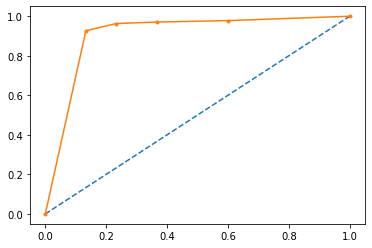

In [551]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc = roc_auc_score(cleaned_test_q01_label_7, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(cleaned_test_q01_label_7, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [552]:
y_test_pred_scores = cross_val_score(dtc, cleaned_test_q01_data, cleaned_test_q01_label_7, cv=10, scoring="accuracy")
y_test_pred_scores.mean()


0.9106617647058822

In [553]:
y_test_pred_2 = cross_val_predict(dtc, cleaned_test_q01_data, cleaned_test_q01_label_7, cv=10)


In [554]:
confusion_matrix(cleaned_test_q01_label_7, y_test_pred)


array([[ 19,  11],
       [  4, 132]])

In [555]:
precision_score(cleaned_test_q01_label_7, y_test_pred)


0.9230769230769231

In [556]:
recall_score(cleaned_test_q01_label_7, y_test_pred)


0.9705882352941176

In [274]:
from sklearn.tree import export_graphviz
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

export_graphviz(
        dtc,
        out_file=image_path("dtc_test.dot"),
        feature_names=cleaned_q01_data.columns,
        class_names='01-Truthfulness',
        rounded=True,
        filled=True
    )


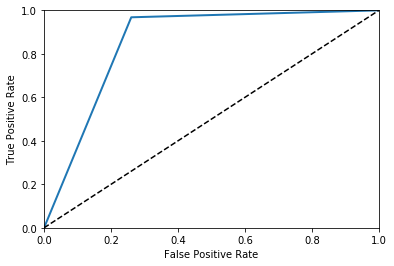

In [275]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(cleaned_q01_label_7, y_train_pred_2)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [276]:
from sklearn.metrics import roc_auc_score
roc_auc_score(cleaned_q01_label_7, y_train_pred_2)


0.8538624631268436

In [277]:
roc_auc_score(cleaned_test_q01_label_7, y_test_pred)

0.8019607843137255

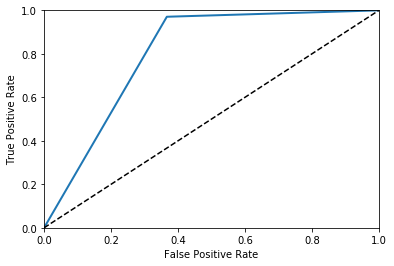

In [278]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(cleaned_test_q01_label_7, y_test_pred)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [279]:
from sklearn.tree import export_graphviz
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

export_graphviz(
        dtc,
        out_file=image_path("dtc.dot"),
        feature_names=cleaned_q01_data.columns,
        class_names='01-Truthfulness',
        rounded=True,
        filled=True
    )

In [280]:
list(cleaned_q01_label_7.columns)


['01-Truthfulness']

In [281]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
max_depth = np.arange(1, 6)
max_leaf_nodes = [2, 4, 6, 8, 10]
min_samples_leaf = [1, 2, 3, 4, 5]
min_samples_split = [2, 4, 6]
n_estimators = [3, 10, 30]
criterion = ['gini', 'entropy']

param_grid = [
{'criterion': criterion, 'n_estimators': n_estimators, 'max_depth': max_depth, 'max_leaf_nodes': max_leaf_nodes, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split}
]
rfc = RandomForestClassifier()

In [282]:
grid_search = GridSearchCV(rfc, param_grid, cv=10, scoring='accuracy')

In [283]:
grid_search = grid_search.fit(cleaned_q01_data, cleaned_q01_label_7.values.ravel())

/Users/smithkakar/anaconda2/envs/dissertation/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [284]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 30}

In [285]:
grid_search.best_score_

0.9394856278366112

In [286]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=30, random_state=42, criterion= 'entropy', max_depth=5, min_samples_split=2, min_samples_leaf=4, max_leaf_nodes=10)
rfc.fit(cleaned_q01_data, cleaned_q01_label_7.values.ravel())


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=5, max_features='auto', max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [287]:
y_pred_2 = cross_val_score(rfc, cleaned_q01_data, cleaned_q01_label_7.values.ravel(), cv=10, scoring="accuracy")
y_pred_2.mean()

0.9304268865462897

In [288]:
y_train_pred_2 = cross_val_predict(rfc, cleaned_q01_data, cleaned_q01_label_7.values.ravel(), cv=10)
#y_train_pred_2

In [289]:
confusion_matrix(cleaned_q01_label_7, y_train_pred_2)

array([[ 62,  34],
       [ 12, 553]])

In [290]:
precision_score(cleaned_q01_label_7, y_train_pred_2)

0.9420783645655877

In [291]:
recall_score(cleaned_q01_label_7, y_train_pred_2)

0.9787610619469026

In [292]:
roc_auc_score(cleaned_q01_label_7, y_train_pred_2)

0.8122971976401179

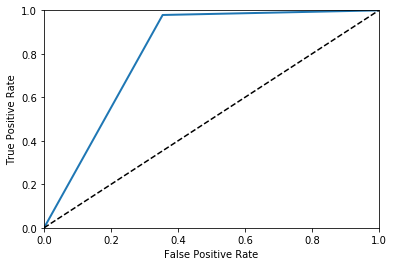

In [293]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(cleaned_q01_label_7, y_train_pred_2)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [294]:
y_test_rfc = rfc.predict(cleaned_test_q01_data)

In [295]:
y_test_rfc_pred = cross_val_predict(rfc, cleaned_test_q01_data, cleaned_test_q01_label_7.values.ravel(), cv=10)

In [296]:
confusion_matrix(cleaned_test_q01_label_7, y_test_rfc_pred)

array([[ 15,  15],
       [  5, 131]])

In [297]:
precision_score(cleaned_test_q01_label_7, y_test_rfc_pred)

0.8972602739726028

In [298]:
recall_score(cleaned_test_q01_label_7, y_test_rfc_pred)

0.9632352941176471

In [299]:
roc_auc_score(cleaned_test_q01_label_7, y_test_rfc_pred)

0.7316176470588236

In [169]:
from sklearn.tree import export_graphviz
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

export_graphviz(
        rfc,
        out_file=image_path("dtc2.dot"),
        feature_names=cleaned_q01_data.columns,
        class_names='01-Truthfulness',
        rounded=True,
        filled=True
    )

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
corr_matrix = user_responses.corr()

In [ ]:
#corr_matrix

In [ ]:
#Use Kendall or Spearman instead of Pearson R for ordinal Likert type data
corr_matrix = user_responses.iloc[:,9:].corr(method='kendall')

In [ ]:
#corr_matrix

In [ ]:
def plot_corr(corr,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''


    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [ ]:
corr_matrix = user_responses.corr(method='spearman')

In [632]:
n = range(8,12)


range(8, 12)

In [631]:
for i in range(8,205,4):
    print(i)

8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
204
